In [26]:
# Importing packages
import pandas as pd
import numpy as np
from random import gauss
from pandas.plotting import autocorrelation_plot
import warnings
import itertools
from random import random

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# import matplotlib as mpl
import seaborn as sns


import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from random import gauss
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from random import random
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

ValueError: numpy.ufunc size changed, may indicate binary incompatibility. Expected 232 from C header, got 216 from PyObject

In [ ]:
# general settings
class CFG:
    data_folder = './input/'
    img_dim1 = 20
    img_dim2 = 10
    
    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})

<a id="section-one"></a>
# Introduction

sequence you record over time, where the data may show pattern through time

<a id="section-two"></a>
# Patterns

The first we can do to identify patterns in a time series is separate it into components with easily understandable characteristics:

\begin{equation}
X_t = T_t + S_t + C_t + I_t \quad 
\end{equation}

where: 
* $T_t$: the trend shows a general direction of the time series data over a long period of time. It represents a long-term progression of the series (secular variation)  

* $S_t$: the seasonal component with fixed and known period. It is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors: annual, monthly or weekly. Obvious examples include daily power consumption patterns or annual sales of seasonal goods.

* $C_t$: (optional) cyclical component is a repetitive pattern which does not occur at fixed intervals - usually observed in an economic context like business cycles. 

* $I_t$: the irregular component (residuals ) consists of the fluctuations in the time series that are observed after removing trend and seasonal / cyclical variations.

We may have different combinations of trends and seasonality. Depending on the nature of the trends and seasonality, a time series can be modeled as an additive or multiplicative time series. Each observation in the series can be expressed as either a sum or a product of the components.

It is worth pointing out that an alternative to using a multiplicative decomposition is to first transform the data until the variation in the series appears to be stable over time, then use an additive decomposition. When a log transformation has been used, this is equivalent to using a multiplicative decomposition because
\begin{equation}
X_t = T_t * S_t * I_t
\end{equation}

is equivalent to 

\begin{equation}
log X_t = log T_t + log S_t + log I_t
\end{equation}


A popular implementation for calculating the fundamental decomposition can be used via the statsmodels package:

In [ ]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages.
    
    Parameters
    ----------
    x : array_like
        Time series. If 2d, individual series are in columns. x must contain 2
        complete cycles.
    model : {"additive", "multiplicative"}, optional
        Type of seasonal component. Abbreviations are accepted.
    filt : array_like, optional
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by
        two_sided.
    period : int, optional
        Period of the series. Must be used if x is not a pandas object or if
        the index of x does not have  a frequency. Overrides default
        periodicity of x if x is a pandas object with a timeseries index.
    two_sided : bool, optional
        The moving a

## Examples

<AxesSubplot:xlabel='date'>

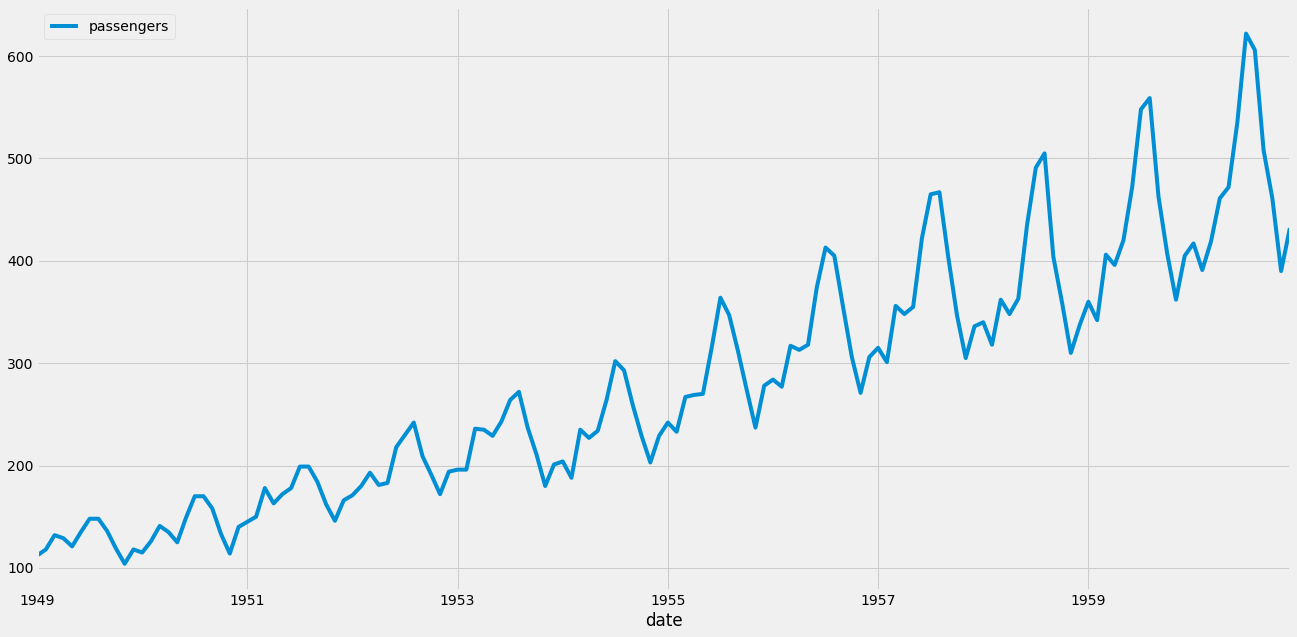

In [ ]:
series = pd.read_csv(CFG.data_folder + 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()

Let's start with a basic additive decomposition:

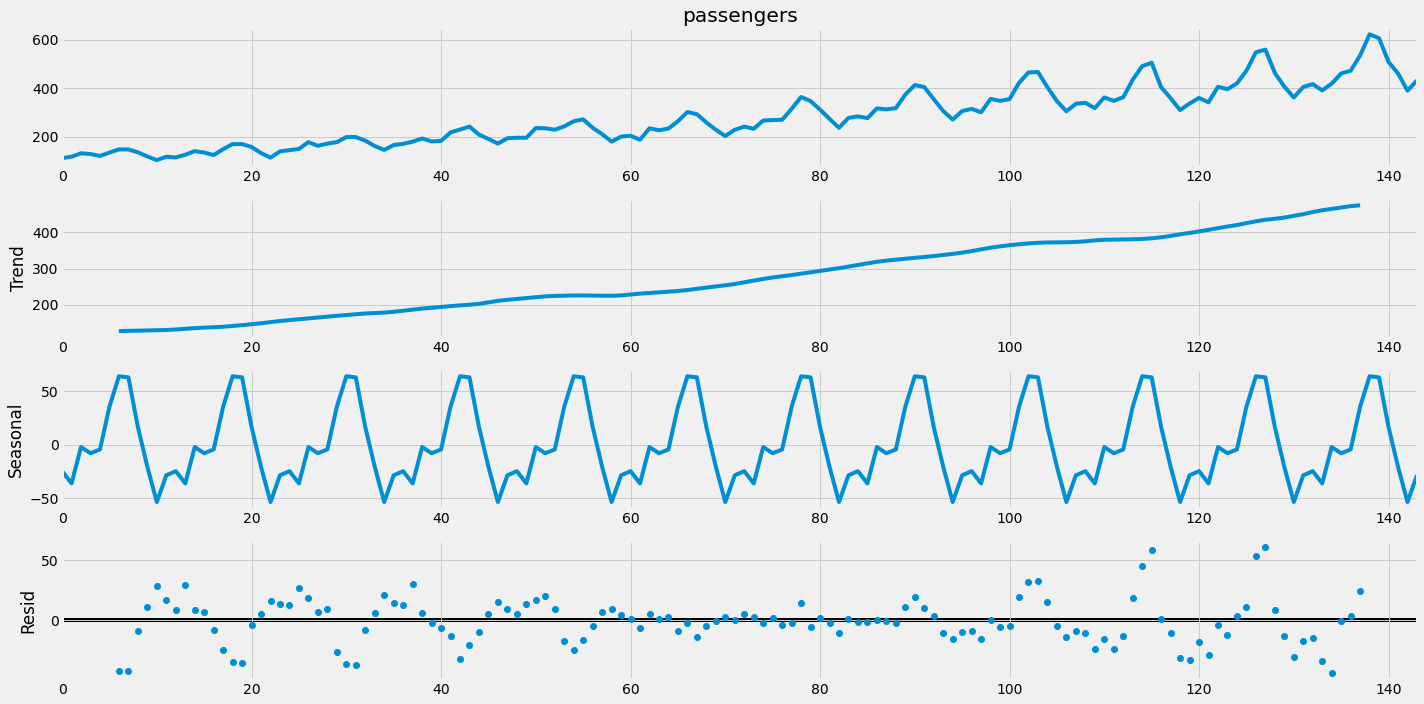

In [ ]:
# decomposition
decomposition = sm.tsa.seasonal_decompose(series["passengers"],period =12) 
figure = decomposition.plot()
plt.show()

Trend and seasonality are behaving more or less in line with expectations, but the behavior of the residuals is clearly not consistent over time (average level of oscillations in the middle of the sample is very different than on either end). While there are many possible reasons, one quick explanation is the additive vs multiplicative relationship between the series components - which is something we can examine quickly:

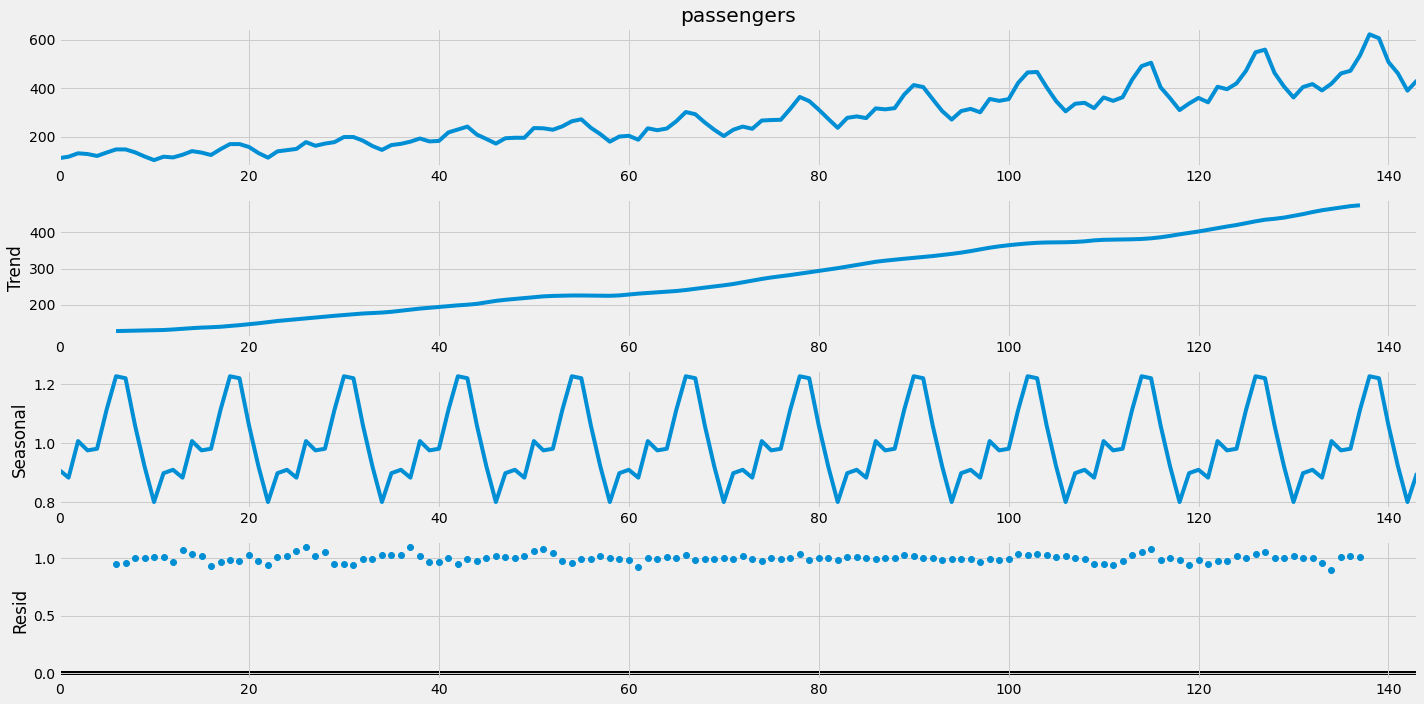

In [ ]:
decomposition = sm.tsa.seasonal_decompose(series["passengers"],period =12, model = 'multiplicative') 
figure = decomposition.plot()
plt.show()

Not much of a qualitative change in trend and seasonality components, but the residuals looks much more stable around a constant level - such phenomenon does not of course imply stationarity by itself, but at least a clear signal in the opposite direction is not there anymore.

### Changes in level of savings in the US

Let's check how does seasonal decomposition work with some other popular datasets:

<AxesSubplot:xlabel='date'>

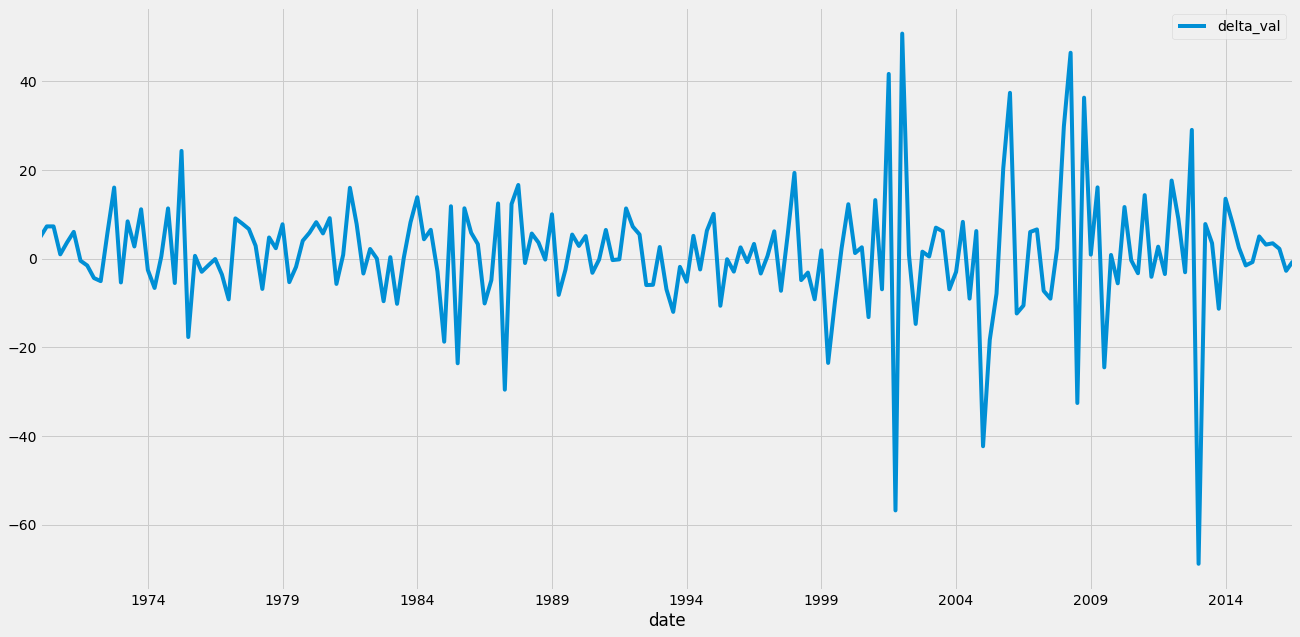

In [ ]:
series = pd.read_csv(CFG.data_folder + 'savings_change.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()

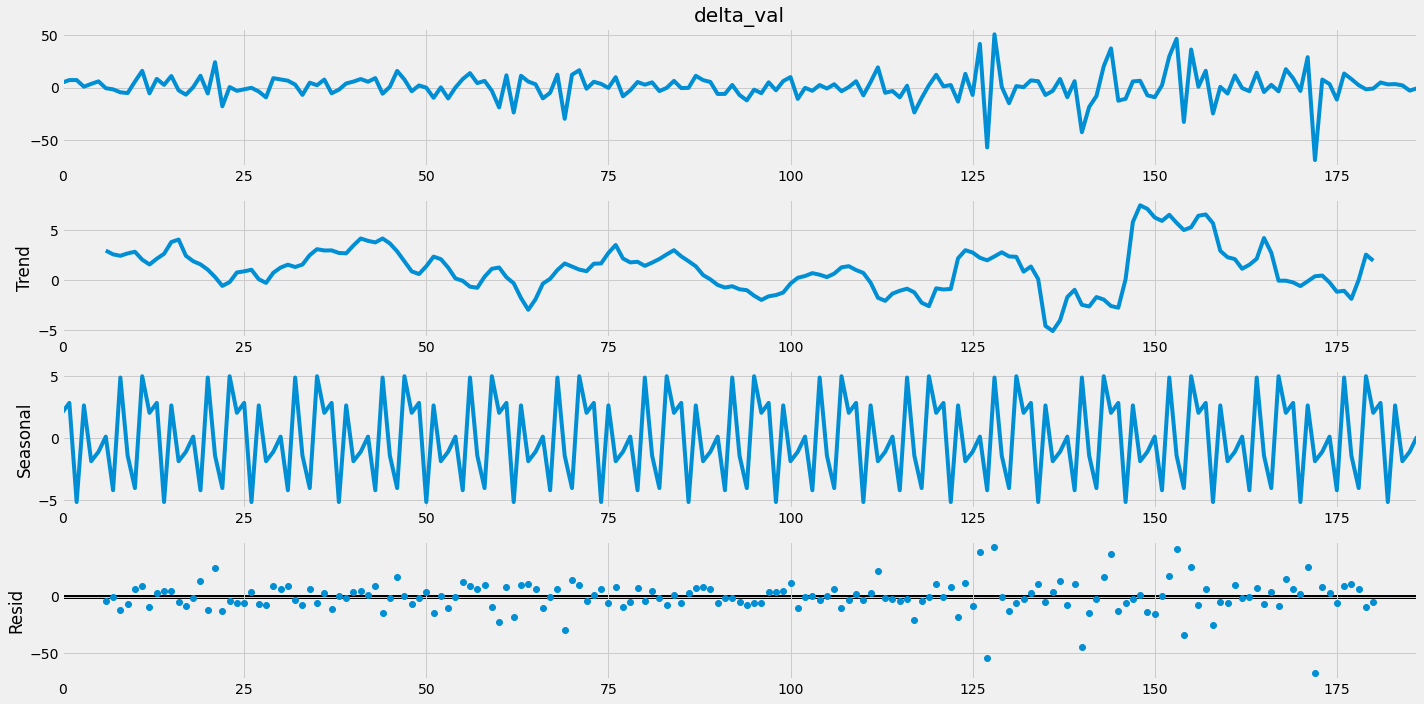

In [ ]:
# decomposition
decomposition = sm.tsa.seasonal_decompose(series["delta_val"],period =12) 
figure = decomposition.plot()
plt.show()

### Annual averages of the daily sunspot areas

<AxesSubplot:xlabel='date'>

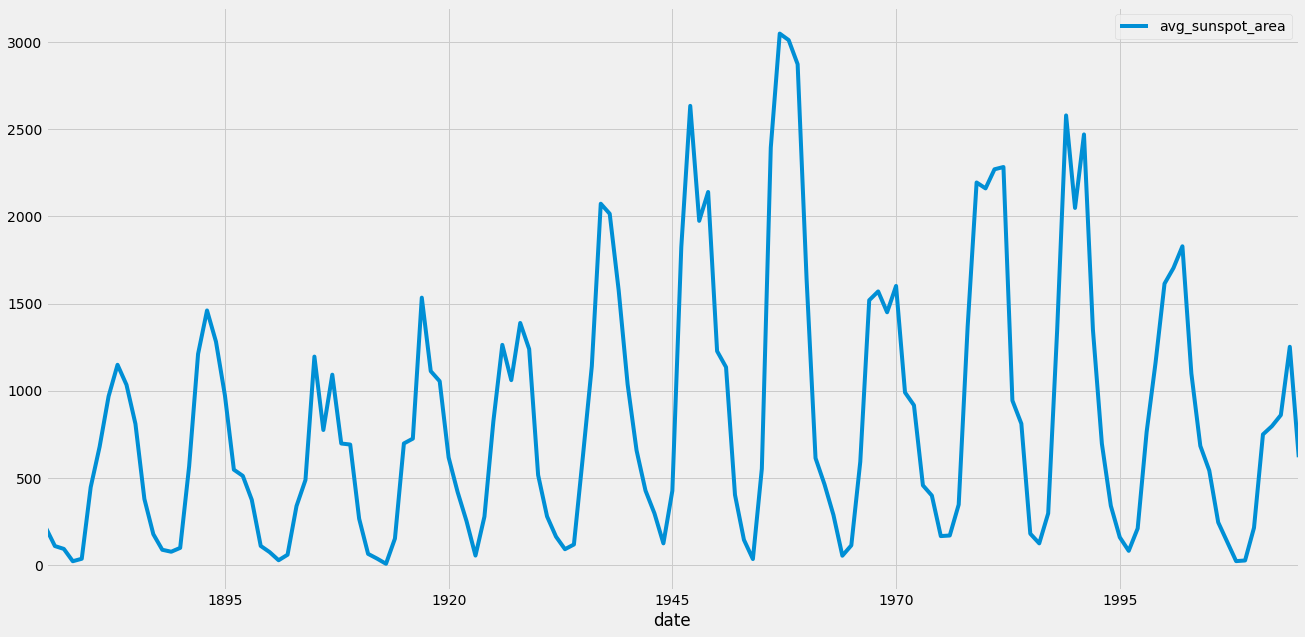

In [ ]:

series = pd.read_csv(CFG.data_folder + 'sunspots.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()

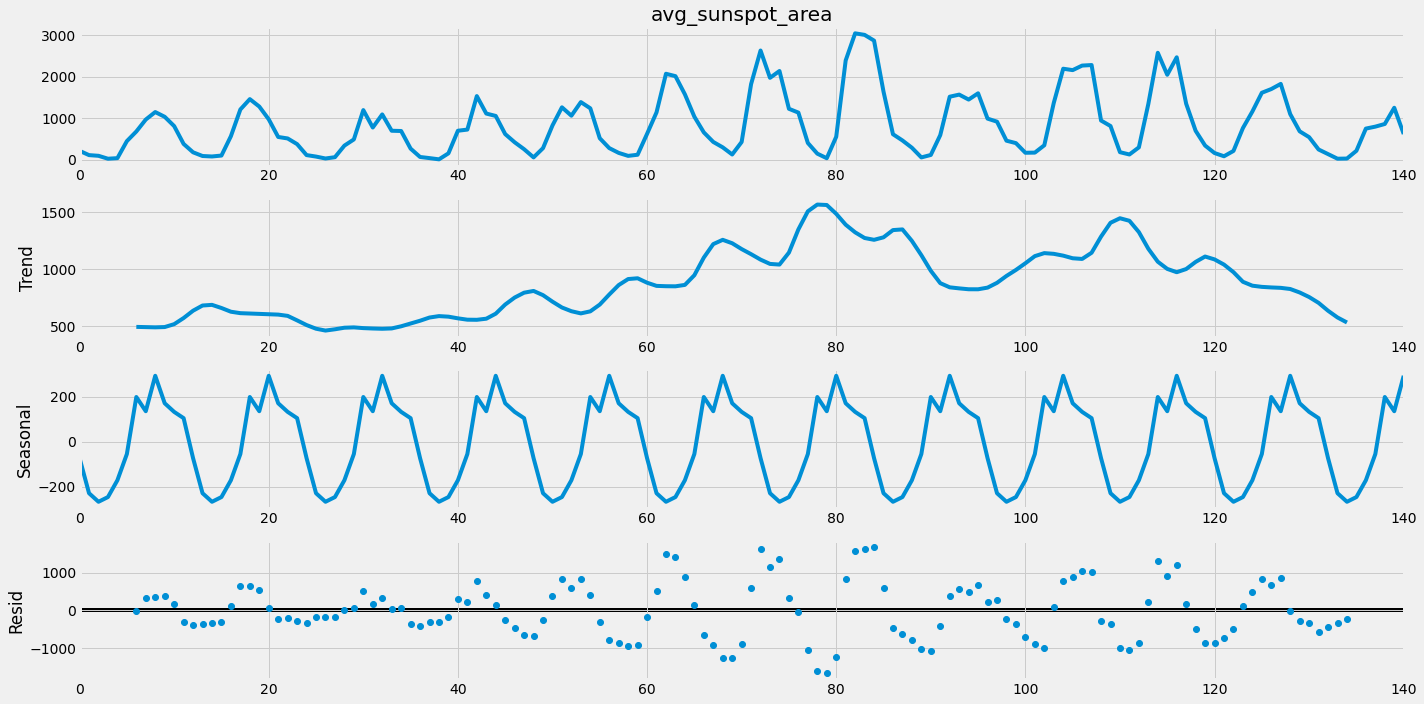

In [ ]:
decomposition = sm.tsa.seasonal_decompose(series["avg_sunspot_area"],period =12) 
figure = decomposition.plot()
plt.show()

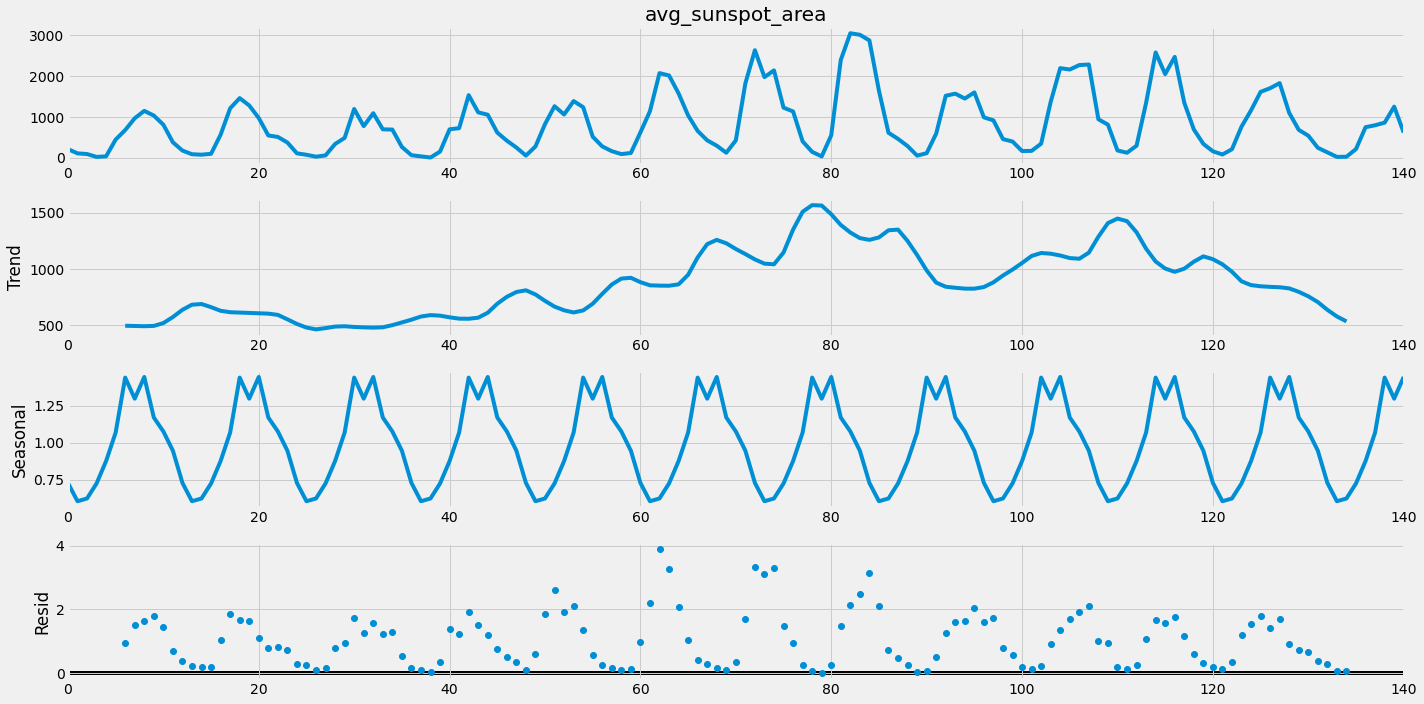

In [ ]:
decomposition = sm.tsa.seasonal_decompose(series["avg_sunspot_area"],period =12, model = 'multiplicative') 
figure = decomposition.plot()
plt.show()

As we can see, changing the decomposition type to multiplicative alleviates the problem with residual behavior, but only to a certain degree - the pattern is still not consistent, with increase in the amplitude in the middle of the sample. This demonstrates that while seasonal decomposition is a fast tool, it has severe limitations when dealing with more sophisticated data generating processes.

<a id="section-three"></a>
# Dependence

The only way to succesful prediction is if past values of a series carry some information about the future behavior - in other words, if the present values are dependent on the past. A fast - and therefore very popular - manner of examining this dependence are the autocorrelation and partial autocorrelation functions, which are defined below:

Mean function of time series:
\begin{equation}
\mu_t = E [X_t]
\end{equation}

Autocovariance function of a time series:
\begin{equation}
\gamma(s,t) = Cov(X_s, X_t) = E [X_s X_t] - E[X_s]E[X_t]
\end{equation}

which leads to the following definitions of ACF / PACF:

Autocorrelation:
\begin{equation}
\rho(u,t+u) = Cor(X_{u}, X_{t+u}) = \frac{Cov(X_t, X_{t+u})}{Var(X_t) Var(X_{t+u})}
\end{equation}

Partial autocorrelation:
    \begin{equation}
    \phi(u) = Cor(X_t, X_{t+u}|X_{t+1}, \ldots , X_{t+u-1})
    \end{equation}

An intuitive way to think about it is that ACF at lag $k$ measures a linear dependence between $X_t$ and $X_{t+k}$, while PACF captures the dependence between those values **correcting** for all the intermediate effects.

<a id="section-four"></a>
# Stationarity


Unconditional joint probability distribution does not change when shifted in time. This implies that parameters such as mean and variance also do not change over time.

Since stationarity is an assumption underlying many statistical procedures used in time series analysis, non-stationary data are often transformed to become stationary. A trend stationary process is not strictly stationary, but can easily be transformed into a stationary process by removing the underlying trend, which is solely a function of time; the same holds true for a stationary process with an added cyclical component. 

The core idea is that it's much easier to model dynamic behavior over time if the statistical properties do not change: oscillations happen around the same level, the amplitude does not change too much etc (in other words, the probability distribution of $X_t$ is the same as the distribution of $X_{t+h}$)- such models are well understood. Algorithms are likely to yield better predictions if we apply them to stationary processes, because we do not need to worry about e.g. concept drift between our training and test sets. 


If we are dealing with a process that does not adhere to those characteristics, we can either try and capture them directly or transform it in such a manner that it can be considered stationary. 

 
Below we plot a few examples of stationary and non-stationary series, starting with the simplest non-trivial stationary series: Gaussian white noise.

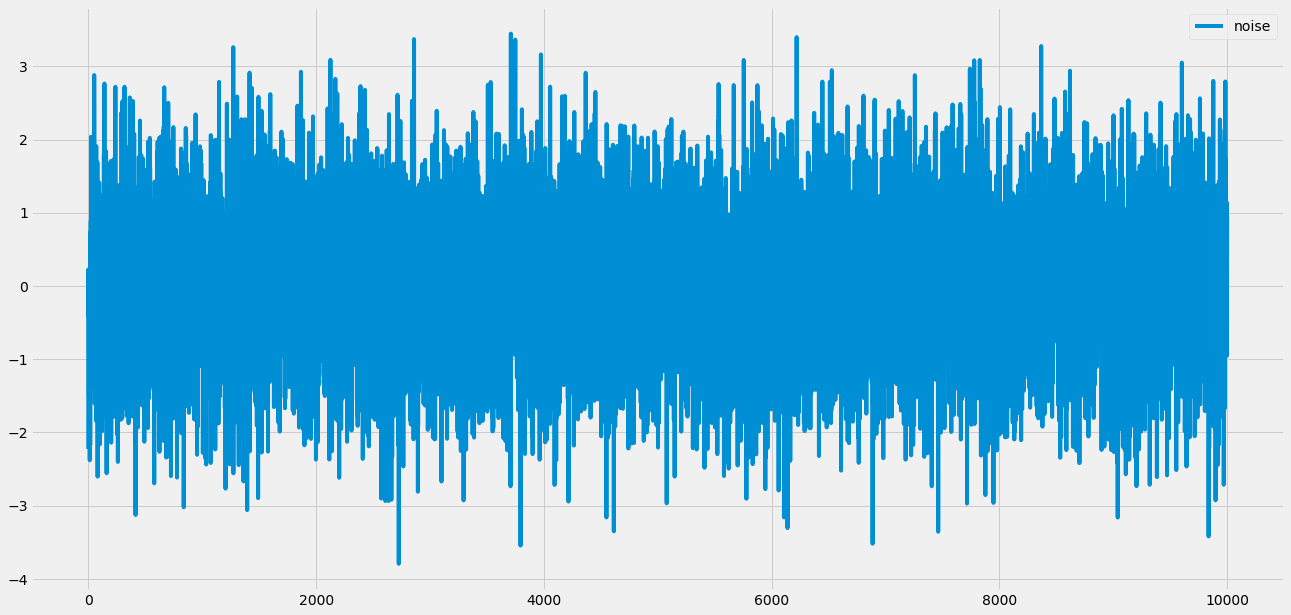

In [ ]:
xseries = pd.DataFrame(data = np.random.normal(0, 1, 10000), columns = ['noise'] )
xseries.plot()
print()

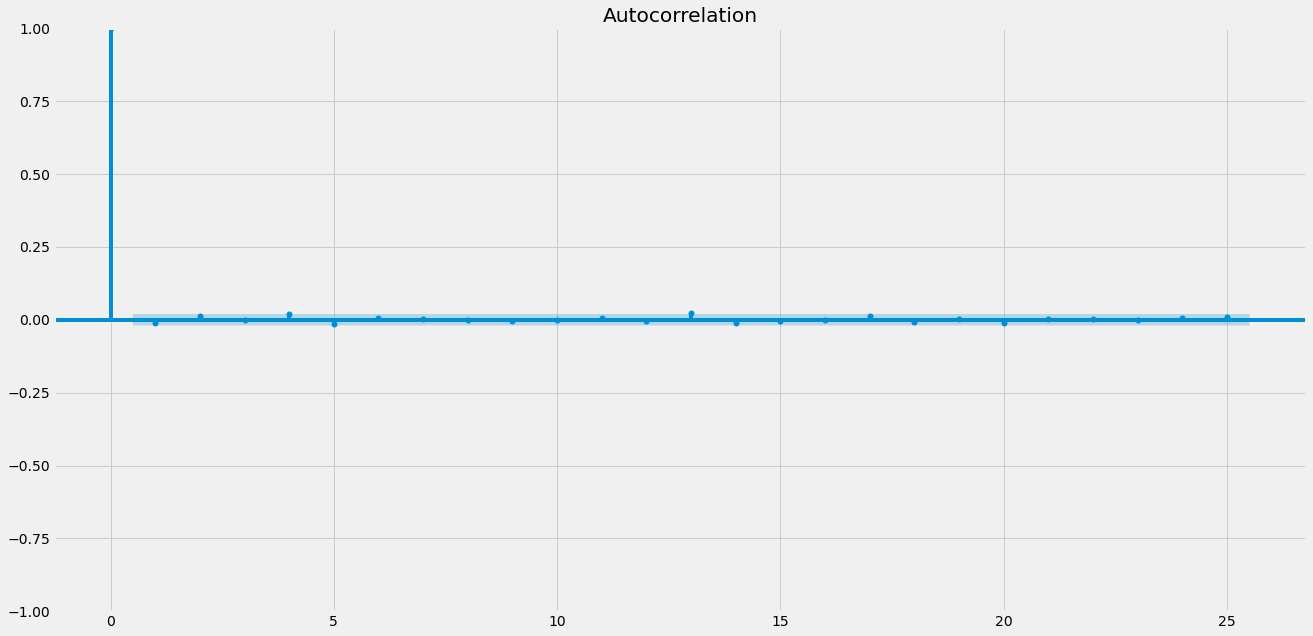

In [ ]:
plot_acf(xseries['noise'], lags = 25)
print()

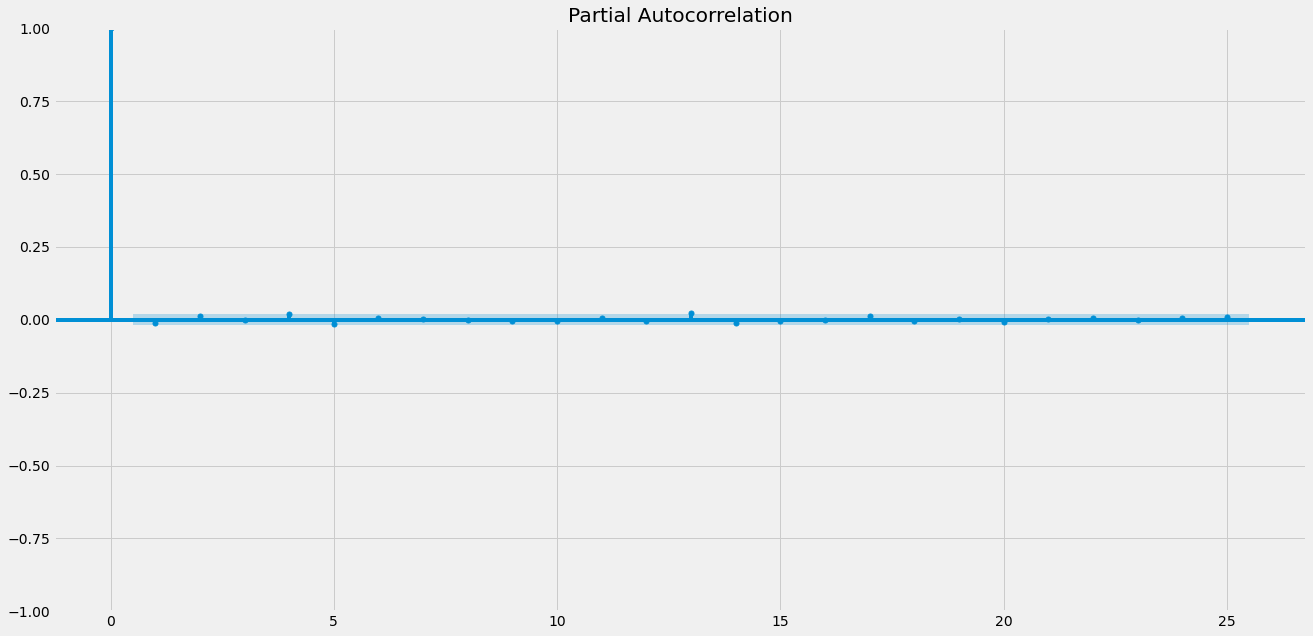

In [ ]:
plot_pacf(xseries['noise'], lags = 25)
print()

For a slightly more interesting example (of non-stationary behavior), we can examine the passengers dataset:

<AxesSubplot:xlabel='date'>

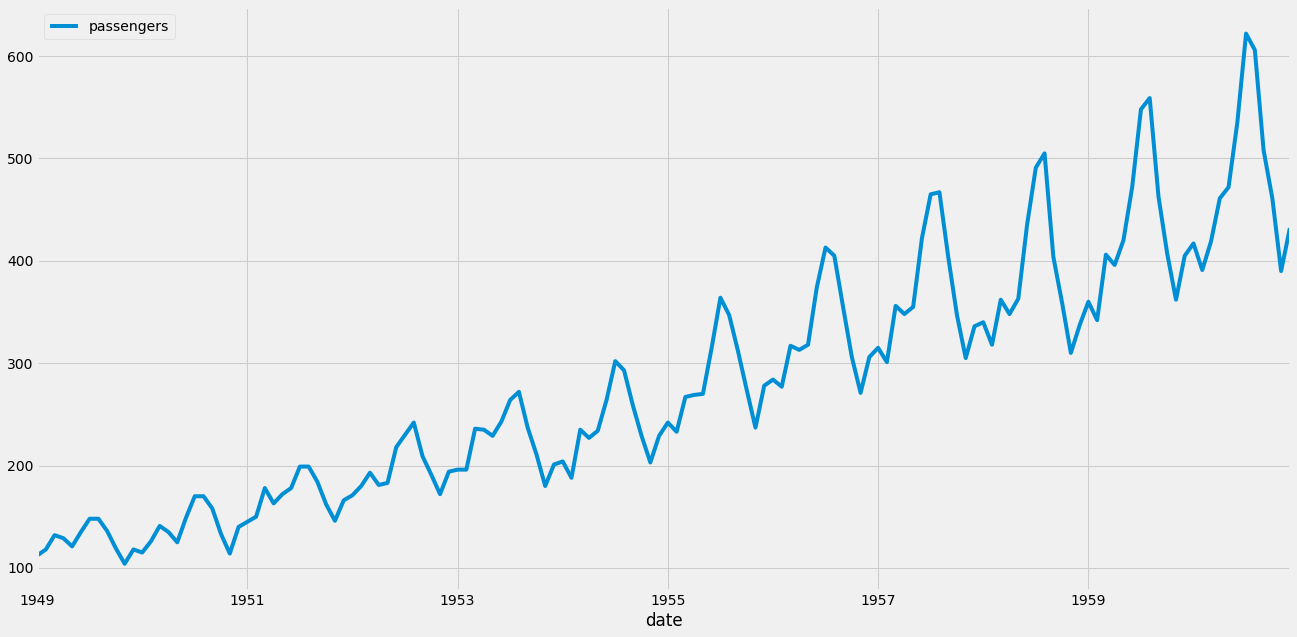

In [ ]:
# Non-stationary example
series = pd.read_csv(CFG.data_folder + 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()

The stationarity of a series can be checked by examining the distribution of the series: we split the series into 2 contiguous parts and compute the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary.

<AxesSubplot:ylabel='Frequency'>

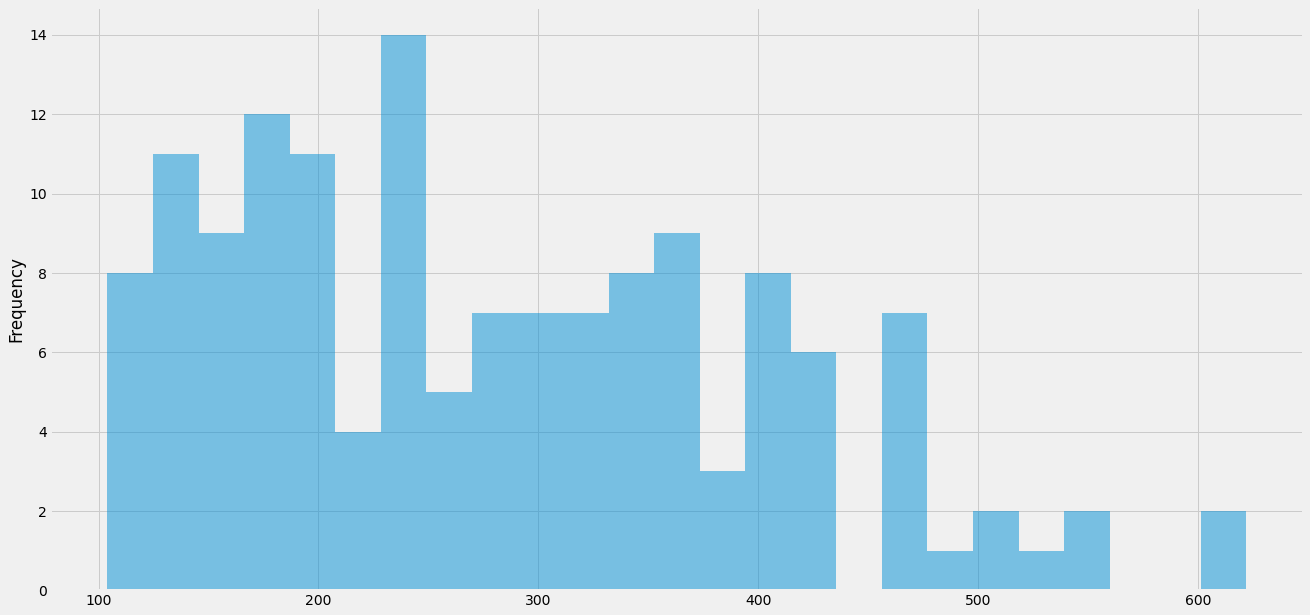

In [ ]:
series = pd.read_csv(CFG.data_folder + 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
# series.set_index('date').plot()

series['passengers'].plot.hist(bins=25, alpha=0.5)

Compute the summary statistics:

In [ ]:
X = series.passengers.values
split =  int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean:')
print('chunk1: %.2f vs chunk2: %.2f' % (mean1, mean2))
print('variance:')
print('chunk1: %.2f vs chunk2: %.2f' % (var1, var2))

mean:
chunk1: 182.90 vs chunk2: 377.69
variance:
chunk1: 2244.09 vs chunk2: 7367.96


The values are clearly very different across the two data subsets, which strongly suggests non-stationarity. However, visual inspection is not what one would could a rigorous criterion - so let's define things in a formal manner.

## (A little bit of) theory

Given a stochastic process $\{X_t\}$ and cdf $F_X$, a process is strictly stationary iff 

\begin{equation}
F_X(X_{t_1}, \ldots, X_{t_n}) = F_X(X_{t_1 + \tau}, \ldots, X_{t_n + \tau})
\end{equation}

The definition is very powerful (if we know a cdf of a distribution, we can infer everything) - however, it is not possible to verify in practice. For that reason, a less strict variant has been introduced: weak a.k.a. second order stationarity:

a process $\{X_t\}$ is weakly stationary if it satisfies the following conditions:

* $\mu_t = \mu_{t + \tau}$
* $\gamma(s,t) = \gamma(s-t)$
* $Var(X_t) < \infty$

Implication:
* constant mean
* covariance only depends on distance in time between variables
* autocorrelation:
    \begin{equation}
    \rho(u) = \frac{\gamma(u)}{\gamma(0)}
    \end{equation}
    
    
So how can we turn a non-stationary series into a stationary one? Popular transformations include (but are not limited to!): 
* differencing the series 
* taking the log of the series
* power transforms

### Differencing

* Lag operator of order $d$:

\begin{equation}
\nabla_d X_t = X_t - X_{t-d}
\end{equation}
    
Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and so eliminating trend and seasonality. Differencing at lag 1 is best thought of as discreet counterpart to differentiation: first derivative of a linear function is flat, first derivative of a quadratic function is linear etc - so if we want to get rid of a trend behaving like polynomial of degree $n$, we need to apply the differencing operator $n$ times. 


It is important to understand the difference between iterating diffencing operator $n$ times and differencing once at lag $n$ - which is best demonstrated in an example.

### Tests for stationarity

While inspecting plots before / after transformation can be useful to assess presence of trends or seasonalities (as we did above with the passengers dataset), in practice we need a more formal approach - like testing a hypothesis (introduction to statistical tests is beyond the scope of this notebook, so if you feel like you need a refresher, please consult other sources). The most popular tests dealing with stationarity are: 

* Augmented Dickey-Fuller (ADF))
* Kwiatkowski–Phillips–Schmidt–Shin (KPSS)
* Philips-Perron (PP)

ADF test is a unit root test.  It determines how strongly a time series is defined by a trend. 
-  Null Hypothesis (H0): Null hypothesis of the test is that the time series can be represented by a unit root that is not stationary.
- Alternative Hypothesis (H1): Alternative Hypothesis of the test is that the time series is stationary.

Interpretation of p value:
- above $\alpha$: Accepts the Null Hypothesis (H0), the data has a unit root and is non-stationary.
- below $\alpha$ : Rejects the Null Hypothesis (H0), the data is stationary.

ACF / PACF

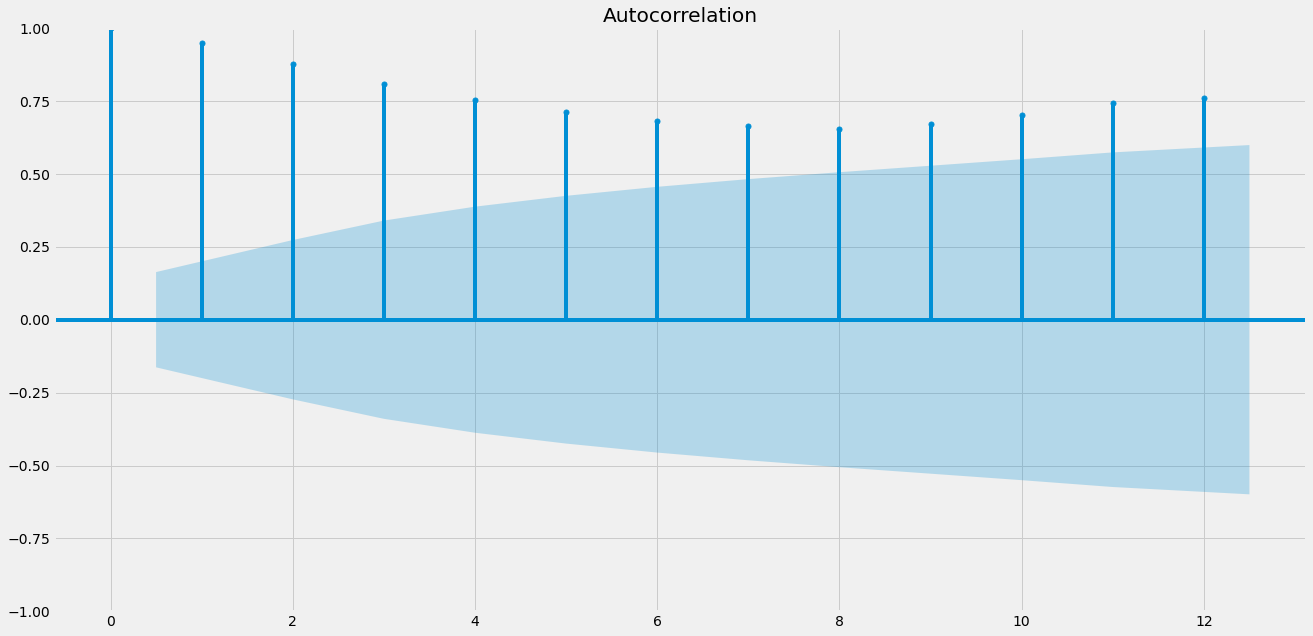

In [ ]:
plot_acf(X, lags = 12)
plt.show()

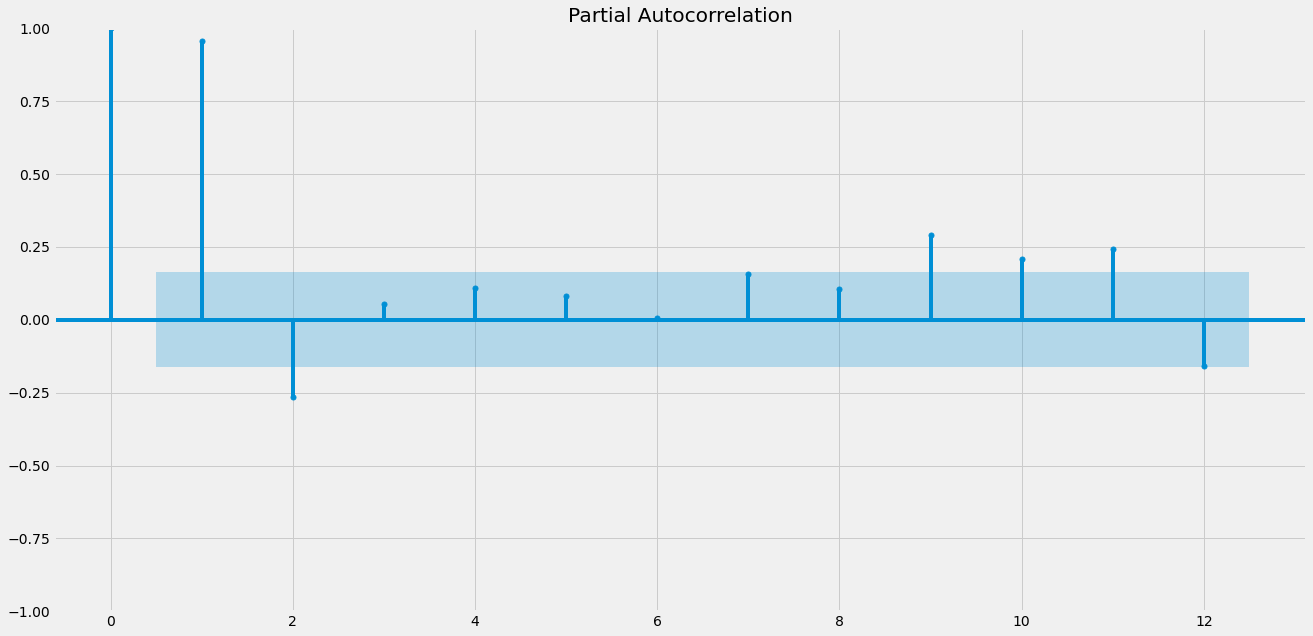

In [ ]:
plot_pacf(X, lags = 12)
plt.show()

We can decompose the series to check the components one by one: which parts are responsible for the non-stationary behavior?

In [ ]:
decomposition = seasonal_decompose(X, model='additive', period =12)

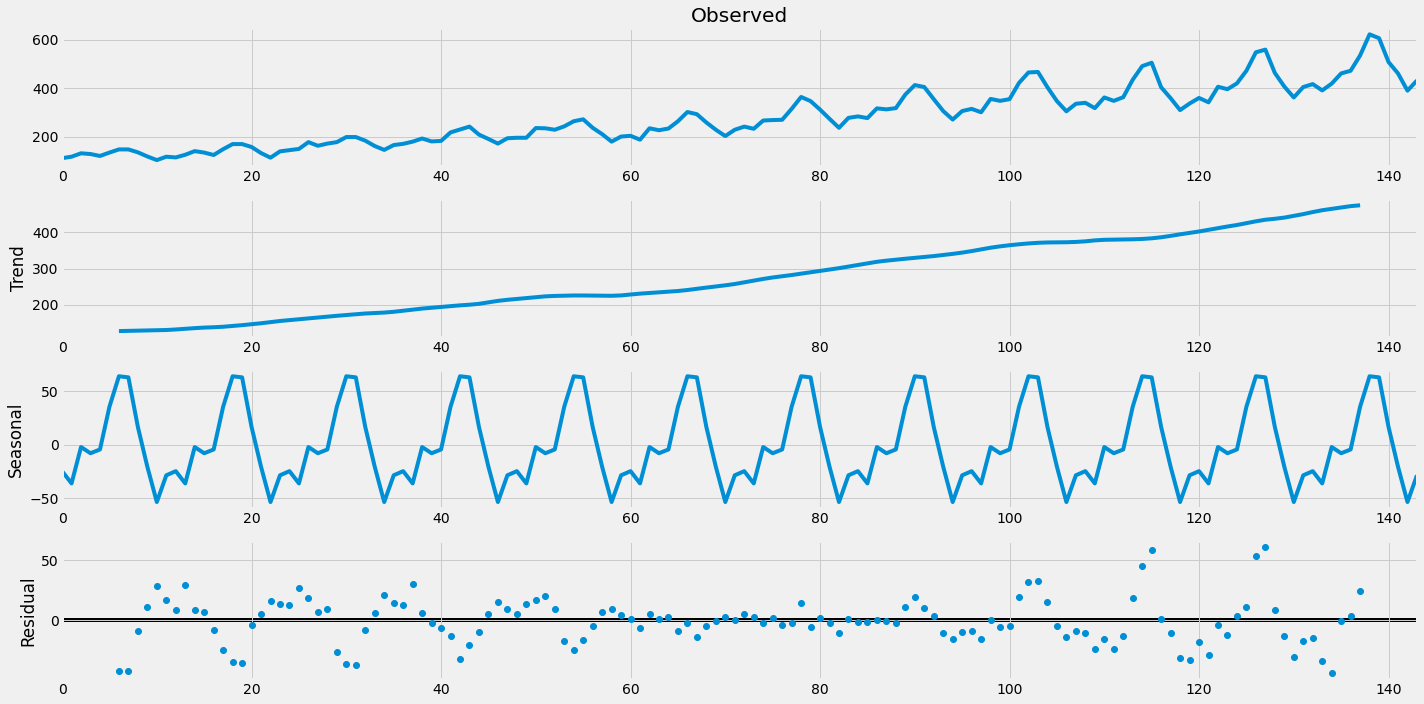

In [ ]:
figure = decomposition.plot()
plt.show()

In [ ]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


An important caveat: it is useful to remember that statistical tests do not **accept** a hypothesis - we can only fail to reject it.

In [ ]:
# skip the start of the series: adfuller does not handle missing values which appear for values within the first full period
result = adfuller(decomposition.trend[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.025948
p-value: 0.994532


In [ ]:
result = adfuller(decomposition.seasonal[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7952463448638289.000000
p-value: 0.000000


In [ ]:
result = adfuller(decomposition.resid[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.029170
p-value: 0.000019


As we can see, the hypothesis of non-stationarity is non rejected for the trend component, but not for seasonal. The reason for that is that ADF test check for a very specific form of non-stationarity, namely variation in the presence of a linear trend (existence of a single unit root) - while the seasonal component is clearly not stationary (see graph above), it is a qualitatively different kind of behavior.

Let's go back to our hammer-and-nail approach and try some transformations to make the series stationary.

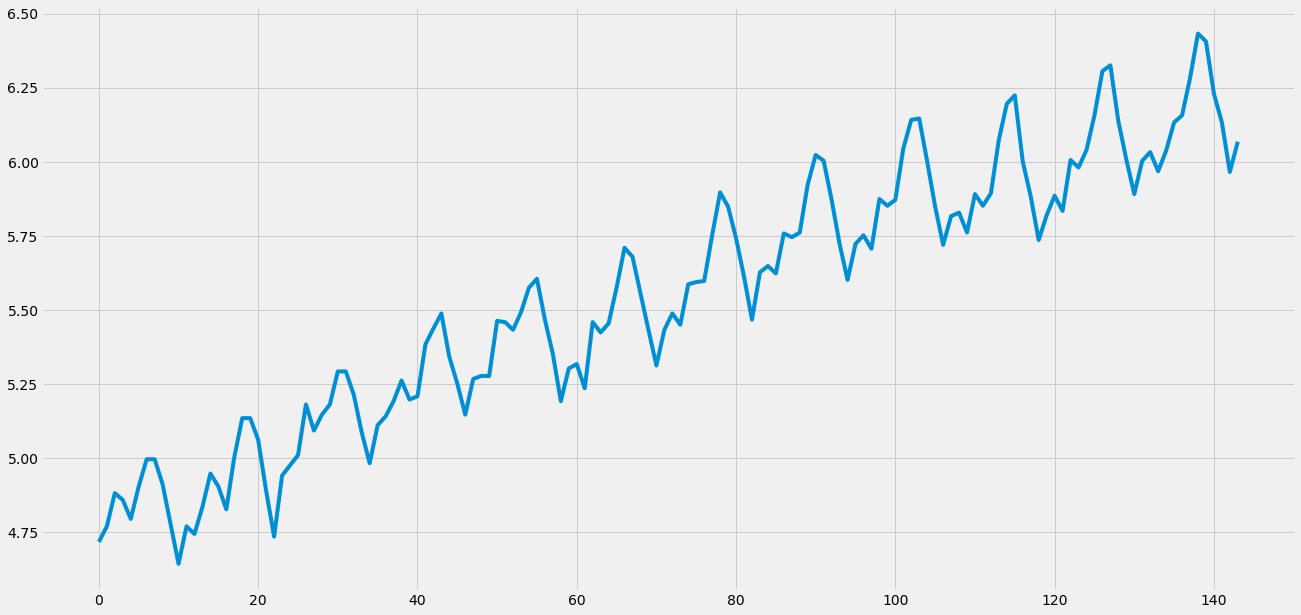

In [ ]:
series['passengers2'] = np.log(series['passengers'])
series.passengers2.plot()
plt.show()

Applying a logarithm does not remove the trend, but it does seem to stabilize the amplitude (periodic variations have comparable magnitude now). How does that translate into ADF results?

In [ ]:
result = adfuller(series.passengers2)
print('p-value: %f' % result[1])

p-value: 0.422367


The null is still not rejected, but p-value has dropped - which indicates the transformations are the right way to go. Next, we can try differentiating to get rid of the trend

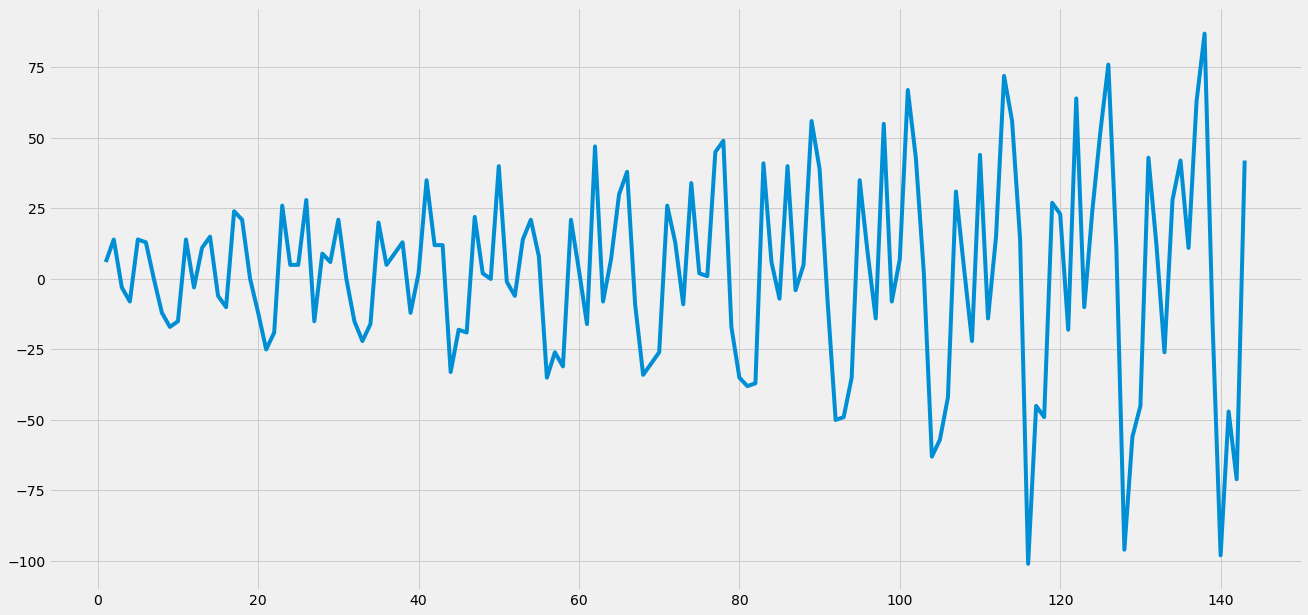

In [ ]:
series['passengers3'] = series['passengers'].diff()
series.passengers3.plot()
plt.show()

As expected, differentiation removes the trend (oscillations happen around a fixed level), but variations amplitude is magnified.

In [ ]:
result = adfuller(series.passengers3[10:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.830154
p-value: 0.054094


We continue moving in the right direction - what happens if we combine the two transformations?

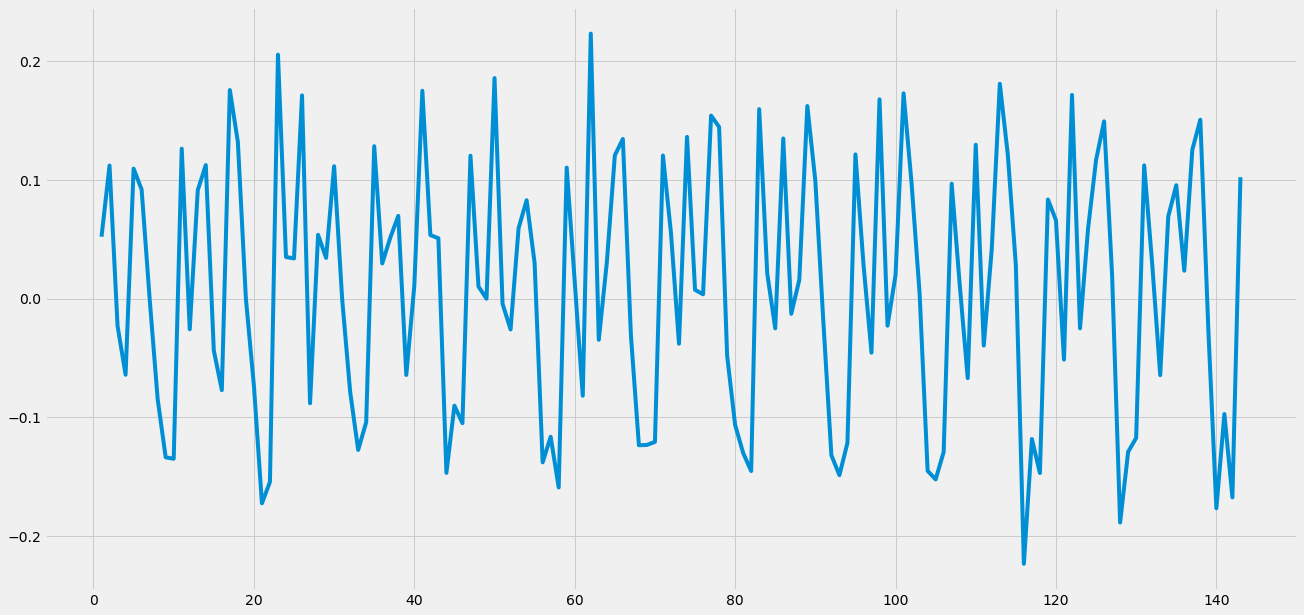

In [ ]:
series['passengers4'] = series['passengers'].apply(np.log).diff()
series.passengers4.plot()
plt.show()

In [ ]:
result = adfuller(series.passengers4[10:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.086110
p-value: 0.027598


So after applying logarithm (to stabilize the variance) and differentiation (to remove the trend), we have transformed our series to one that can be plausibly treated as stationary. We can verify that intuition by examining ACF and PACF:

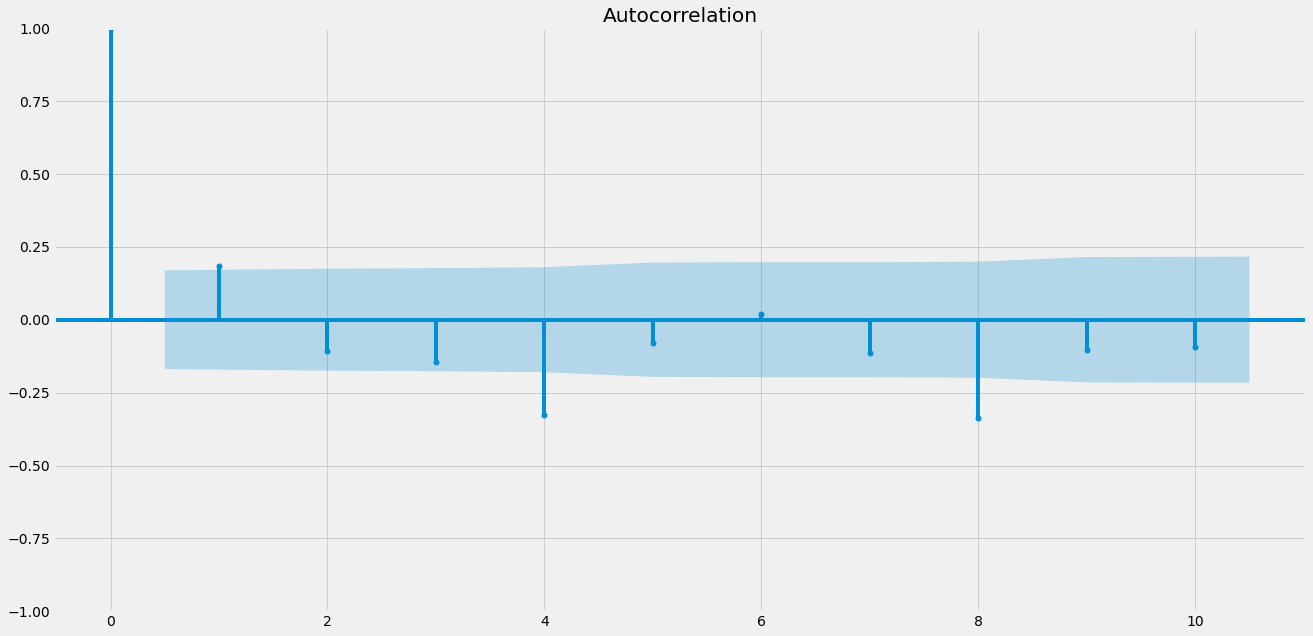

In [ ]:
plot_acf(series['passengers4'][10:], lags = 10)
plt.show()

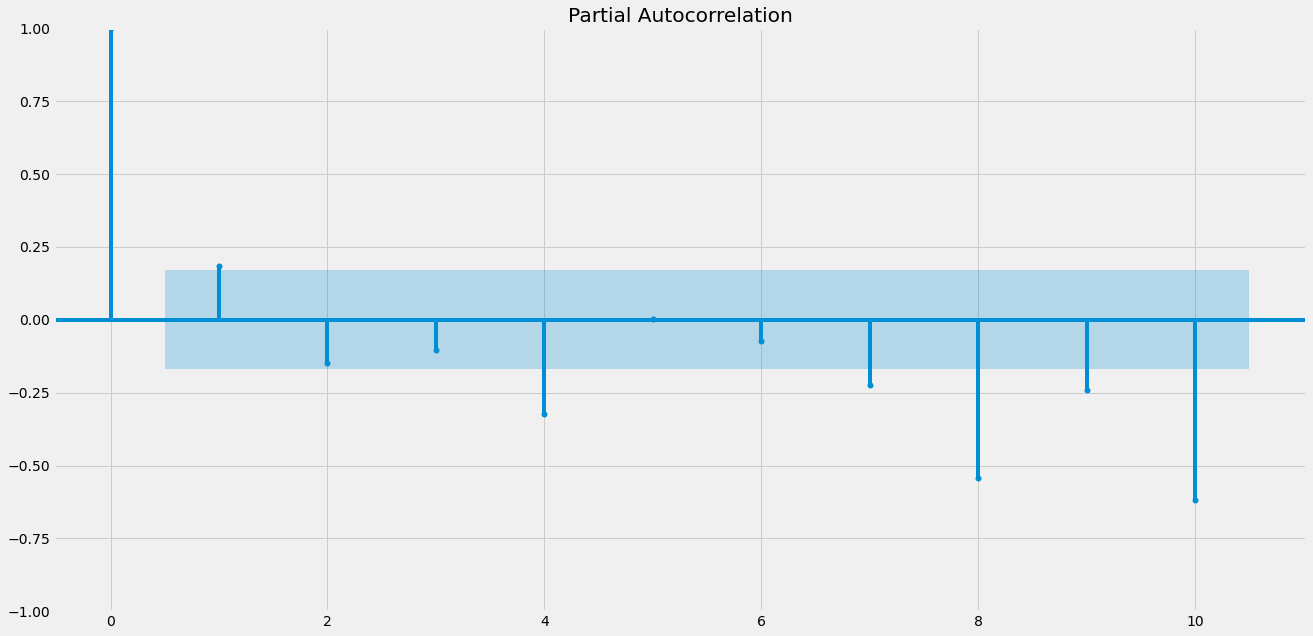

In [ ]:
plot_pacf(series['passengers4'][10:], lags = 10)
plt.show()

New


* [Exponential smoothing ](#section-one)
* [Popular methods](#section-two)
* [Anomaly detection](#section-three)
* [Example pipeline](#section-four)

<a id="section-one"></a>
# Exponential smoothing

As mentioned above, exponential moving average (EMA) assigns exponentially decreasing weights over time. The functions as a low-pass filter that removes high-frequency noise (and can be formulated as a special case of a more general problem of recursive filtering).

A complete taxonomy of ETS (error, trend, seasonality) models can be found in Hyndman et al "Forecasting with Exponential Smoothing: The State Space Approach" - below we discuss the three most popular models from that class. 

<a id="section-two"></a>
# Popular methods

## EWMA

Simple Exponential Smoothing (Brown method) is defined by the relationship:

\begin{equation}
S_t = \alpha X_t + (1-\alpha) S_{t-1} \quad \text{where} \quad \alpha \in (0,1)
\end{equation}

or equivalently:

\begin{equation}
S_t = S_{t-1} + \alpha  (X_t - S_{t-1})
\end{equation}

Few observations around that definition:
* the smoothed series is a simple weighted average of the past and the present 
* interpretation of smoothing factor $\alpha$: recency vs smoothing (see below). It defines how quickly we will "forget" the last available true observation.
* $\alpha$ is selected on the basis of expert judgement or estimated (with MSE); statsmodels does the estimation by default
* by its very nature, smoothing needs some time to catch up with the dynamics of your time series. A rule of thumb for a reasonable sample size is that you need $\frac{3}{\alpha}$ observations.
* Exponentiality is hidden in the recursiveness of the function -- we multiply by  $(1−\alpha)$  each time, which already contains a multiplication by the same factor of previous model values.
* the method is suitable for forecasting data with no clear trend or seasonal pattern

With the setup of the above equation, we have the following form of a long term forecast:
\begin{equation}
\hat{X}_{t+h} = S_t
\end{equation}

which means simply that out of sample, our forecast is equal to the most recent value of the smoothed series.

It's an old cliche that a picture is worth a thousand words - so the three pictures below should give you a truly excellent intuition ;-) on how single exponential smoothing works.

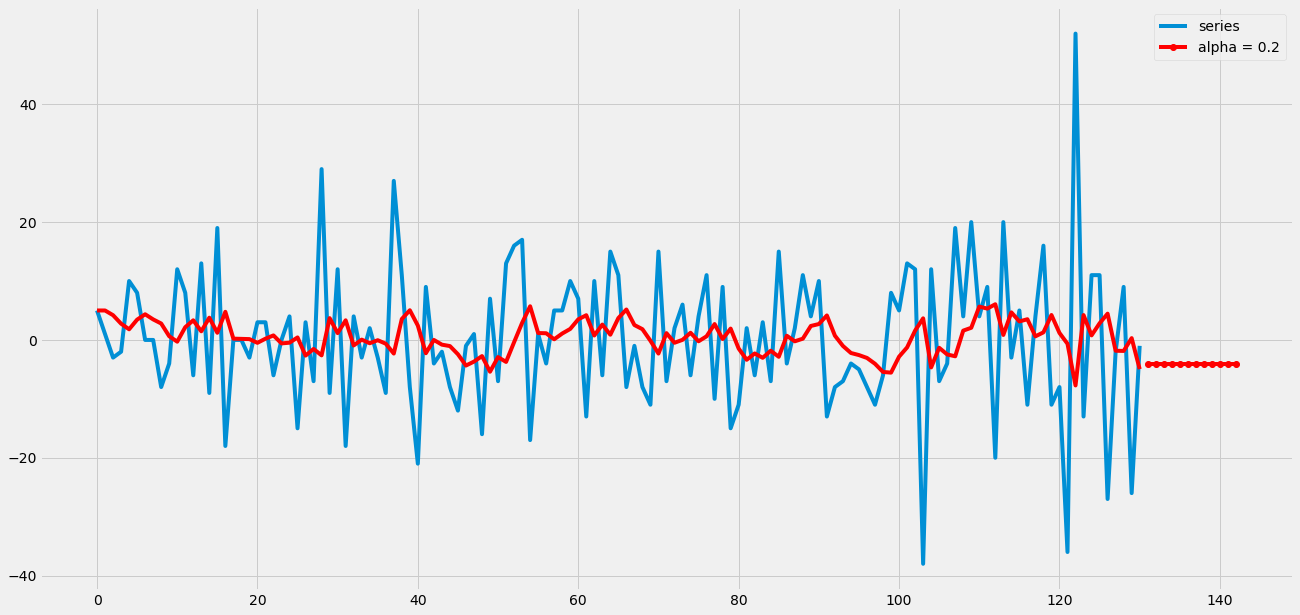

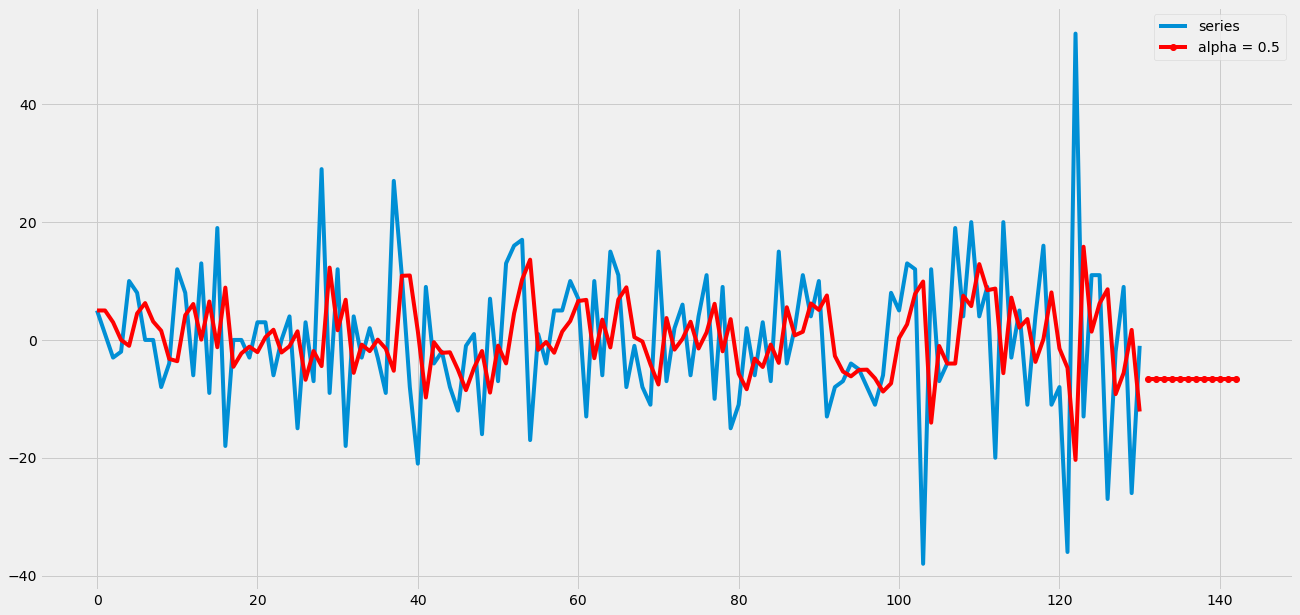

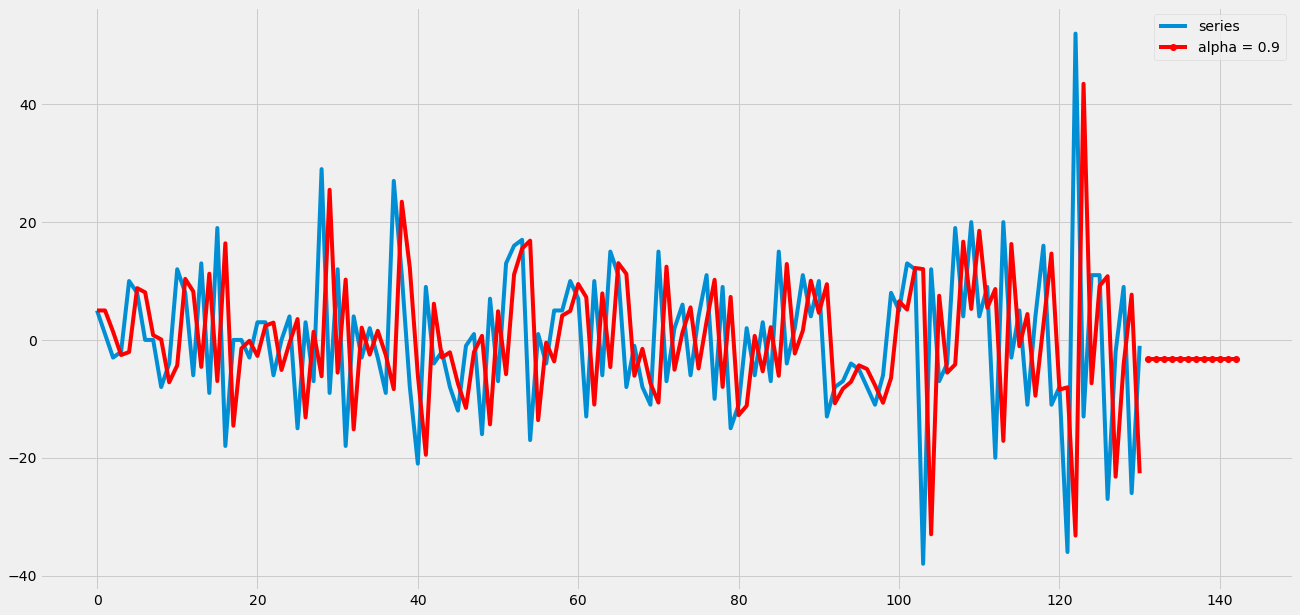

In [ ]:
for alpha_sm in [0.2 , 0.5, 0.9]:

    df = pd.read_csv(CFG.data_folder + 'exp1.csv', header = None); df.columns = ['series']
    df.plot.line()
    fit1 = SimpleExpSmoothing(df).fit(smoothing_level = alpha_sm  ,optimized=False)
    fcast1 = fit1.forecast(12).rename('alpha = ' + str(alpha_sm))
    fcast1.plot(marker='o', color='red', legend=True)
    fit1.fittedvalues.plot(  color='red')
    plt.show()

As you can see from the graphs above, the for small values of the smoothing constant $\alpha$ most of the variation has been removed and we have a series following just the general trend; on the other hand, high value of the $\alpha$ parameter results in hardly any smoothing at all and the new series follows the original very closely (albeit with a delay, which is obvious given the relationship between raw and smoothed values).


**Pro tip**: anytime you are using exponential smoothing that you did not write yourself, double-check the parametrization - does small $\alpha$ mean heavy smoothing or hardly any at all? The idea that the coefficient closer to 1 means less smoothing is merely a convention.


What happens if we apply the method to the passengers dataset, first introduced in [part 1](https://www.kaggle.com/konradb/practical-time-series-part-1-the-basics) ?

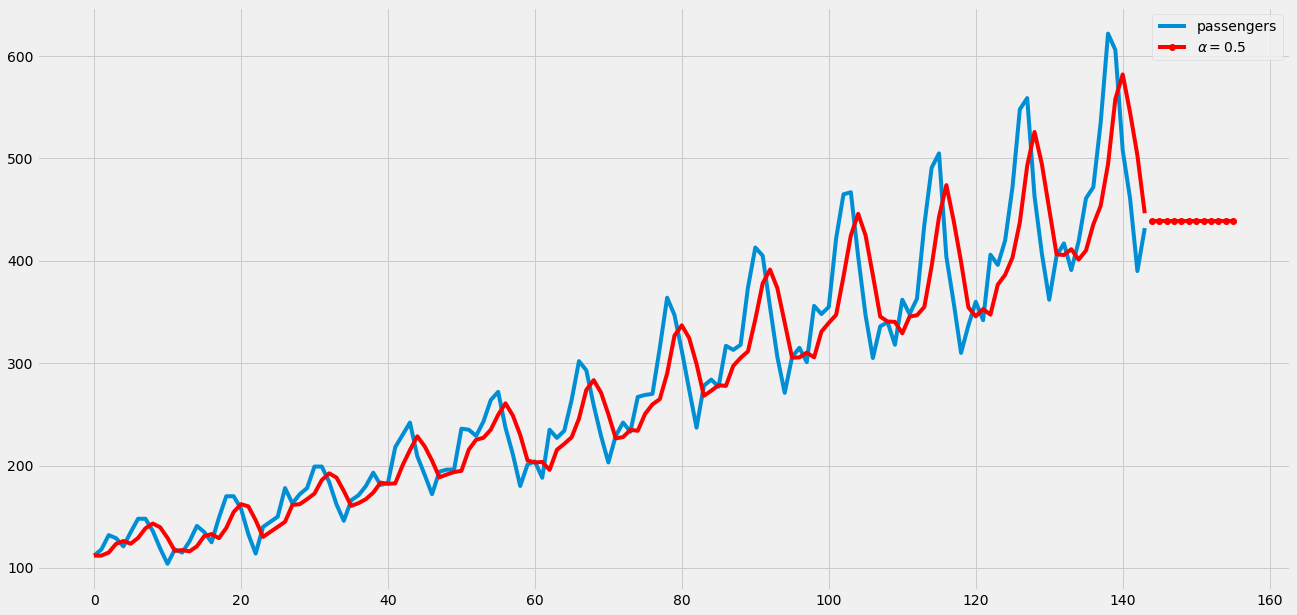

In [ ]:
alpha = 0.5

df = pd.read_csv(CFG.data_folder + 'passengers.csv', usecols = ['passengers'])
df.plot.line()
fit1 = SimpleExpSmoothing(df).fit(smoothing_level= alpha,optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.5$')
fcast1.plot(marker='o', color='red', legend=True)
fit1.fittedvalues.plot(  color='red')
plt.show()

On the one hand, the model does exactly what we expect it to do: beyond the range of the original data, it propagates the most recent smoothed value. On the other hand - it is not, to put it mildly, realistic to expect the number of passengers to flatline and the trend to disappear.

## Double Exponential Smoothing

Moving towards double exponential smoothing is akin to taking one more component in the seasonal decomposition: we began with level only, and we take into account the trend as well. We have learnt to predict intercept with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes.  Double exponential smoothing, a.k.a. the Holt method is defined by the relationship:

\begin{equation}
S_t = \alpha X_t + (1 - \alpha) (S_{t-1} + b_{t-1})\\
b_t = \beta (S_t - S_{t-1}) + (1- \beta) b_{t-1}
\end{equation}

where $S_1 = X_1$, $\quad b_1 = X_1 - X_0$ and $\alpha, \beta \in (0,1)$

The first equation describes the intercept, which depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. Complete prediction is composed of the sum of level and trend and the difference with simple exponential smoothing is that we need a second parameter to smooth the trend - as before, those can be set based on expert judgement or estimated (jointly) from the data. 

The forecast $h$ steps ahead is defined by
\begin{equation}
\hat{X}_{t+h} = S_t + h b_t
\end{equation}

The forecast function is no longer flat but trending: $h$-step-ahead forecast is equal to the last estimated level plus $h$ times the last estimated trend value.

Let's compare the performance of the two methods on the passenger dataset:

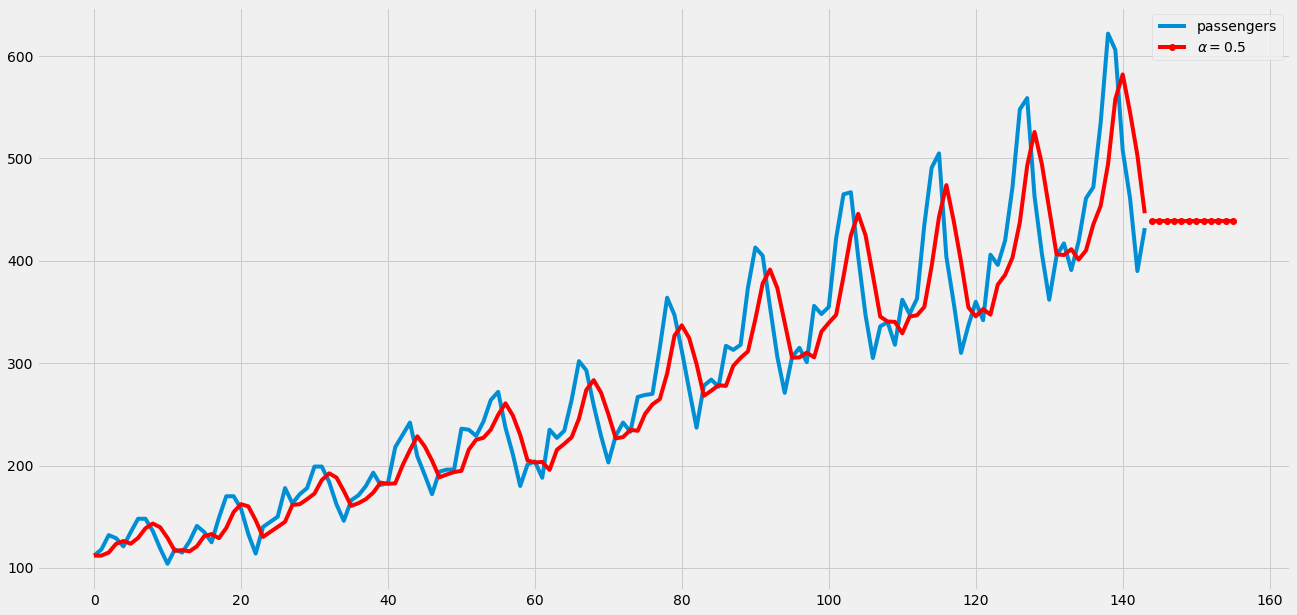

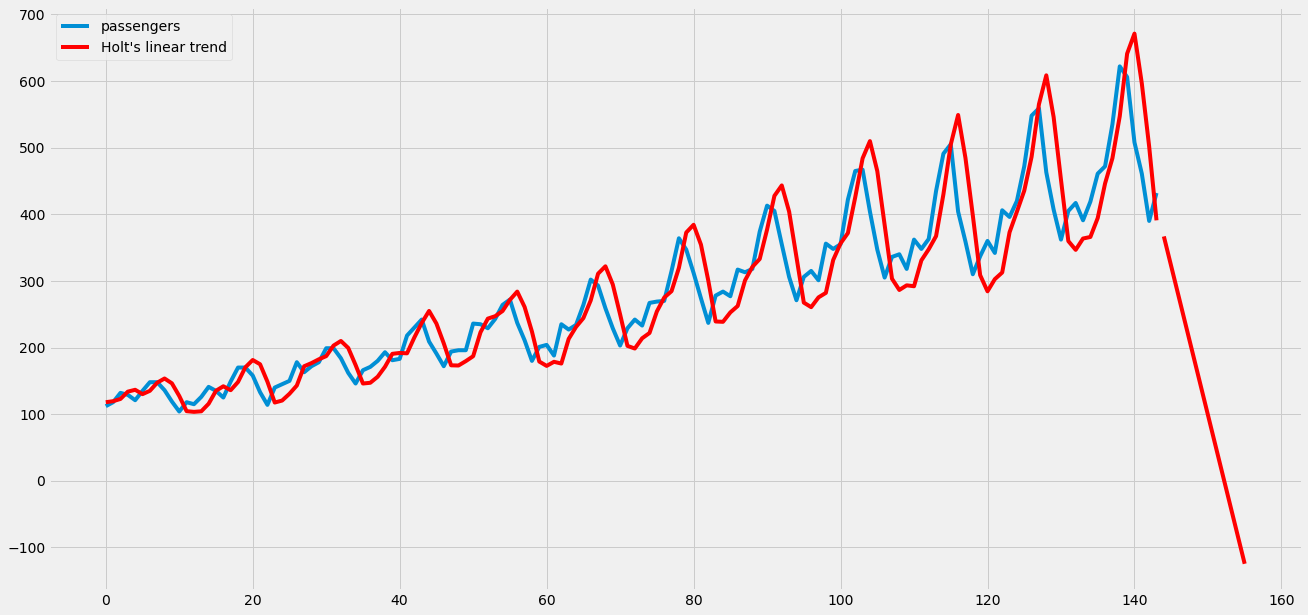

In [ ]:
alpha = 0.5
df = pd.read_csv(CFG.data_folder + 'passengers.csv', usecols = ['passengers'])
df.plot.line()
fit1 = SimpleExpSmoothing(df).fit(smoothing_level= alpha,optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.5$')
fcast1.plot(marker='o', color='red', legend=True)
fit1.fittedvalues.plot(  color='red')
plt.show()

df.plot.line()

fit1 = Holt(df).fit(smoothing_level=0.5, smoothing_slope=0.5, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")
fit1.fittedvalues.plot(color='red')
fcast1.plot(color='red', legend=True)

plt.show()

It seems like we are moving in the right direction - the forecast going forward is not constant, but follows a trend. However, it is simply an extrapolation of the most recent (smoothed) trend in the data which means we can expect the forecast to turn negative shortly. This is suspicious in general, and clearly renders the forecast unusable in the domain context.

## Triple Exponential Smoothing

If it worked once, maybe it can work twice? A natural extension is to introduce a smoothed seasonal component: triple exponential smoothing, a.k.a. Holt-Winters, is defined by:

\begin{equation}
S_t = \alpha (X_t - c_{t - L}) + (1 - \alpha) (S_{t-1} + b_{t-1}) \\
\end{equation}

\begin{equation}
b_t = \beta (S_t - S_{t-1}) + (1- \beta) b_{t-1} \\
\end{equation}

\begin{equation}
c_t = \gamma (X_t - S_{t-1} - b_{t-1})+ (1 - \gamma) c_{t-L}
\end{equation}

with $\alpha, \beta, \gamma \in (0,1)$.

The most important addition is the seasonal component to explain repeated variations around intercept and trend, and it will be specified by the period. For each observation in the season, there is a separate component; for example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components, one for each day of the week. An obvious, yet worth repeating caveat: it makes sense to estimate seasonality with period $L$ only if your sample size is bigger than $2L$. 

The forecast $h$ steps ahead is defined by
\begin{equation}
\hat{X}_{t+h} = S_t + h b_t + c_{(t-L + h) \;\; mod \;\;  L }
\end{equation}

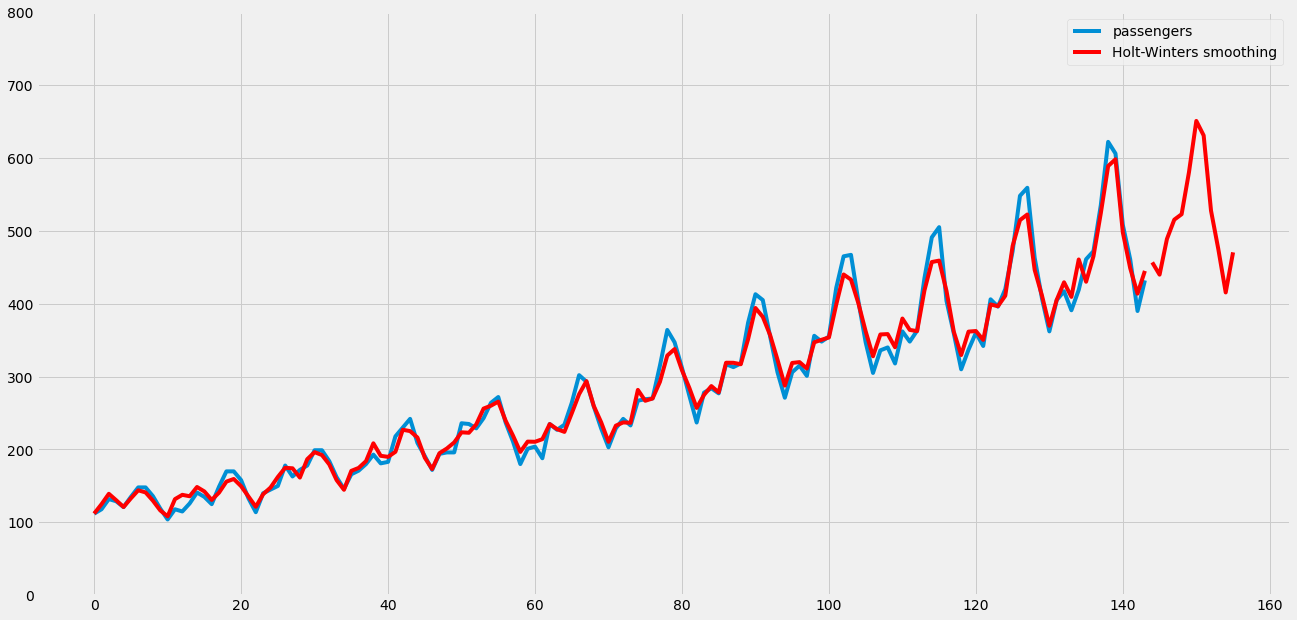

In [ ]:
alpha = 0.5
df = pd.read_csv(CFG.data_folder + 'passengers.csv', usecols = ['passengers'])
df.plot.line()
fit1 = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='add')
fit1 = fit1.fit(smoothing_level=0.5)   #,use_boxcox=True
fit1.fittedvalues.plot(color='red')
fit1.forecast(12).rename("Holt-Winters smoothing").plot(color='red', legend=True)

plt.ylim(0, 800); plt.show()

Clearly, incorporating both the trend and seasonality explicitly leads to a much higher quality forecast.

## Taxonomy


We conclude that part by discussing briefly the taxonomy of smoothing models following "Forecasting: Principles and Practice"
by Hyndman and Athanasopoulos, chapter 7 (where the table below is taken from): the ones discussed above are the most popular ones, but not the only ones possible. By considering variations in the combinations of the trend and seasonal components, nine exponential smoothing methods are possible: each method is labelled by a pair of letters (T,S) defining the type of ‘Trend’ and ‘Seasonal’ components. For example, (A,M) is the method with an additive trend and multiplicative seasonality; (Ad ,N) is the method with damped trend and no seasonality; and so on.


Some of these methods we have already seen using other names:
* (N,N) is simple exponential smoothing
* (A,N) is Holt's linear trend method
* (A,A) corresponds to additive Holt-Winters method

If you have some time on your hands, implementing some other methods might be a good exercise - but the word "practical" is there for a reason in the title, so we focus on using tools available out of the box - and understanding what we're doing.

<a id="section-three"></a>
# Anomaly detection

Anomaly detection is a process for identifying unexpected data, event or behavior that require some examination. It is a well-established field within data science and there is a large number of algorithms to detect anomalies in a dataset depending on data type and business context. One of the simplest, yet surprisingly effective ones, is a Z-score. The basic idea is that after suitable normalization, most kinds of data starts behaving like a Gaussian distribution (look up Central Limit Theorem if you would like to understand why) - which implies we only need mean and standard deviation to assess if a given observation is an outlier. Keep in mind that this approach is not 100pct foolproof: there are practical situations when CLT does not work (there's a reason it has a list of assumptions :-) and the Z score will not be meaningful in such circumstances; it does not happen very often, but it is not impossible.


The calculation of the Z-score for each individual point in the series proceeds in the following manner:
* select a window size $w$
* calculate rolling mean / standard deviation with window $w$
* demean and normalize by sd:
\begin{equation}
Z_t = \left|\frac{X_t - \bar{X}_m}{\sigma_m} \right|
\end{equation}

* Z-score measures number of sd away from mean $\implies$ values above 3 indicate extremely unlikely realization

<AxesSubplot:>

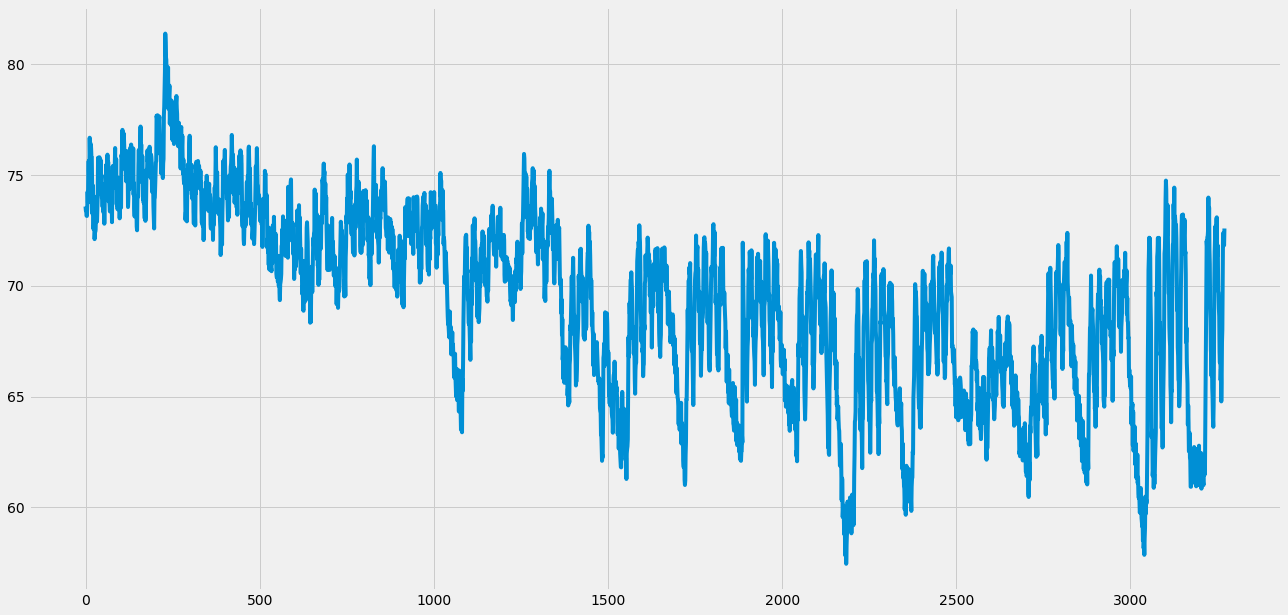

In [ ]:
# load 
series = pd.read_csv(CFG.data_folder + 'ambient_temperature_system_failure.csv')
series['timestamp'] = pd.to_datetime(series['timestamp'])

# plot 
series['value'].plot()

<AxesSubplot:>

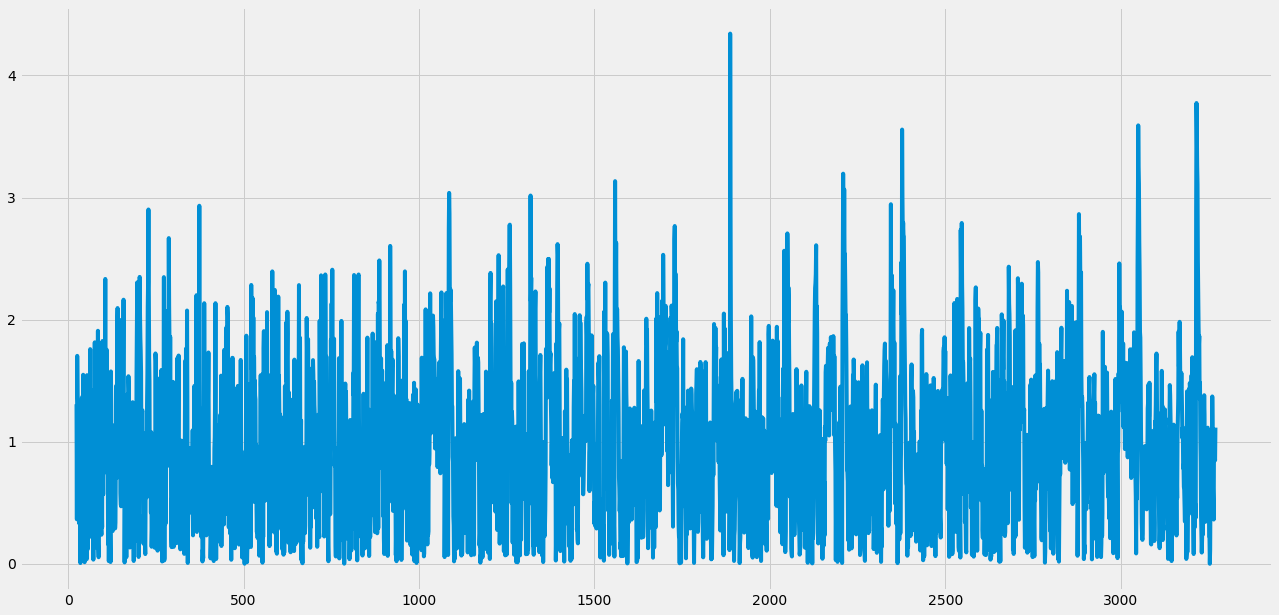

In [ ]:
# pick a window size 
window_size = 25

# calculate rolling mean and standard deviation
xroll = series['value'].rolling(window_size)
series['mean_roll'] = xroll.mean()
series['sd_roll'] = xroll.std()

# calculate the Z-score
series['zscore'] = np.abs( (series['value'] - series['mean_roll']) / series['sd_roll'])
series['zscore'].plot()

In [ ]:
# check which observations are out of range
series.loc[series['zscore'] > 3][['timestamp', 'value']]

timestamp      value
1086 2014-02-17 13:00:00  69.519207
1318 2014-02-27 05:00:00  69.425502
1559 2014-03-10 11:00:00  67.688348
1887 2014-03-24 19:00:00  71.943363
2209 2014-04-14 10:00:00  63.873030
2212 2014-04-14 13:00:00  66.890486
2377 2014-04-21 10:00:00  64.916813
2378 2014-04-21 11:00:00  65.396986
3050 2014-05-19 11:00:00  66.461085
3051 2014-05-19 12:00:00  68.261759
3052 2014-05-19 13:00:00  70.711580
3216 2014-05-26 09:00:00  66.161356
3217 2014-05-26 10:00:00  68.072276
3218 2014-05-26 11:00:00  69.817993
3219 2014-05-26 12:00:00  72.026925

# Putting it all together

Now that we have all the pieces prepared, we can combine them to build a predictive model. We will use the dataset on daily US energy consumption (in billion kWh)

<AxesSubplot:xlabel='date'>

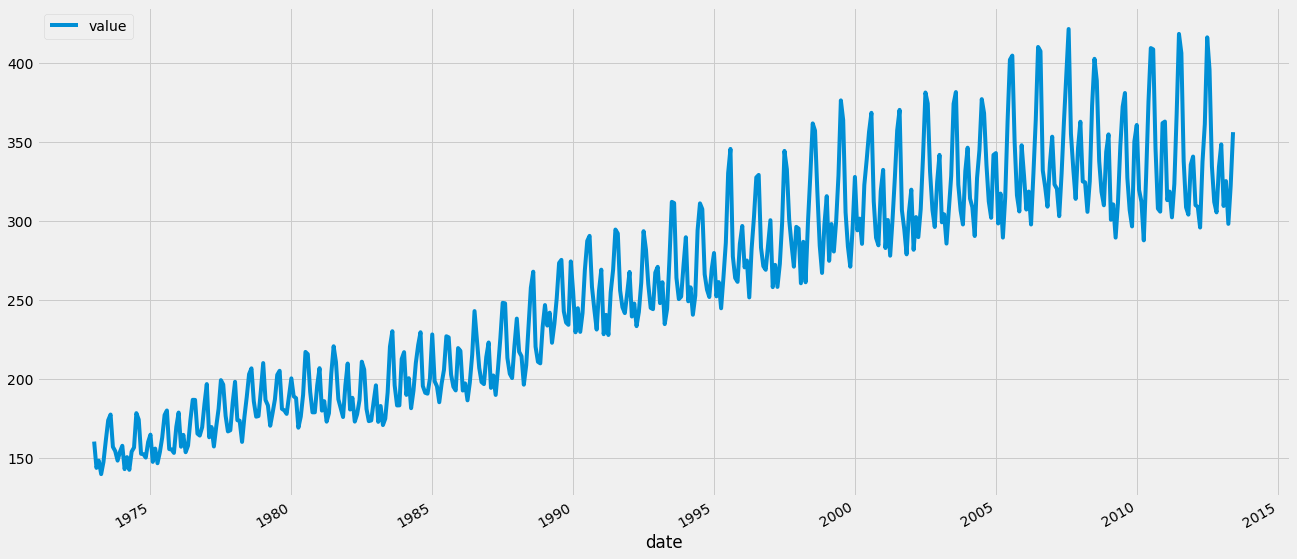

In [ ]:

df = pd.read_csv(CFG.data_folder + 'us_energy.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)
df.plot()

Let's start with a seasonal decomposition (introduced in [part 1](https://www.kaggle.com/konradb/practical-time-series-part-1-the-basics)) to get a basic understanding of the dynamics:

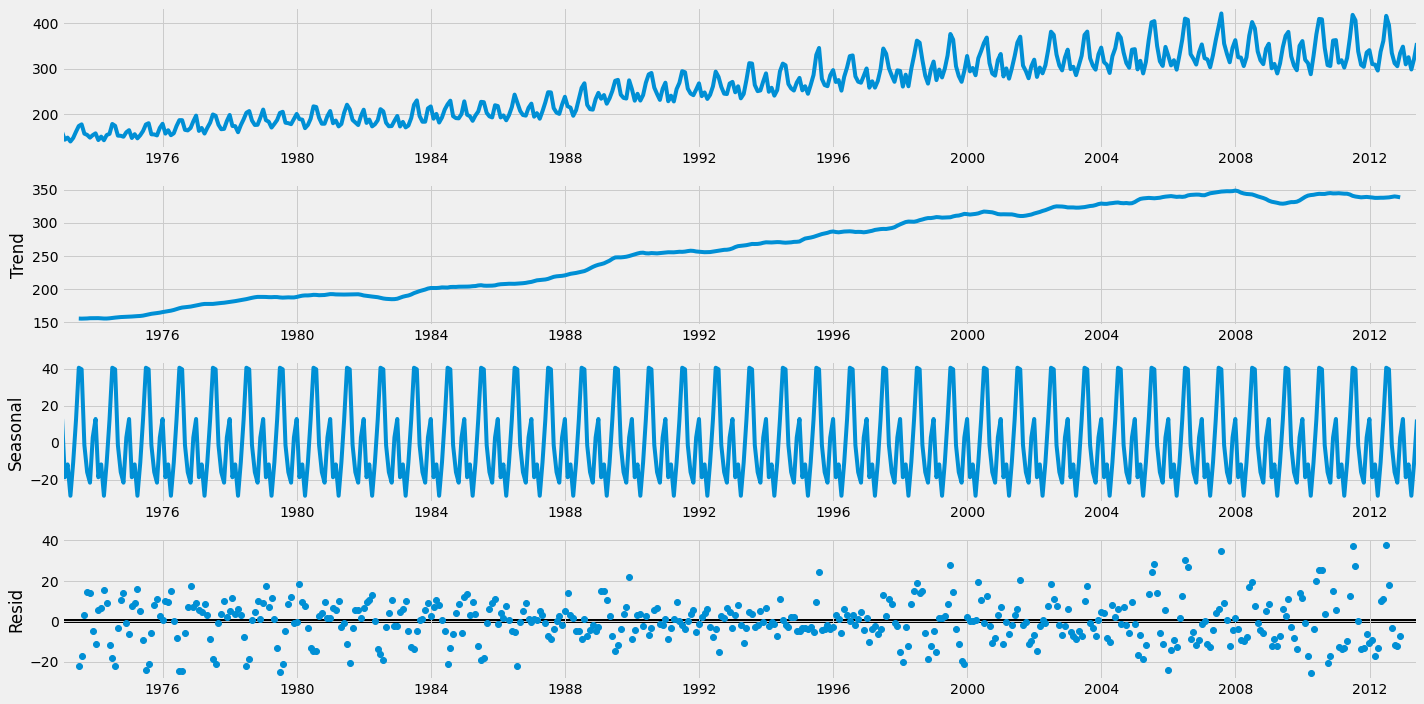

In [ ]:
# perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(df,period =12) 
figure = decomposition.plot()
plt.show()

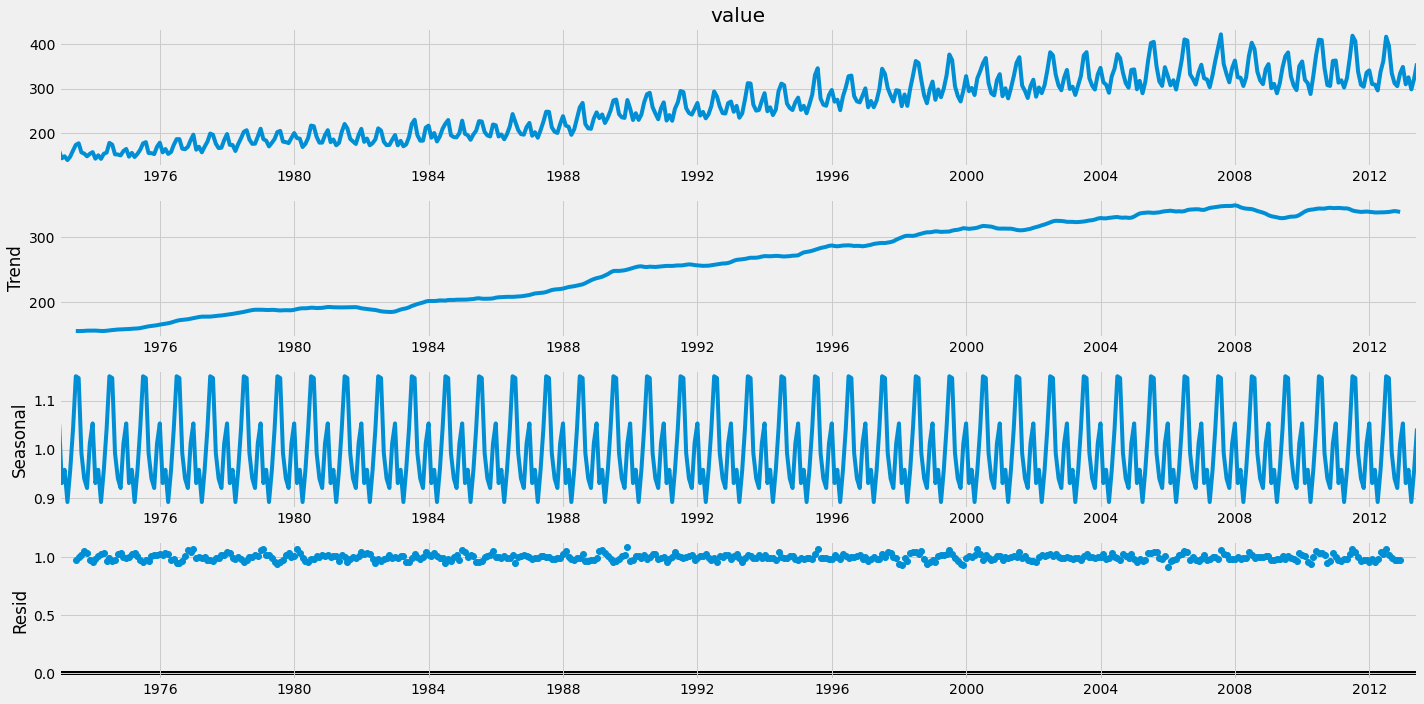

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df["value"],period =12, model = 'multiplicative')
figure = decomposition.plot()
plt.show()

Comparison of the two graphs above shows a few things:
* there is definitely a trend in the data
* we have a clear seasonal pattern
* more stable behavior of the residuals in the second case suggests that a multiplicative decomposition is more appropriate.

Next step: we split the data into training and validation. Our cutoff point will be 2005:

In [ ]:
cutoff_date = '2005-12-31'
xtrain, xvalid  = df.loc[df.index <= cutoff_date], df.loc[df.index > cutoff_date]
print(xtrain.shape, xvalid.shape)

(397, 1) (89, 1)


We can fit hte model now:

In [ ]:
fit1 = ExponentialSmoothing(xtrain['value'].values, seasonal_periods=12, trend='mul', seasonal='mul')
fit1 = fit1.fit()   #use_boxcox=True

C:\Users\Bharat Anand\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Examining the parameters is fairly straightforward - as you can see, we did not specify the values of the smoothing constants, so they were automatically estimated.

In [ ]:
fit1.params_formatted

name         param  optimized
smoothing_level     alpha  2.817852e-01       True
smoothing_trend      beta  1.870728e-09       True
smoothing_seasonal  gamma  2.263622e-01       True
initial_level         l.0  1.347829e+02       True
initial_trend         b.0  1.001948e+00       True
initial_seasons.0     s.0  1.202624e+00       True
initial_seasons.1     s.1  1.059306e+00       True
initial_seasons.2     s.2  1.087791e+00       True
initial_seasons.3     s.3  1.010855e+00       True
initial_seasons.4     s.4  1.067453e+00       True
initial_seasons.5     s.5  1.139532e+00       True
initial_seasons.6     s.6  1.246174e+00       True
initial_seasons.7     s.7  1.244666e+00       True
initial_seasons.8     s.8  1.094523e+00       True
initial_seasons.9     s.9  1.074090e+00       True
initial_seasons.10   s.10  1.068897e+00       True
initial_seasons.11   s.11  1.153960e+00       True

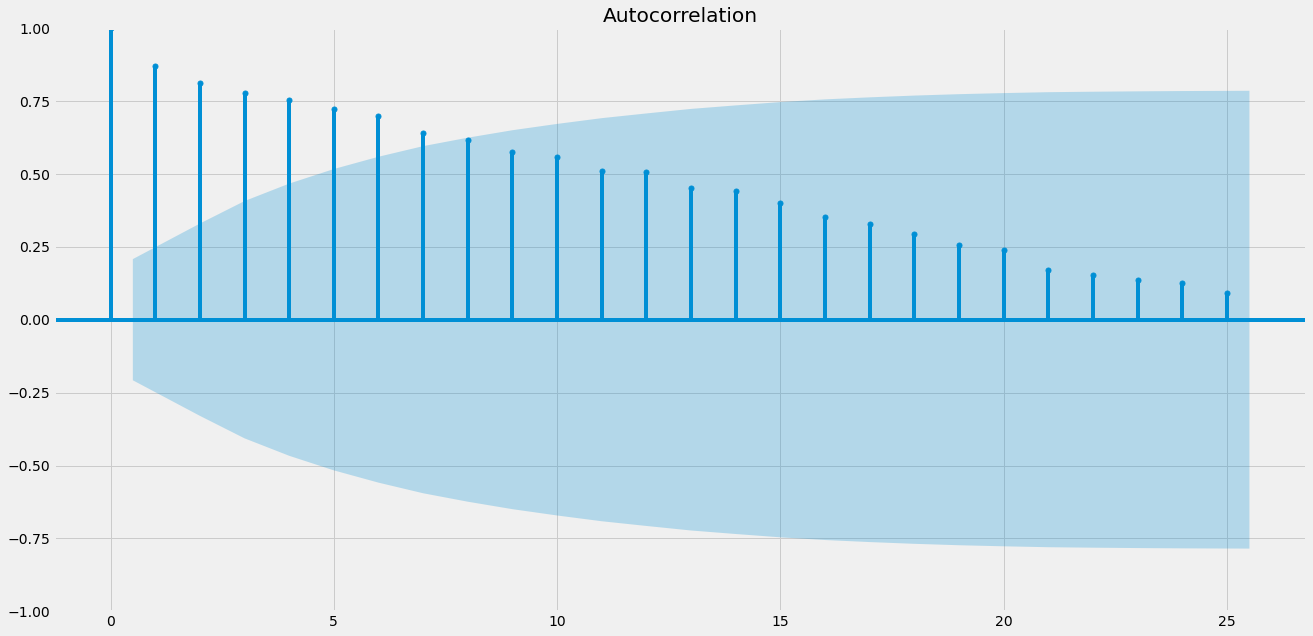

In [ ]:
# What do the residuals look like?
prediction = fit1.forecast(len(xvalid)).copy()

xresiduals = xvalid['value'] - prediction
plot_acf(xresiduals, lags = 25)
print()

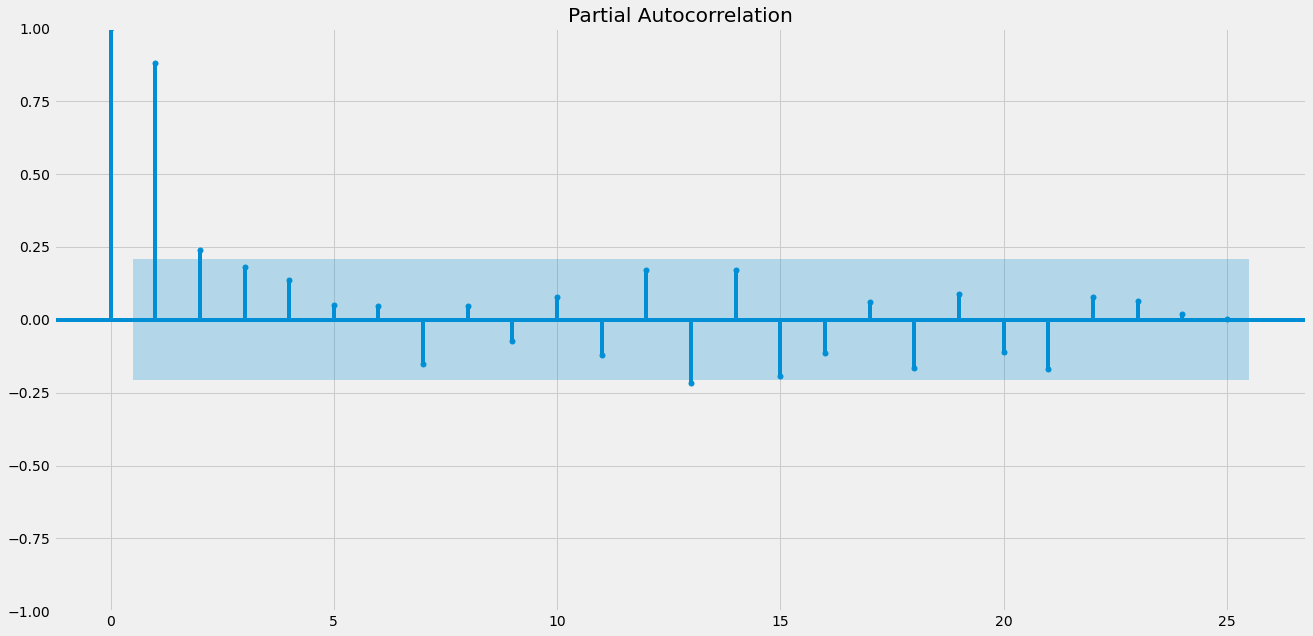

In [ ]:
plot_pacf(xresiduals, lags = 25)
print()

The behavior of ACF / PACF (statistically significant autocorrelations) suggests that there is some first- and second-order dependence that our Holt-Winter model cannot capture.

C:\Users\BHARAT~1\AppData\Local\Temp/ipykernel_30404/1441854185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xvalid['prediction'] = prediction


<AxesSubplot:xlabel='date'>

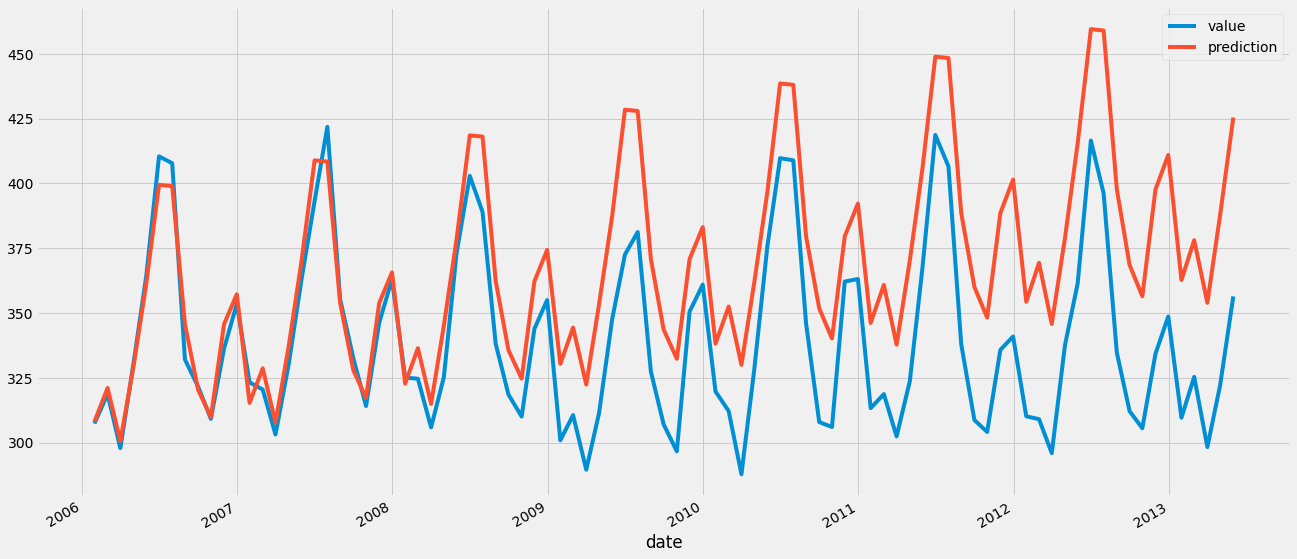

In [ ]:

xvalid['prediction'] = prediction
xvalid.plot()

As you can see from the graph above, the model is doing a decent job for the first few years in the sample, but starts to overestimate the consumption afterwards - indicating perhaps a change in the nature of the trend (which would be consistent with the ACF pattern above). This confirms the intuition that there are aspects of the data generating process that are not adequately captured by our three prameter model - but for something that simple, you can make a solid case it is acceptable.

**If you think this notebook deserves an upvote, I'd love to have it. An upvote per view, its all I ask**
(credit to [Dan Carlin](https://twitter.com/HardcoreHistory) for coining the phrase ;-) 

---------------------------------------

This is part of a series of notebooks about practical time series methods:

* [Part 0: the basics](https://www.kaggle.com/konradb/ts-0-the-basics)
* [Part 1a: smoothing methods](https://www.kaggle.com/konradb/ts-1a-smoothing-methods) 
* [Part 1b: Prophet](https://www.kaggle.com/konradb/ts-1b-prophet) - **this notebook**
* [Part 2: ARMA](https://www.kaggle.com/konradb/ts-2-arma-and-friends)
* [Part 3: Time series for finance](https://www.kaggle.com/konradb/ts-3-time-series-for-finance) 
* [Part 4: Sales and demand forecasting](https://www.kaggle.com/konradb/ts-4-sales-and-demand-forecasting)
* [Part 5: Automatic for the people](https://www.kaggle.com/code/konradb/ts-5-automatic-for-the-people)
* [Part 6: Deep learning for TS - sequences](https://www.kaggle.com/konradb/ts-6-deep-learning-for-ts-sequences) 
* [Part 7: Survival analysis](https://www.kaggle.com/konradb/ts-7-survival-analysis) 
* [Part 8: Hierarchical time series](https://www.kaggle.com/code/konradb/ts-8-hierarchical-time-series)
* [Part 9: Hybrid methods](https://www.kaggle.com/code/konradb/ts-9-hybrid-methods/)
* [Part 10: Validation methods for time series](https://www.kaggle.com/code/konradb/ts-10-validation-methods-for-time-series/)
* [Part 11: Transfer learning](https://www.kaggle.com/code/konradb/ts-11-deep-learning-for-ts-transfer-learning)


The series is accompanied by video presentations on the YouTube channel of [Abhishek](https://www.kaggle.com/abhishek):

* [Talk 0](https://www.youtube.com/watch?v=cKzXOOtOXYY) 
* [Talk 1](https://www.youtube.com/watch?v=kAI67Sz92-s) - combining the content from parts 1a and 1b
* [Talk 2](https://www.youtube.com/watch?v=LjV5DE3KR-U) 
* [Talk 3](https://www.youtube.com/watch?v=74rDhJexmTg) 
* [Talk 4](https://www.youtube.com/watch?v=RdH8zd07u2E)
* [Talk 5](https://www.youtube.com/watch?v=wBP8Pc4Wxzs)
* [Talk 6](https://www.youtube.com/watch?v=81AEI0tj0Kk)
* [Talk 7](https://www.youtube.com/watch?v=m-8I_hkmz9o)
* [Talk 8](https://www.youtube.com/watch?v=7ZTarg4QYR4)
* [Talk 9](https://www.youtube.com/watch?v=NYZzBvKcfp4)
* [Talk 10](https://www.youtube.com/watch?v=47WeBiLV2Uo)
* [Talk 11]()


---------------------------------------


The notebook is split into sections: we discuss different elements of setting up a Prophet model, show how to evaluate its performance and demonstrate a pipeline putting all the elements together. 

* [Prophet](#section-one)
* [Trend](#section-two)
* [Seasonality](#section-three)
* [Special days](#section-four)
* [Performance evaluation](#section-five)
* [Full pipeline](#section-six)
* [Using covariates](#section-seven)
* [Neural Prophet](#section-eight)

As before, we begin by importing the required packages

In [ ]:
import itertools
import pandas as pd
import numpy as np
from random import gauss

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

import warnings
import itertools
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from dateutil.easter import easter
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_yearly, add_changepoints_to_plot

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

warnings.simplefilter(action='ignore', category= FutureWarning)

import plotly.graph_objs as go

<a id="section-one"></a>
# Prophet

While useful in practice, exponential smoothing can only handle one seasonal pattern at at time. Challenges like these led to the development of Prophet, which is a time series framework designed to work out of the box and developed by Core Data Science team at FB: https://research.facebook.com/research-areas/data-science/. The core idea is based around the structural decomposition:

\begin{equation}
X_t = T_t + S_t + H_t + \epsilon_t
\end{equation}

where
* $T_t$ : trend component
* $S_t$ : seasonal component (weekly, yearly)
* $H_t$ : deterministic irregular component (holidays)
* $\epsilon_t$: noise 

For the more scientifically among the readers, the original paper describing the approach can be found here: https://peerj.com/preprints/3190/.


We will discuss the Prophet style of modeling trend, seasonality and holidays in the sections below, but first a crash intro to the theory behind the models. 

## Generalized Additive Models (GAM)

The core mathematical idea behind Prophet is the Kolmogorov-Arnold representation theorem, which states that multivariate function could be represented as sums and compositions of univariate functions:

\begin{equation} 
    {\displaystyle f({x_1, \ldots, x_n})=\sum _{q=0}^{2n}\Phi _{q}\left(\sum _{p=1}^{n}\phi _{q,p}(x_{p})\right)}
\end{equation}

The theorem has no constructive proof suitable for modeling $\implies$ simplification is necessary: 

\begin{equation}
{\displaystyle f({x_1, \ldots, x_n})=\Phi \left(\sum _{p=1}^{n}\phi _{p}(x_{p})\right)}
\end{equation}
where $\Phi$ is a smooth monotonic function. This equation gives a general representation of GAM models and a familiar variant of this approach is the class of Generalized Linear Models :

\begin{equation}
\Phi^{-1}\left[\operatorname {E}(Y)\right]=\beta _{0}+f_{1}(x_{1})+f_{2}(x_{2})+\cdots +f_{m}(x_{m}).\,\!
\end{equation}

The smooth functions in the context of Prophet are the trend, seasonal and holiday components - we can isolate each individual function and evaluate its effect in prediction, which makes such models easier to interpret. we estimate through backfitting algorithm $\rightarrow$ convergence

## The prophetic core

So how does that work in practice? We take a GAM-style decomposition as our starting point:

\begin{equation}
X_t = T(t) + S(t) + H(t) + \epsilon_t
\end{equation}

Unpacking the equation: 

* time is the only regressor

* easy accomodation of new components

* multiple seasonal patterns $\rightarrow$ extension of double exponential smoothing

* forecasting $\rightarrow$ curve fitting

* no need for regular spacing $\implies$ no NA filling

* fast fitting with backfitting algorithm https://en.wikipedia.org/wiki/Backfitting_algorithm

* probabilistic aspects - Hamiltonian Monte Carlo (which is why Windows have an extra step of Stan installation - but trust me, it's worth it)

* works in more general cases, but "designed" for daily data



Below we discuss each of the components in its own section.

<a id="section-two"></a>
# Trend model

The Prophet library implements two possible trend models.


## Linear Trend

The first, default trend model is a simple Piecewise Linear Model with a constant rate of growth. It is best suited for problems without saturating growth and takes advantage of the fact that a broad class of shapes can be approximated by a piecewise linear function.

\begin{equation}
T(t) = \left[k + a(t)^T \delta \right]t + \left[m + a(t)^T \gamma\right]
\end{equation}

By default, Prophet estimates 25 changepoints in the model, over 80pct of the dataset (those parameters can be adjusted). Changepoints are defined as changes in the trajectory, which can be esimated or provided manually - the latter is a useful option if domain knowledge is available to the analyst.


We demonstrate this functionality by using New York Times data on Covid cases: https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv

<AxesSubplot:>

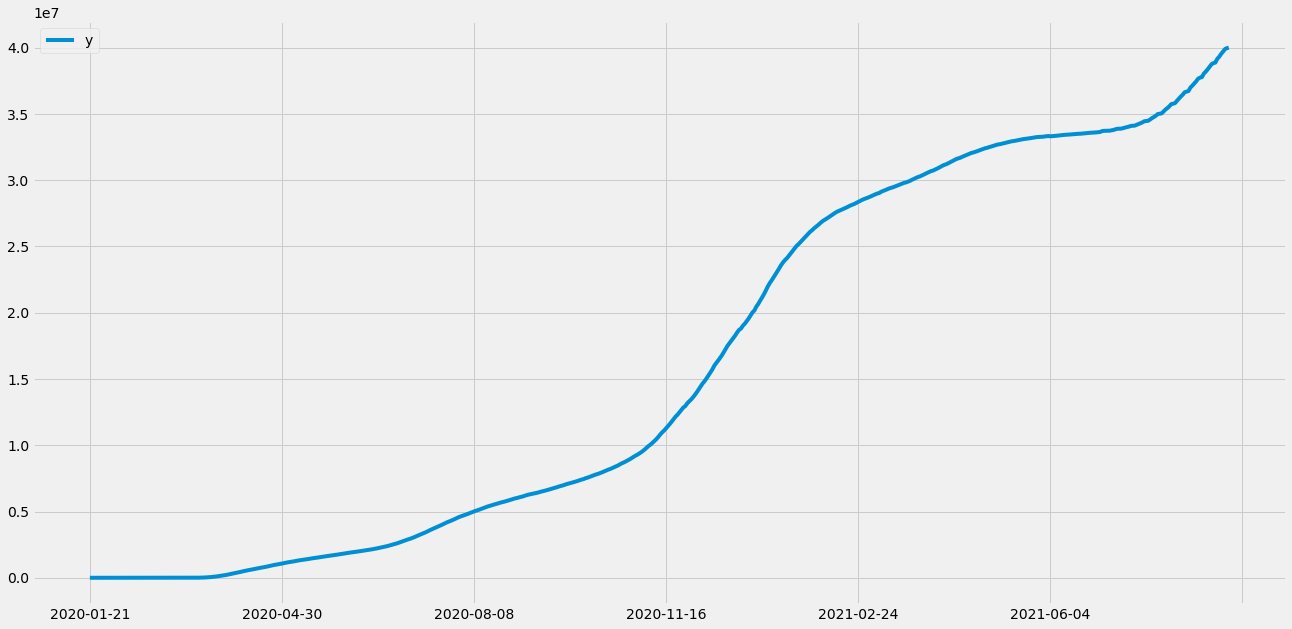

In [ ]:
df = pd.read_csv(CFG.data_folder + 'us_covid.csv')
df.head(10)


# Prophet does have a quirk: a hardcoded format for the input time series - it must consist of a date column named 'ds' (dataframe index or an actual column) and column 'y', where the actual values of the time series are stored
xdat = df[['date', 'cases']].rename(columns={"date": "ds", "cases": "y"})
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')

17:32:55 - cmdstanpy - INFO - Chain [1] start processing
17:32:56 - cmdstanpy - INFO - Chain [1] done processing


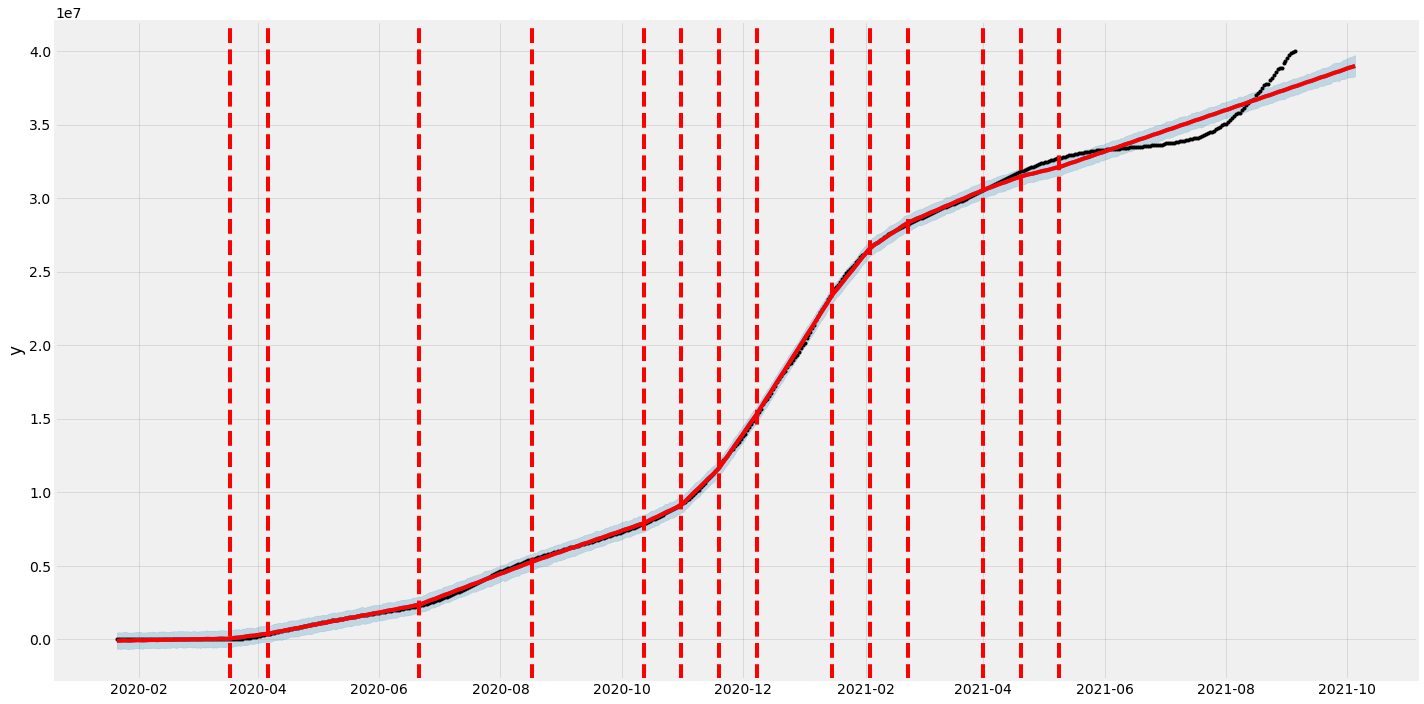

In [ ]:
# automatic detection of changepoints
m = Prophet()
m.fit(xdat)
future = m.make_future_dataframe(periods= 30)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
a = add_changepoints_to_plot(fig.gca(), m, forecast)

It seems like the default settings are on the generous side when it comes to assigning changepoints - we can control this behavior by enforcing more regularization. This is achieved by shrinking the `changepoint_prior_scale` parameter:

17:32:59 - cmdstanpy - INFO - Chain [1] start processing
17:32:59 - cmdstanpy - INFO - Chain [1] done processing


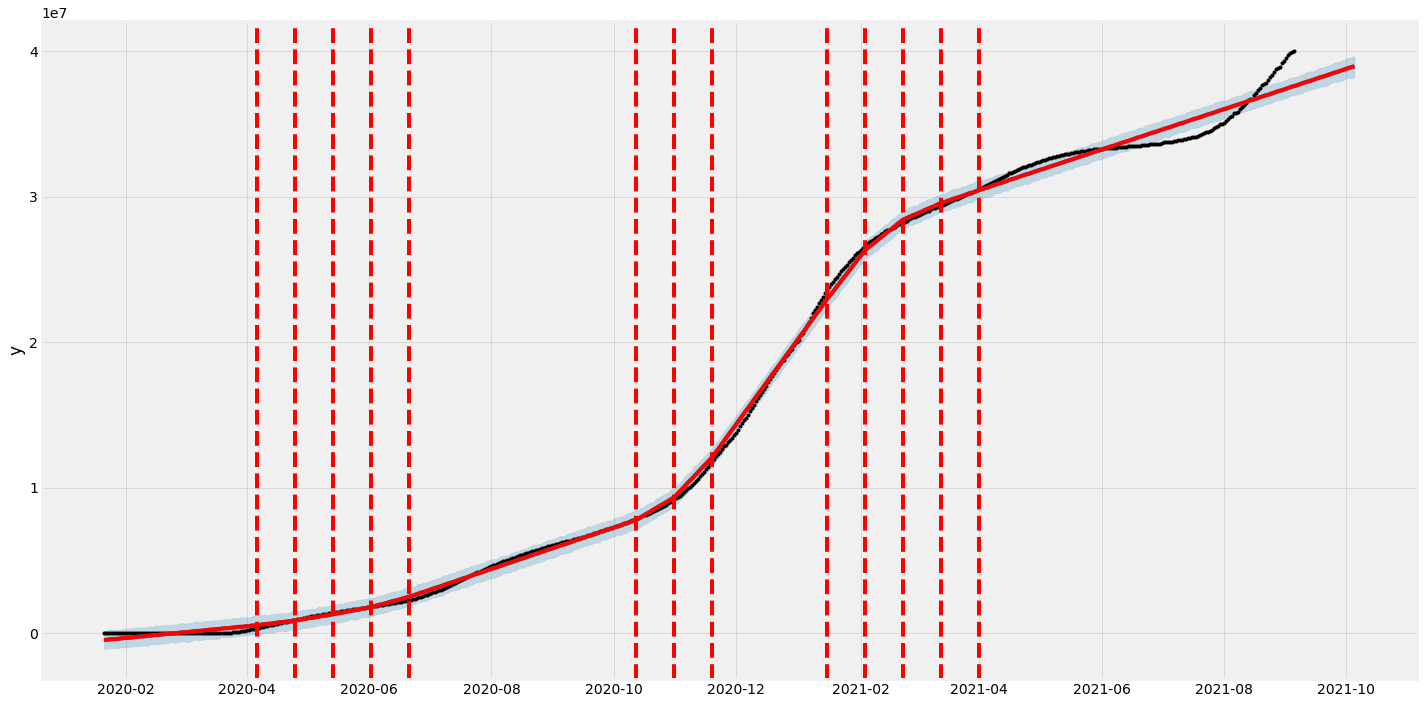

In [ ]:
m = Prophet(changepoint_prior_scale = 0.01)
m.fit(xdat)
future = m.make_future_dataframe(periods= 30)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
a = add_changepoints_to_plot(fig.gca(), m, forecast)


## Nonlinear growth 

The first one is called Nonlinear, Saturating Growth. It is represented in the form of the logistic growth model:
    
\begin{equation}
T(t) = \frac{C}{1 + exp(-k(t-m))}
\end{equation}

where $C$ is the carrying capacity (maximum value) and $k$ is the growth rate ("steepness" of the trend curve). $C$ and $k$ can be constant or time-varying. This logistic equation allows modelling non-linear growth with saturation, that is when the growth rate of a value decreases with its growth. Prophet supports both automatic and manual tuning of their variability. The library can itself choose optimal points of trend changes by fitting the supplied historical data.

Sticking with the theme that has dominated everybody's life from 2020, we will use data on Covid-19 cases in China.

<AxesSubplot:>

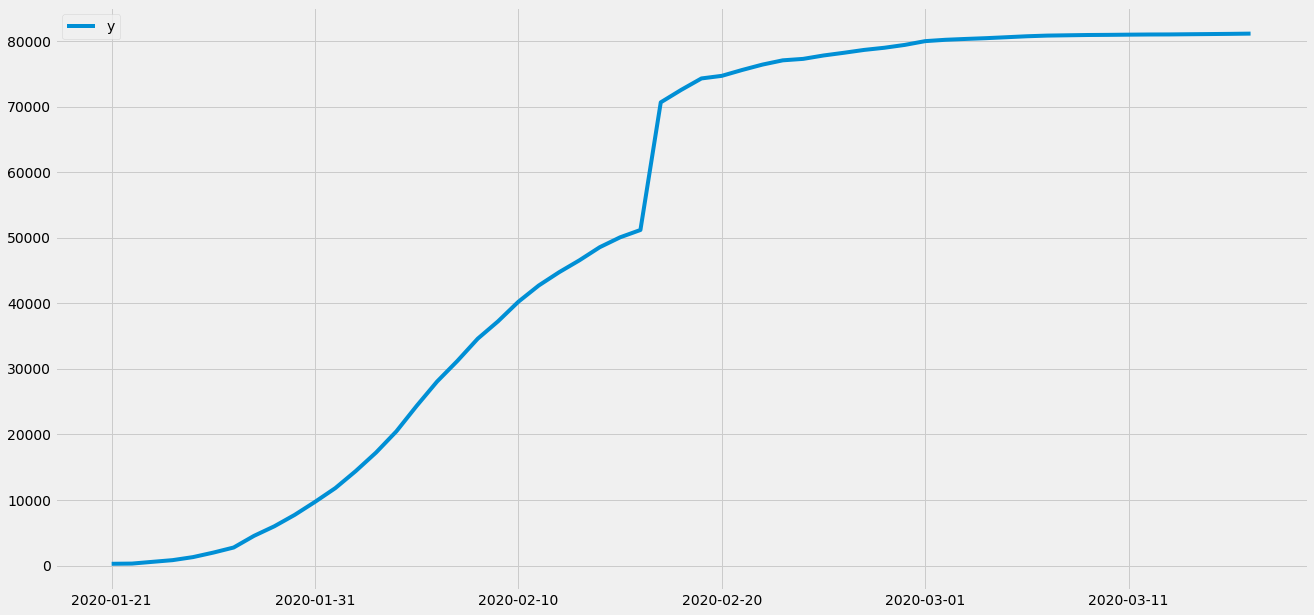

In [ ]:
df = pd.read_csv('./input/WHO_full_data2003.csv')
# subset the data and rename the columns to Prophet naming convention
df = df.loc[df['location'] == 'China'][['date', 'total_cases']].rename(columns={"date": "ds", "total_cases": "y"})
df.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')

We can see the curve flatlining somewhat - in Prophet we can incorporate such knowledge into the model by setting a cap (an upper limit on the forecast value):

17:33:07 - cmdstanpy - INFO - Chain [1] start processing
17:33:07 - cmdstanpy - INFO - Chain [1] done processing


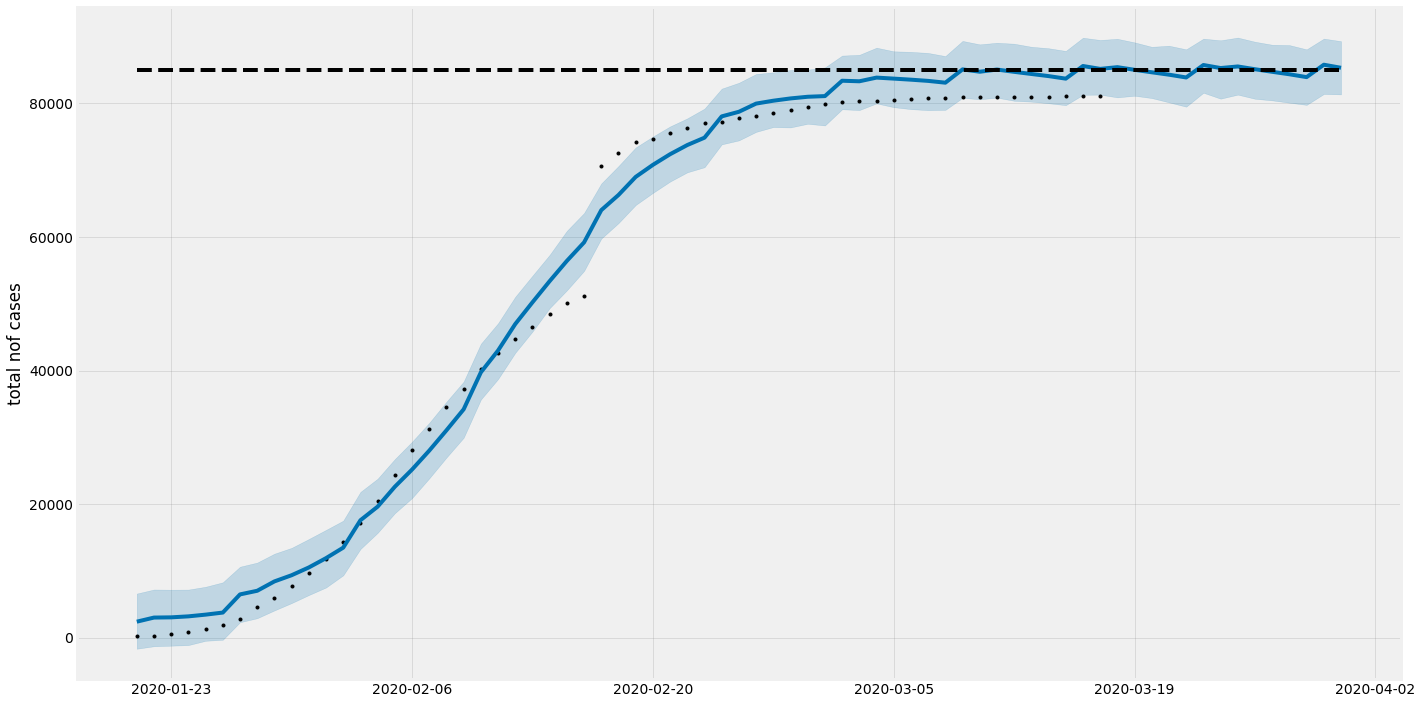

In [ ]:
# add the cap to the 
df['cap'] = 85000
# fit the model
m = Prophet(growth='logistic')
m.fit(df)
# prediction
future = m.make_future_dataframe(periods= 14)
future['cap'] = 85000

# plot the results
fcst = m.predict(future)
fig = m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total nof cases')

The approach is symmetrics, i.e. we can limit the series from below as well (contrived as it might seem in this particular application ;-)

17:33:11 - cmdstanpy - INFO - Chain [1] start processing
17:33:12 - cmdstanpy - INFO - Chain [1] done processing


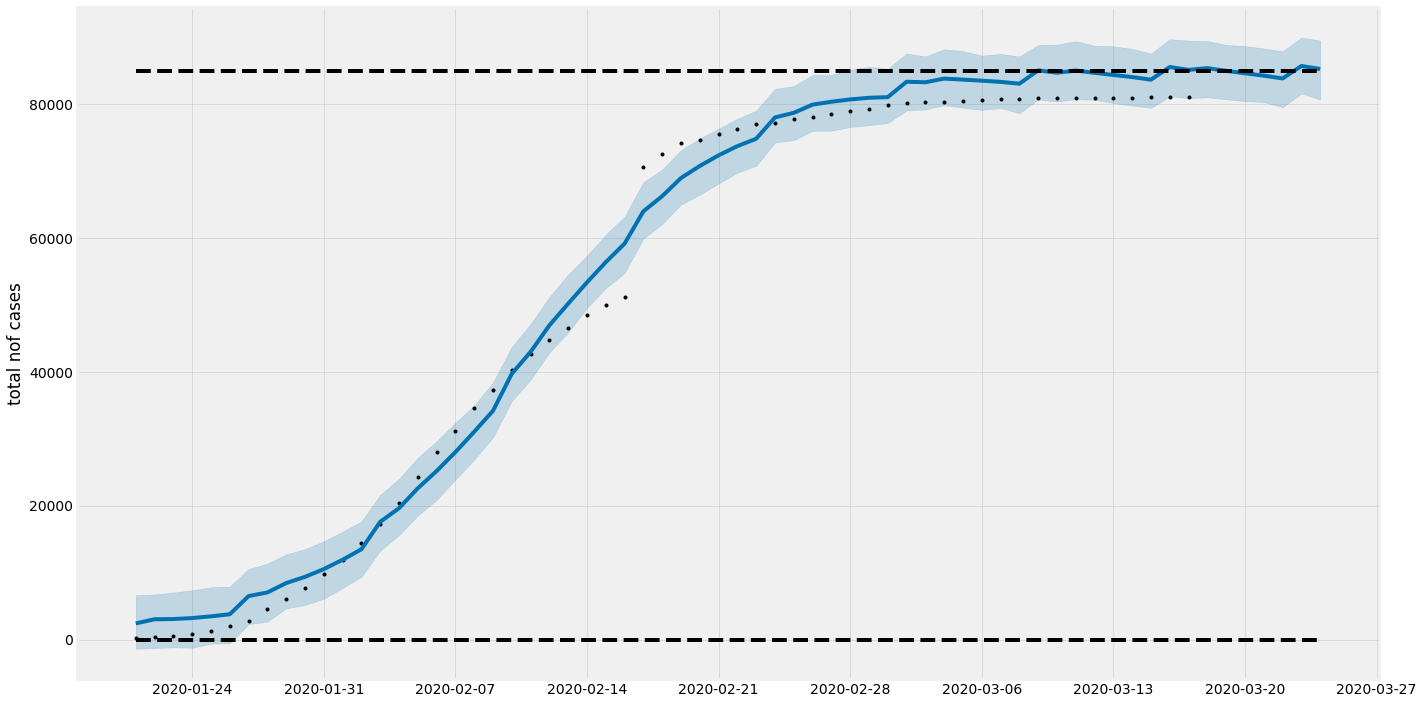

In [ ]:
# set the upper & lower limit for the forecast
df['cap'] = 85000
df['floor'] = 0

# fit a model
m = Prophet(growth='logistic')
m.fit(df)

# predict
future = m.make_future_dataframe(periods= 7)
future['cap'] = 85000
future['floor'] = 0
fcst = m.predict(future)

m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total nof cases')
print()

<a id="section-three"></a>
# Seasonality

When dealing with data in practical applications, it is frequently necessary to take into account multiple seasonal patterns occurring in parallel; a classic example would be data related to energy consumption: there are morning vs evening patterns (intraday), workdays vs weekend (weekly) and during the year (annual). Modeling them explicitly tends to be cumbersome (you need to add more equations in exponential smoothing or introduce dummies in ARIMA), which is one of the issues Prophet was designed to overcome. The core of the underlying logic is a the Fourier expansion:
    
\begin{equation}
    S(t) = \sum_{i=1}^N \left(a_n cos\left(\frac{2\pi i t}{P} \right) + b_n sin\left(\frac{2 \pi i t}{P} \right) \right)
\end{equation}

Unpacking this formula: 

* `sin` and `cos` function form an orthogonal basis https://en.wikipedia.org/wiki/Orthogonal_functions#Trigonometric_functions
* this means that every function can be represented as a combination as in the equation defined above - recall that in the GAM setup we treat time as the only regressor, so a time series can be viewed as a function of time $S(t)$ 
* by cutting off the expansion for a certain $N$ we can remove high frequency oscillations $\rightarrow$ low pass filter

## Frequency shenanigans

Let us briefly explore how you can specify different seasonality patterns: we will use the energy consumption data from PJM Interconnection LLC (PJM) - a regional transmission organization (RTO) in the United States. The data is available on Kaggle: https://www.kaggle.com/robikscube/hourly-energy-consumption.

In [ ]:
df = pd.read_csv('./input/pjm_hourly_est.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.head(5)

Datetime  AEP  COMED  DAYTON  DEOK  DOM  DUQ  EKPC  FE  NI  PJME  \
0 1998-12-31 01:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
1 1998-12-31 02:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
2 1998-12-31 03:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
3 1998-12-31 04:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
4 1998-12-31 05:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   

   PJMW  PJM_Load  
0   NaN   29309.0  
1   NaN   28236.0  
2   NaN   27692.0  
3   NaN   27596.0  
4   NaN   27888.0

Prophet is built for univariate data, so we will pick one series. Notice that we are using hourly data, which we will progressively aggregate to lower frequencies to demonstrate the out-of-the-box functionality that Prophet provides.

<AxesSubplot:xlabel='ds'>

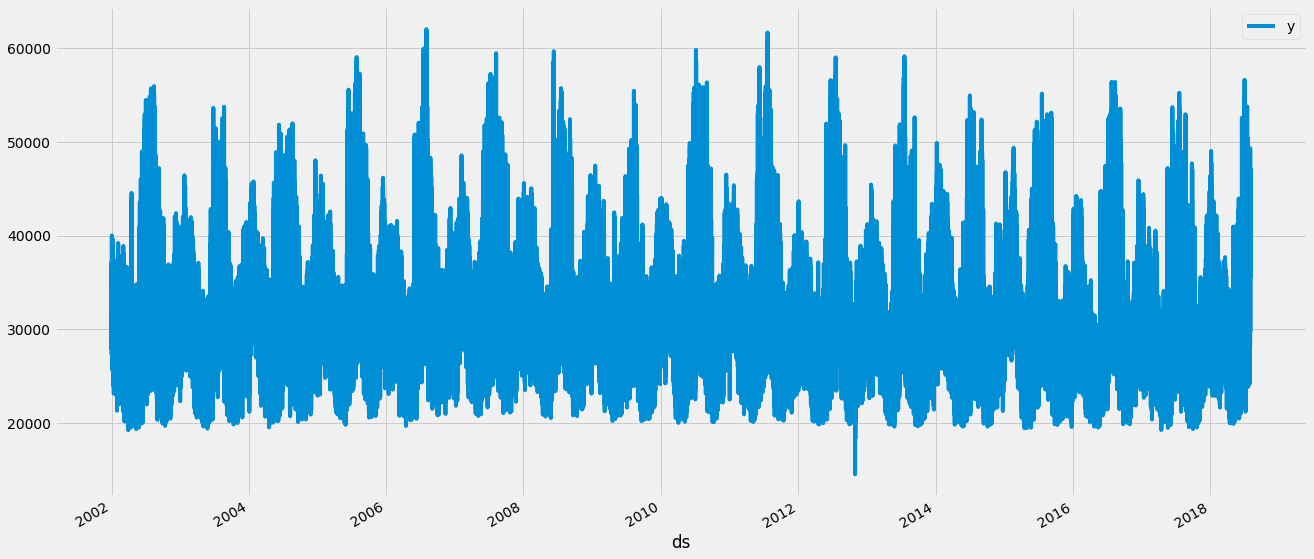

In [ ]:
xdat = df[['Datetime', 'PJME']]
# trim the leading NAs
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0]
xdat = xdat.loc[first_valid:].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2))

17:33:43 - cmdstanpy - INFO - Chain [1] start processing
17:34:29 - cmdstanpy - INFO - Chain [1] done processing


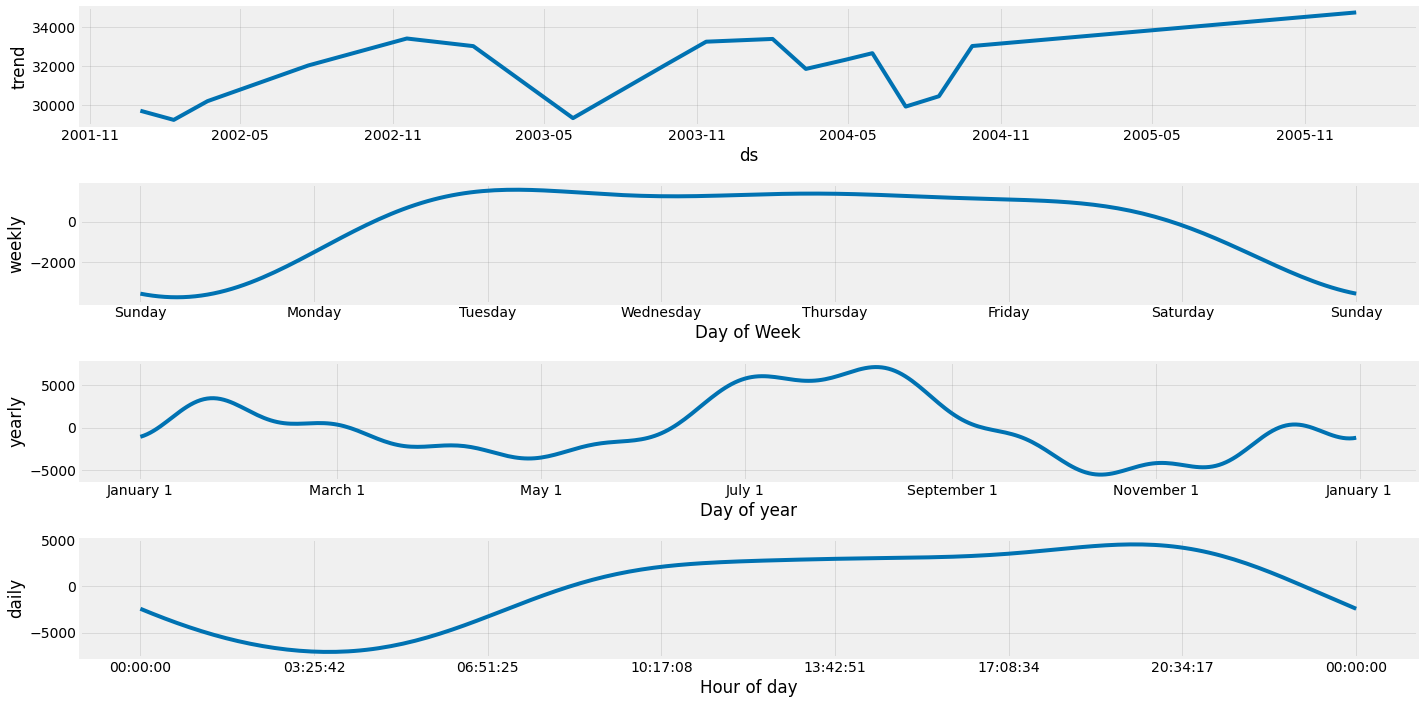

In [ ]:
# we reduce the dataset size for speed - the only requirement while doing is to keep at least two complete cycles 
# for each seasonality we intend to fit 
m = Prophet().fit(xdat.iloc[:30000])
future = m.make_future_dataframe(periods = 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

If we are using data sampled at higher frequency than daily, a daily seasonal pattern is automatically fitted. What if we aggregate the data to daily frequency?

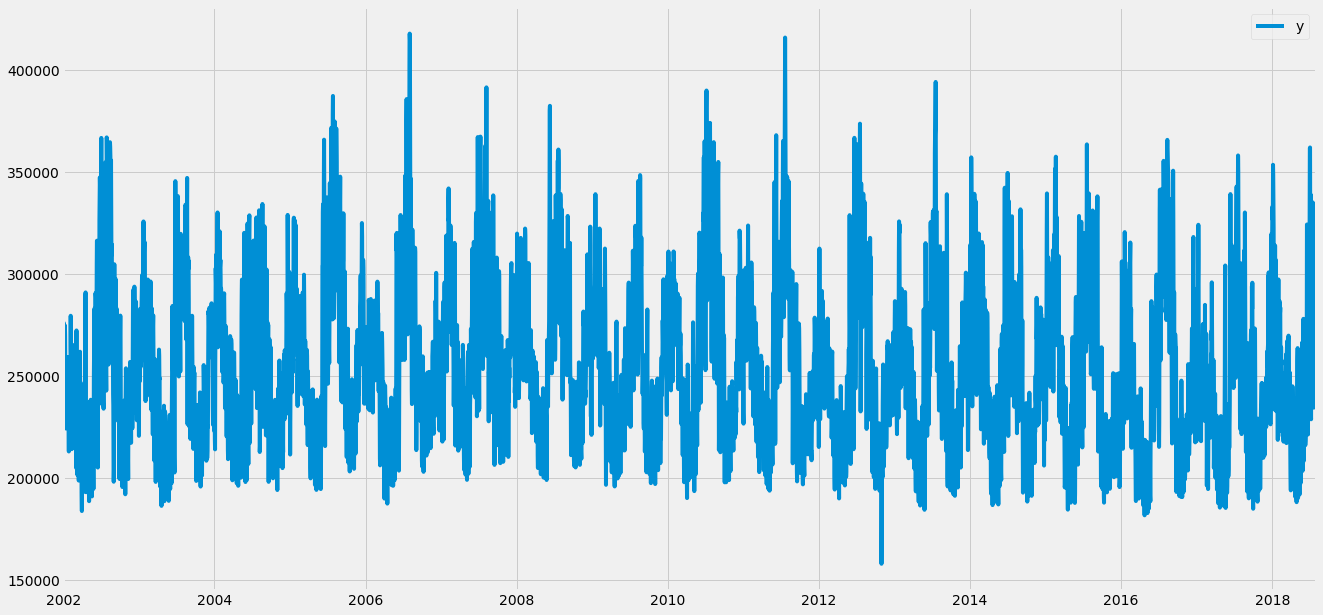

In [ ]:
xdat = df.resample('D', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat['y'] /= 10^9
# we purge the leading zeros, along with the last observation - we only have a few hours of the last day in the sample => incomplete day
ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '')
print()

17:34:43 - cmdstanpy - INFO - Chain [1] start processing
17:34:45 - cmdstanpy - INFO - Chain [1] done processing


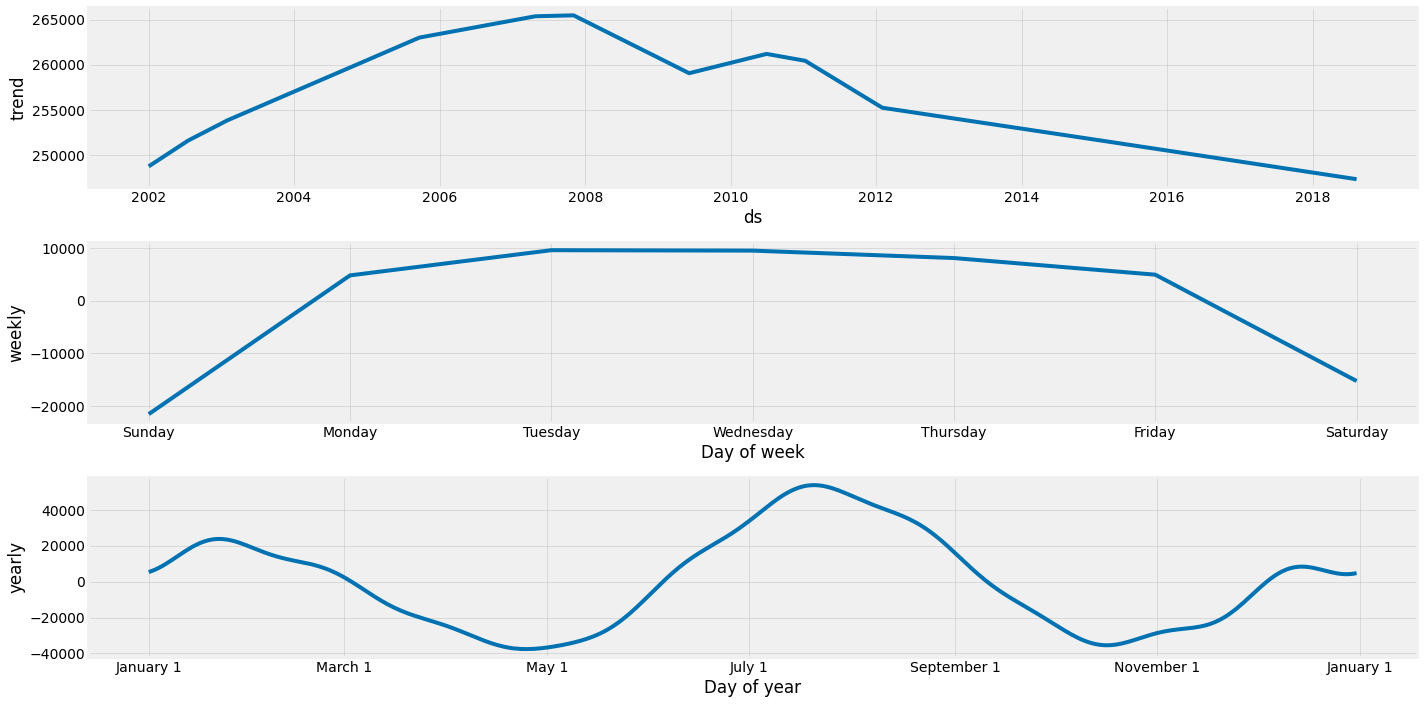

In [ ]:
# we proceed in a similar manner as before
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 7, freq = 'D')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

The same logic applies if we downsample the data further:

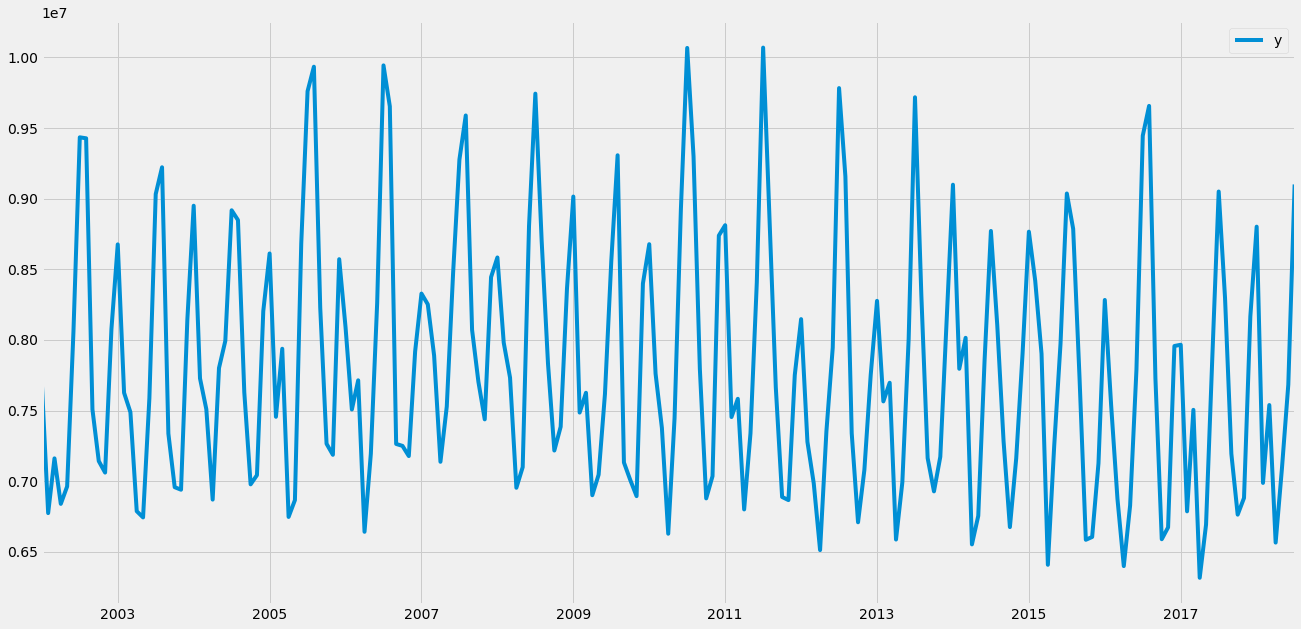

In [ ]:
xdat = df.resample('M', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat['y'] /= 10^9
# we purge the leading zeros, along with the last observation - we only have a few hours of the last day in the sample => incomplete day
ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '')
print()

17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:50 - cmdstanpy - INFO - Chain [1] done processing


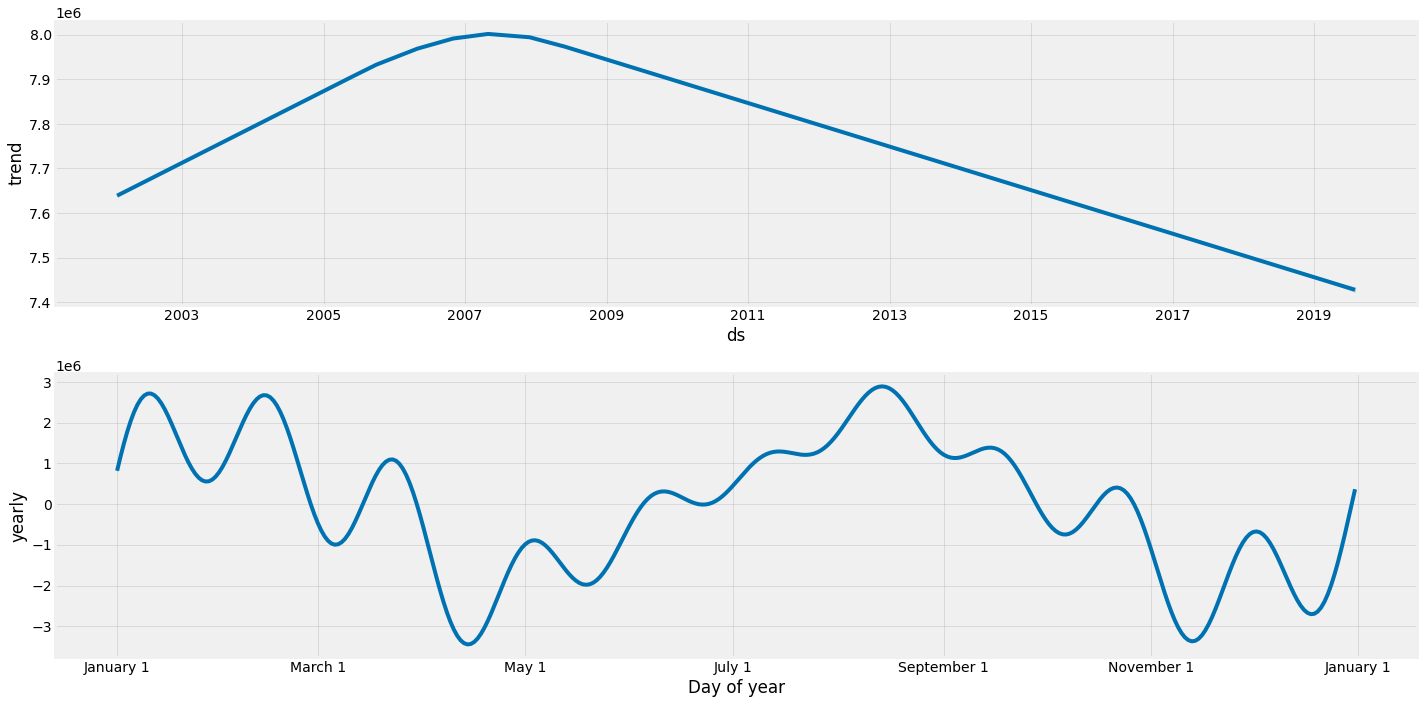

In [ ]:
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 12, freq = 'M')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

## Seasonality specification

Apart from deciding on which frequencies to model explicitly, we have more options to setup our Prophet model. First, there is `seasonality_mode` - additive or multiplicative:

17:34:55 - cmdstanpy - INFO - Chain [1] start processing
17:34:55 - cmdstanpy - INFO - Chain [1] done processing


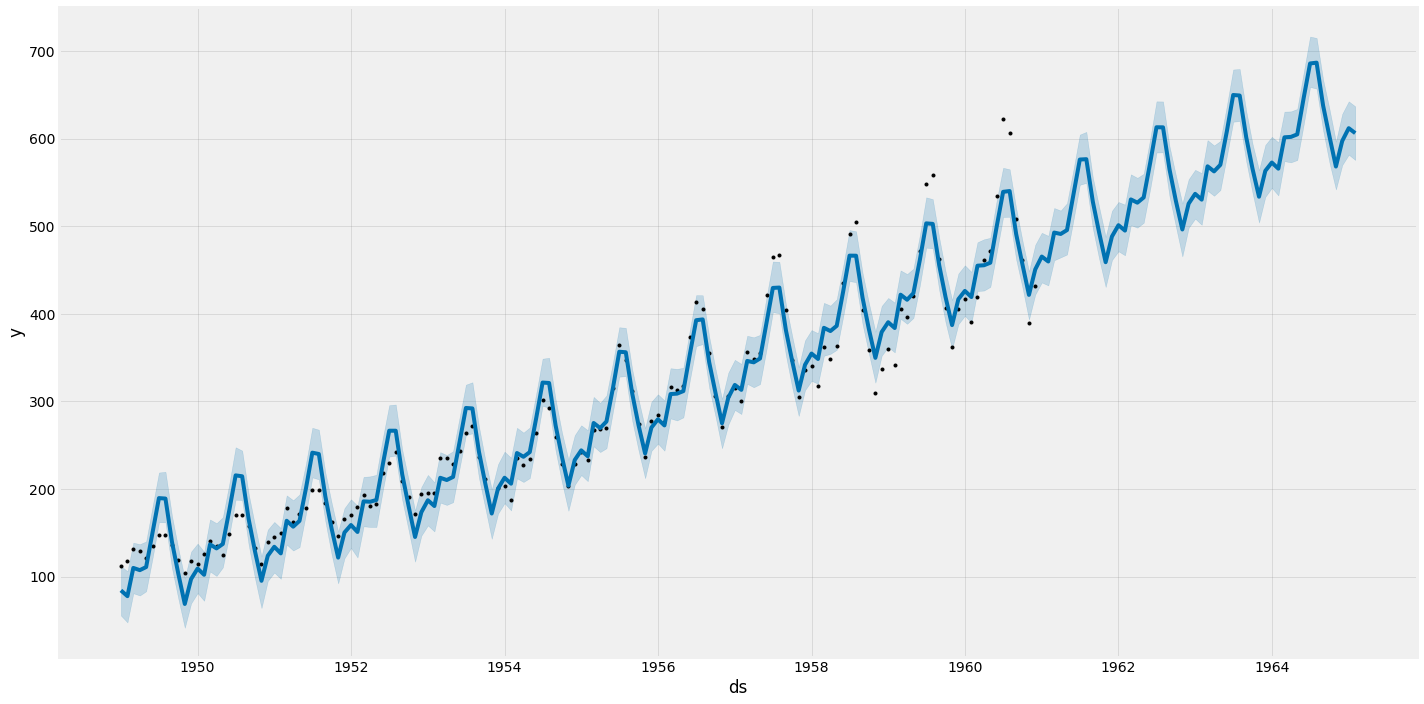

In [ ]:
# import inspect ; xlist = inspect.getfullargspec(Prophet); xlist.args
df = pd.read_csv(CFG.data_folder + 'example_air_passengers.csv')
m = Prophet(seasonality_mode ='additive')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

17:34:57 - cmdstanpy - INFO - Chain [1] start processing
17:34:57 - cmdstanpy - INFO - Chain [1] done processing


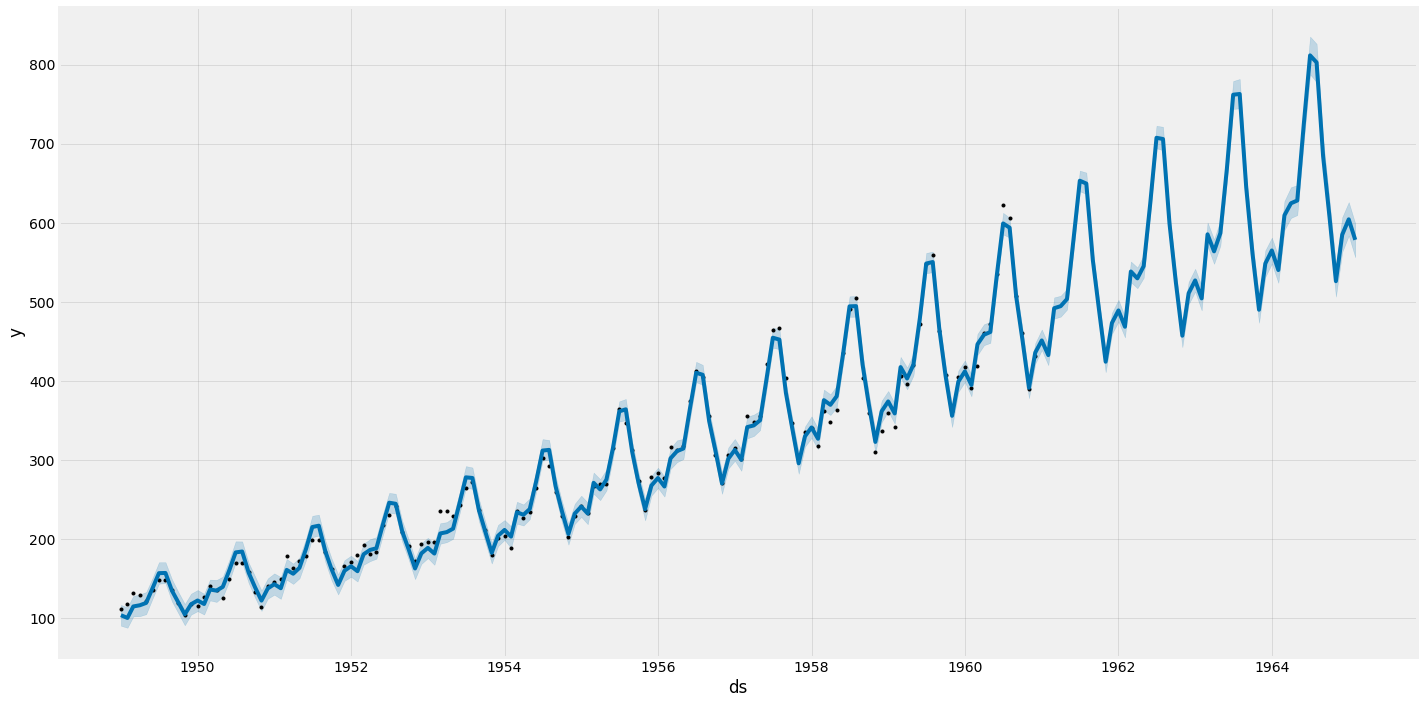

In [ ]:
m = Prophet(seasonality_mode ='multiplicative')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

Depending on the problem at hand, we might want to allow strong effects of the seasonal component on the forecast - or have it reduced. This intuition can be quantified by adjusting the `seasonality_prior_scale` argument, which imapcts the extent to which the seasonality model will fit the data (remark for those with Bayesian exposure: works pretty much the way a prior would).

17:35:01 - cmdstanpy - INFO - Chain [1] start processing
17:35:01 - cmdstanpy - INFO - Chain [1] done processing


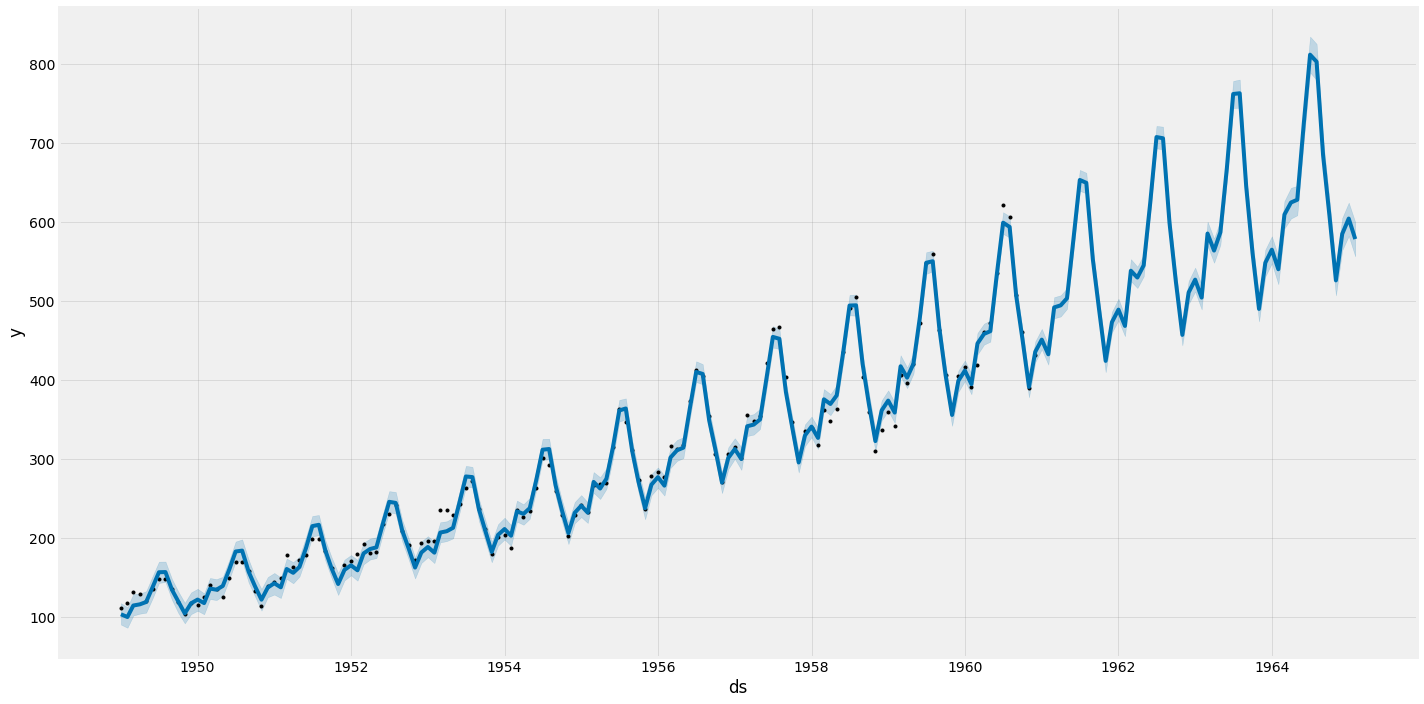

In [ ]:
# we keep the default value
m = Prophet(seasonality_mode ='multiplicative')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

17:35:03 - cmdstanpy - INFO - Chain [1] start processing
17:35:04 - cmdstanpy - INFO - Chain [1] done processing


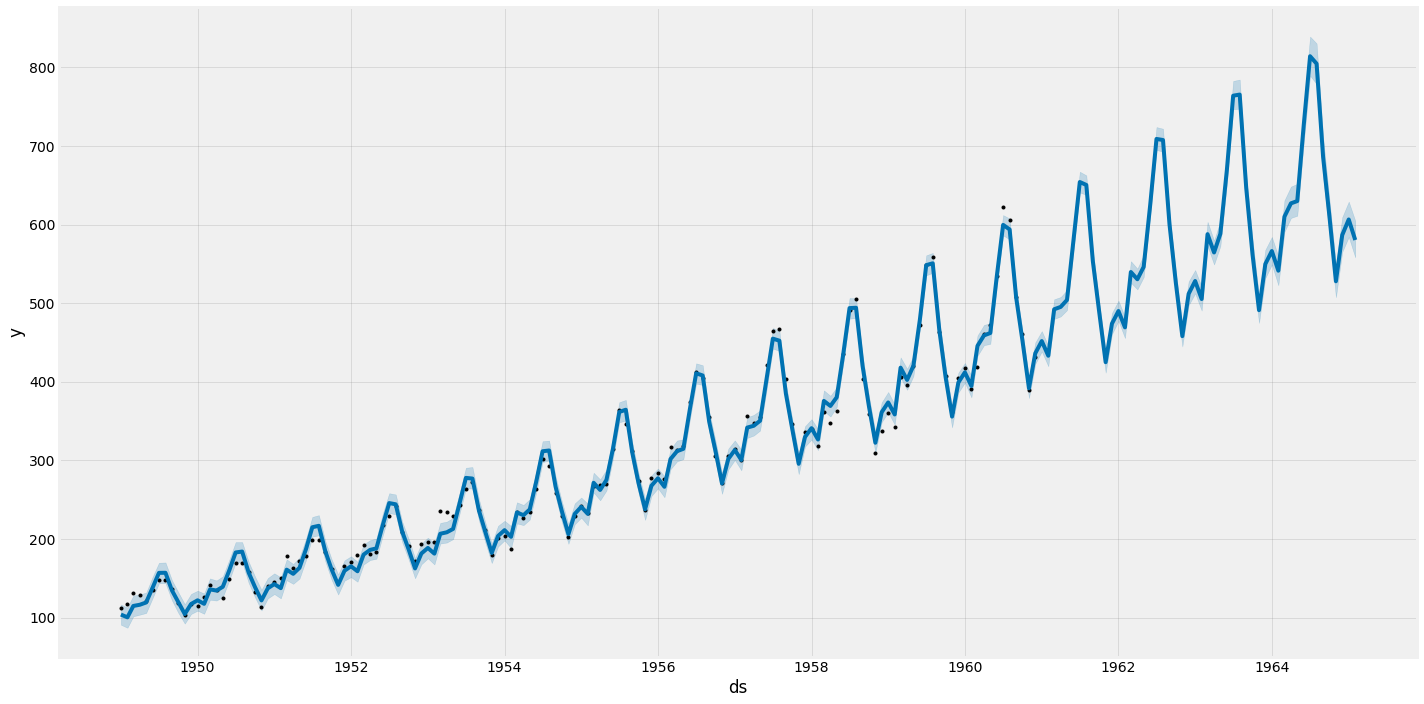

In [ ]:
# we reduce the seasonality prior
m = Prophet(seasonality_mode ='multiplicative', seasonality_prior_scale = 1)
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

Last but not least, we can - as we usually ought to - use interval forecast, i.e. have our point estimates combined with uncertainty. By default the parameter `mcmc_samples` is set to 0, so to get the interval around seasonality, you must do full Bayesian sampling; uncertainty around trend can be calculated with Maximum A Posteriori (MAP) estimate.

17:35:12 - cmdstanpy - INFO - Chain [1] start processing
17:35:56 - cmdstanpy - INFO - Chain [1] done processing


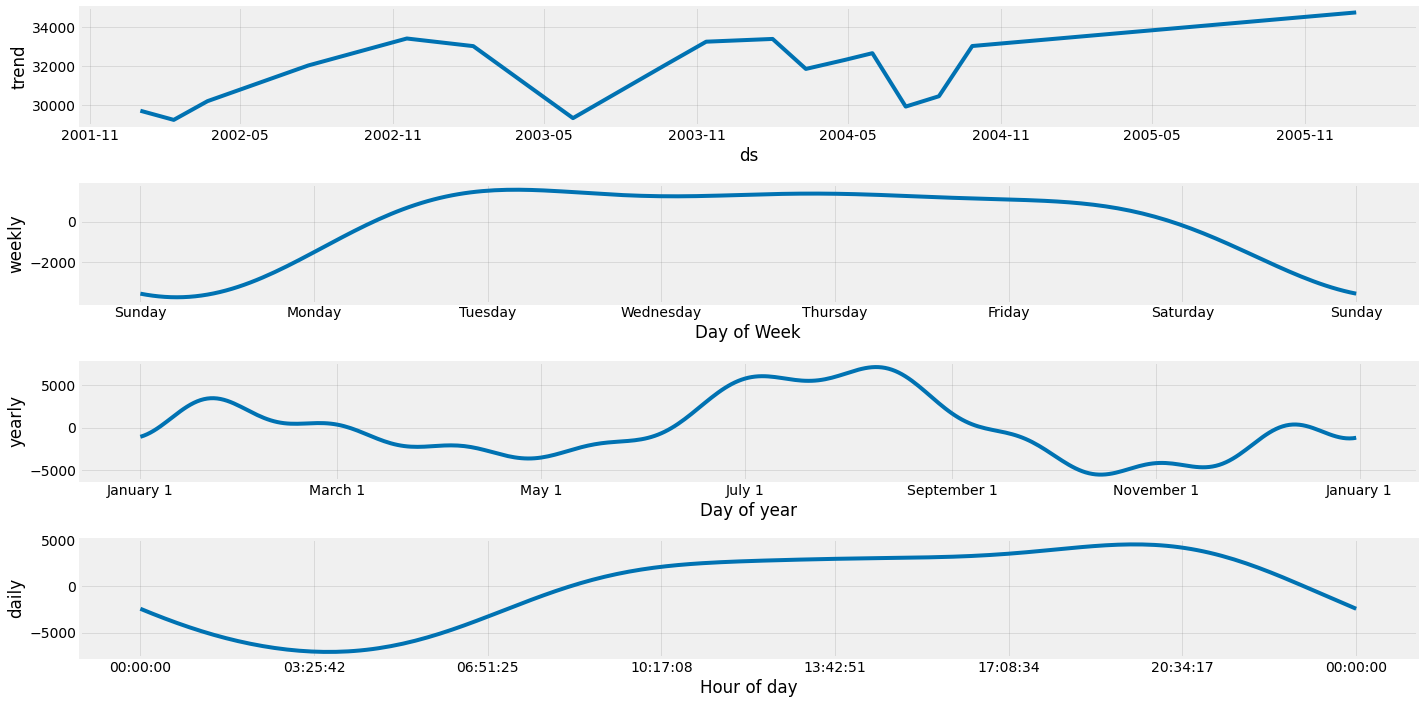

In [ ]:
df = pd.read_csv('./input/pjm_hourly_est.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
xdat = df[['Datetime', 'PJME']]
# trim the leading NAs
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0]
xdat = xdat.loc[first_valid:].rename(columns={"Datetime": "ds", "PJME": "y"})
# xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2))

m = Prophet().fit(xdat.iloc[:30000])
future = m.make_future_dataframe(periods = 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

What if we switch to Bayesian inference (change `mcmc_samples` to a positive integer)?

17:36:17 - cmdstanpy - INFO - CmdStan installation c:\Users\Bharat Anand\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
17:36:17 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
17:36:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█████     | 00:01 Status


chain 1 |██████████| 00:02 Iteration: 1 / 10 [ 10%]  (Warmup)


chain 1 |          | 00:02 Iteration: 6 / 10 [ 60%]  (Sampling)
chain 1 |██████████| 00:02 Sampling completed                  
chain 2 |██████████| 00:02 Sampling completed                  
chain 3 |██████████| 00:02 Sampling completed                  
chain 4 |██████████| 00:02 Sampling completed                  


17:36:19 - cmdstanpy - INFO - CmdStan done processing.
17:36:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exc

17:36:20 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 5 divergent transitions (100.0%)
	Chain 2 had 5 divergent transitions (100.0%)
	Chain 3 had 5 divergent transitions (100.0%)
	Chain 4 had 5 divergent transitions (100.0%)
	Use function "diagnose()" to see further information.


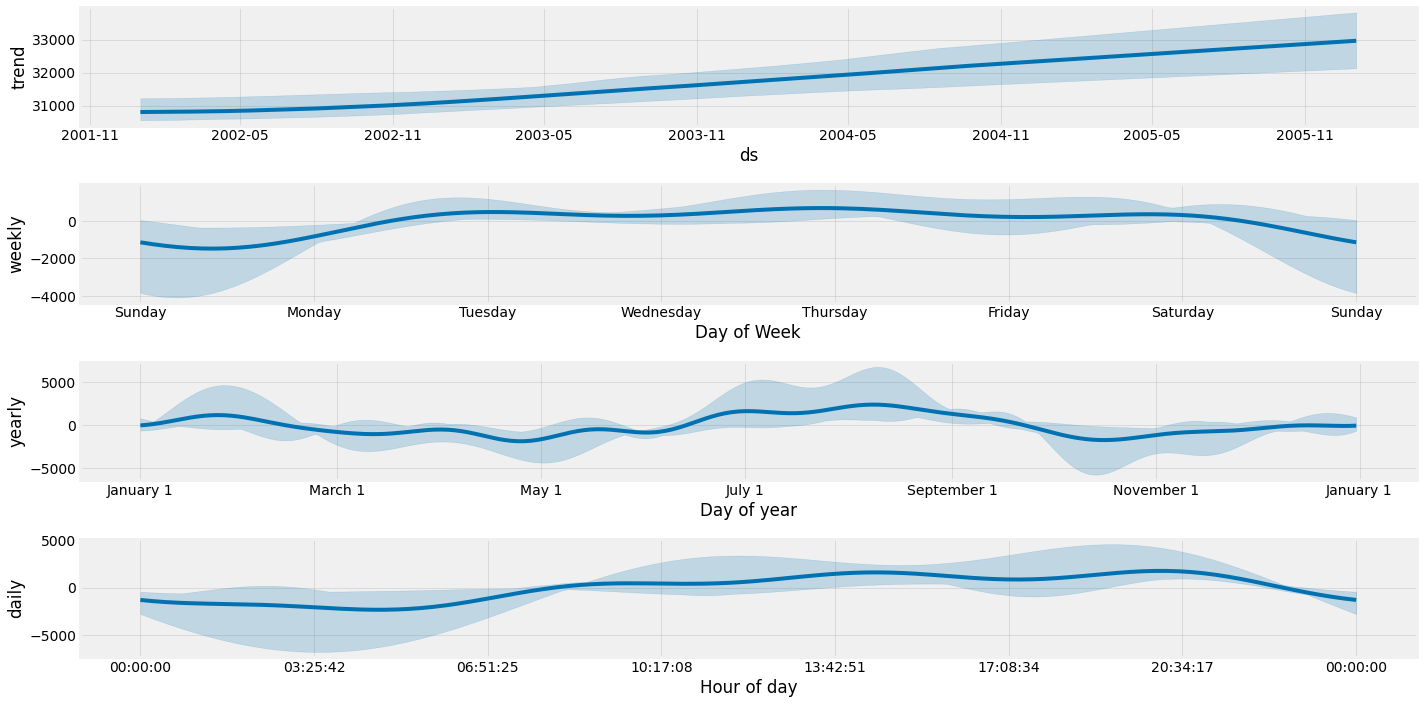

In [ ]:
m = Prophet(mcmc_samples = 10).fit(xdat.iloc[:30000])
future = m.make_future_dataframe(periods = 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

Keep in mind that although PyStan https://pystan.readthedocs.io/en/latest/ is SOTA for MCMC sampling, it still takes some time - especially for long time series.

<a id="section-four"></a>
# Special days

So we have handled trend and seasonality - but that does not mean everything else belongs with the random error component. There are data points that are not random per se, but can still have impact on the performance of the model:

* public holidays (Christmas, Easter, New Year, Black Friday)
* special events (World Cup) 
* major events like conflict starting or terrorist attacks - when analyzing historical performance of the model, it is frequently useful to remove those
* outliers - this is something of a catch-all category, but frequently possible to identify by inspecting the data. 

The Prophet approach to modeling abnormal days is to provide a custom list of events. We assume the effects are independent, so if e.g. a sports event occurs near public holiday, their effects will be captured separately.

## Holidays

The dataset we will use to test the Prophet functionality around special days is daily count of bike commuters in Oslo https://www.kaggle.com/konradb/norway-bicycles

In [ ]:
bikerides = pd.read_csv('./input/bikerides_day.csv', error_bad_lines=False, encoding= 'unicode_escape', delimiter=',')
bikerides.head(5)
# the usual formatting
bikerides = bikerides[['Date', 'Volume']].rename(columns={"Date": "ds", "Volume": "y"})

We start with the fast and easy way of adding holidays: using the built-in list of country holidays:

In [ ]:
m = Prophet()
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
# List the holiday names
m.train_holiday_names

17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:26 - cmdstanpy - INFO - Chain [1] done processing


0         Første nyttårsdag
1           Arbeidernes dag
2              Grunnlovsdag
3            Første juledag
4             Andre juledag
5              Skjærtorsdag
6                Langfredag
7           Første påskedag
8            Andre påskedag
9     Kristi himmelfartsdag
10          Første pinsedag
11           Andre pinsedag
dtype: object

I don't speak Norwegian, but a quick visit to Google Translate shows that Christmas is missing - which, in Europe, is typically a rather important public holiday. We will take care of adding it later, for now let's see how well the model is doing out of the box:

In [ ]:
# as before, we create a dataframe holding the dates for the entire forecast horizon - 180 days ahead
future = m.make_future_dataframe(periods=180, freq='D')
# generate the actual forecast 
forecast = m.predict(future)

fig = go.Figure()
# full disclosure: I am changing the plotting style for this one, because I don't know how to overlay the two graphs with the baseline Prophet plotting functionality that served us well up to that point (not to mention the cool functionality of panning/scaling the graph ;-)

fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

Overall the forecast seems directionally ok - but if we zoom a little closer, there are issues:


Let's see if we can improve by augmenting the list of holidays: we do that by creating a new dataframe `christmas`, which is subsequently passed as an argument to Prophet. The 'holiday' entry is mostly for interpretation sake, relevant parts are:
* `ds` - so we know when the holiday of interest occurs
* `lower_window` and `upper_window`: those two parameters allow us to incorporate the effect before/after the date, respectively. In our example below `lower_window` equals -1, meaning we anticipate a drop in the number of commuters a day before Christmas, whereas `upper_window` is 7 - with a lot of people taking time off between Christmas and New Year, the bicycle traffic is likely to decrease for approximately a week.

In [ ]:
christmas = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2017-12-24','2018-12-24','2019-12-24','2020-12-24']),
  'lower_window': -1,
  'upper_window': 7,
})


m = Prophet(holidays=christmas)
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
future = m.make_future_dataframe(periods=0, freq='D')
forecast = m.predict(future)

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing


## Outliers

We can use the built-in Prophet functionality to deal with outliers - for the sake of clarity of exposition, we will re-use the example used also in the official documentation, i.e. log of daily count of visits to the Wikipedia page of R language.

17:38:41 - cmdstanpy - INFO - Chain [1] start processing
17:38:45 - cmdstanpy - INFO - Chain [1] done processing


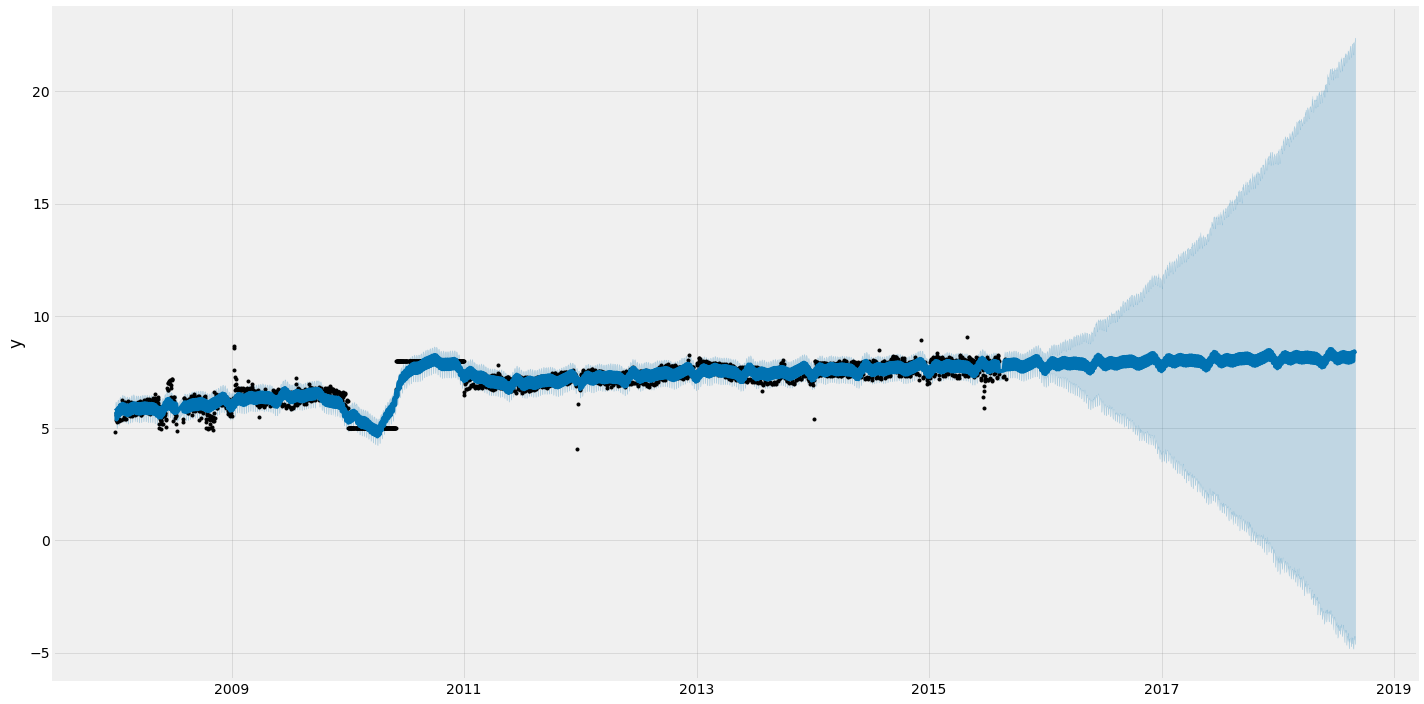

In [ ]:
df = pd.read_csv(CFG.data_folder + 'example_wp_log_R_outliers1.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')

The pattern in 2011 does not look plausible (flat line, jump, flat line at a higher level), and those observations are the most likely culprit for the misspecified trend and the resulting bredth of the confidence bands. Prophet allows us to deal with the problem in a very straightforward manner, i.e. by replacing the dubious observations with `None` (not `NaN` - it is an important distinction to keep in mind).

17:40:43 - cmdstanpy - INFO - Chain [1] start processing
17:40:44 - cmdstanpy - INFO - Chain [1] done processing


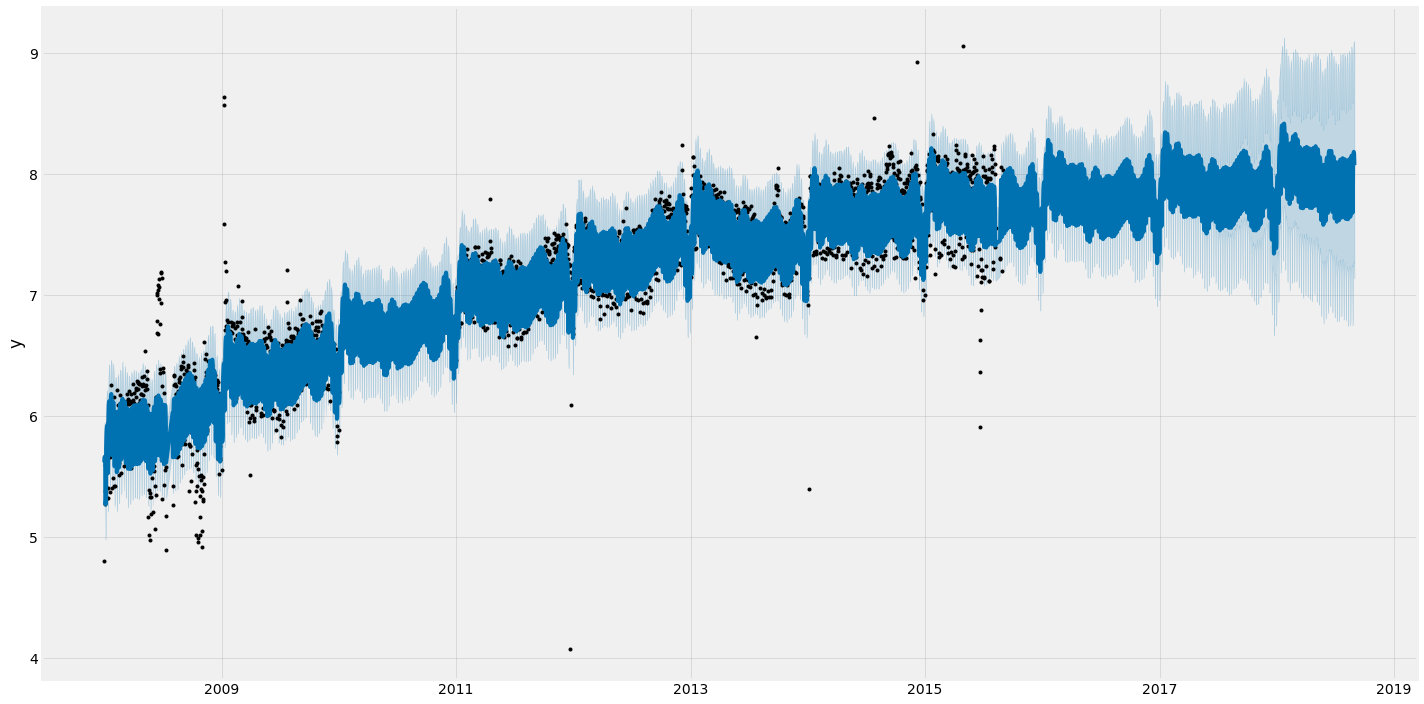

In [ ]:
df.loc[(df['ds'] > '2010-01-01') & (df['ds'] < '2011-01-01'), 'y'] = None
model = Prophet().fit(df)
fig = model.plot(model.predict(future), figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
plt.show()

Another type of situation we may encounter is a few points whose values are extremely off, so as a result the seasonality estimate is impacted.

17:40:47 - cmdstanpy - INFO - Chain [1] start processing
17:40:47 - cmdstanpy - INFO - Chain [1] done processing


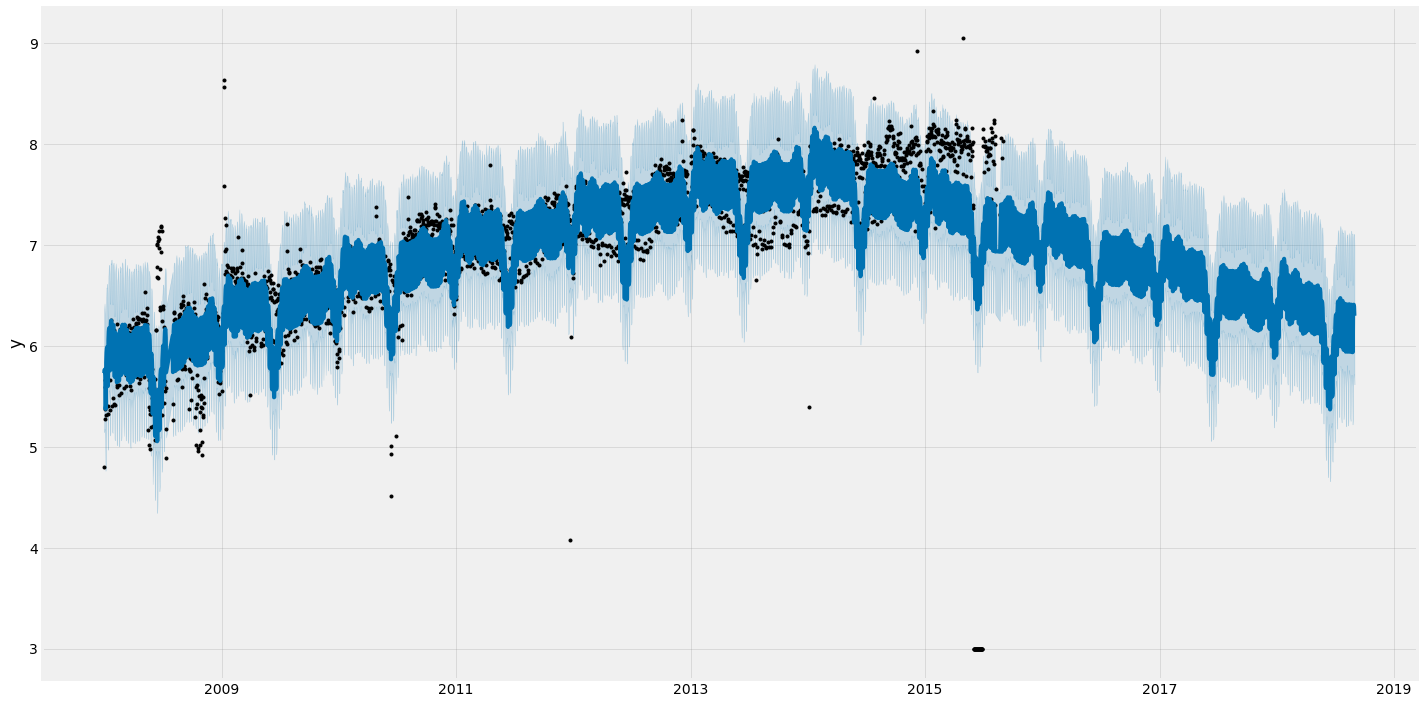

In [ ]:
df = pd.read_csv(CFG.data_folder + 'example_wp_log_R_outliers2.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
plt.show()

As before, the simplest solution is to get rid of those points and leave the algorithm to interpolate within the sample:

17:40:52 - cmdstanpy - INFO - Chain [1] start processing
17:40:54 - cmdstanpy - INFO - Chain [1] done processing


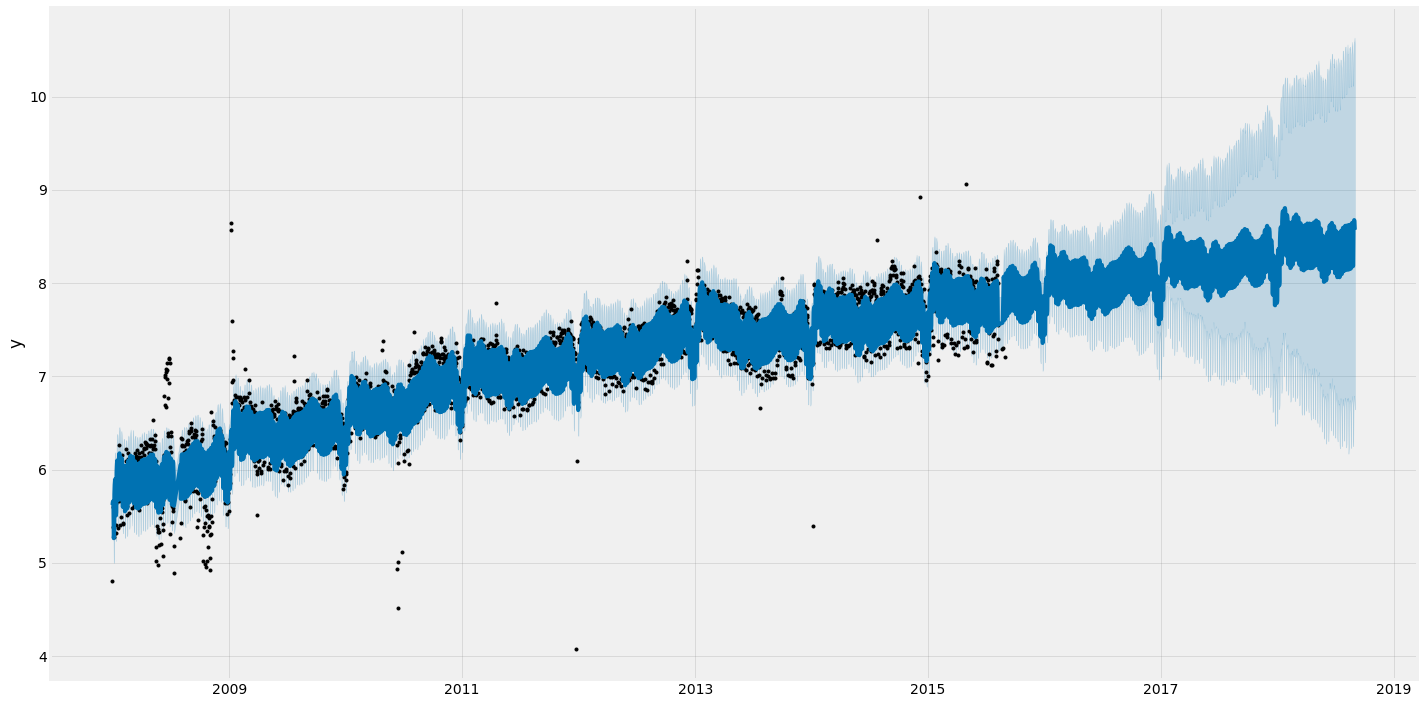

In [ ]:
df.loc[(df['ds'] > '2015-06-01') & (df['ds'] < '2015-06-30'), 'y'] = None
m = Prophet().fit(df)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
plt.show()

To summarize: leveraging the Prophet functionality around in-sample interpolation, we can solve issues related to outliers by simply replacing them with `None`s.

<a id="section-five"></a>
# Performance evaluation

Cross validation for time series can be sometimes challenging, but the Prophet approach takes the hassle out of having to create your own function for a rolling forecast. We utilize the `cross_validation` function: the parameters to specify are the forecast horizon `horizon` and (optionally) size of the initial training period `initial` and the spacing between cutoff dates `period`. By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

In [ ]:
df_cv = cross_validation(m, initial = '1000 days', period = '30 days', horizon='30 days')

  0%|          | 0/59 [00:00<?, ?it/s]17:41:23 - cmdstanpy - INFO - Chain [1] start processing
17:41:23 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/59 [00:01<01:13,  1.27s/it]17:41:24 - cmdstanpy - INFO - Chain [1] start processing
17:41:25 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 2/59 [00:02<01:15,  1.32s/it]17:41:26 - cmdstanpy - INFO - Chain [1] start processing
17:41:26 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 3/59 [00:04<01:19,  1.41s/it]17:41:27 - cmdstanpy - INFO - Chain [1] start processing
17:41:28 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 4/59 [00:05<01:17,  1.42s/it]17:41:29 - cmdstanpy - INFO - Chain [1] start processing
17:41:29 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 5/59 [00:07<01:19,  1.48s/it]17:41:30 - cmdstanpy - INFO - Chain [1] start processing
17:41:31 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 6/59 [00:08<01:19,  1.50s/it]17:41:32

The output of cross_validation is a dataframe where for $cutoff$ (last timepoint in the training set) we get a number of values:
* $ds$ is the timepoint in test set
* $y$ is the true value at $ds$
* $yhat\_lower$ and $yhat\_upper$ are the lower and upper ends of the condifence interval, respectively

In [ ]:
df_cv.head(10)

ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2010-10-27  7.047467    6.693515    7.369700  7.370860 2010-10-26
1 2010-10-28  7.043761    6.705512    7.421597  7.407318 2010-10-26
2 2010-10-29  6.958625    6.586140    7.306067  7.237778 2010-10-26
3 2010-10-30  6.614861    6.251982    6.967607  6.742881 2010-10-26
4 2010-10-31  6.599040    6.268086    6.966501  6.884487 2010-10-26
5 2010-11-01  6.992412    6.636032    7.319073  7.235619 2010-10-26
6 2010-11-02  7.078560    6.721093    7.432962  7.195937 2010-10-26
7 2010-11-03  7.114851    6.758031    7.458330  7.145984 2010-10-26
8 2010-11-04  7.125867    6.770036    7.451117  7.313887 2010-10-26
9 2010-11-05  7.055117    6.719688    7.384262  7.187657 2010-10-26

While informative, the object created with `cross_validation` contains an abundance of information. This can be summarized in a more succinct manner by aggregating to yield performance metrics:

In [ ]:
df_p = performance_metrics(df_cv)
df_p.head(5)

horizon       mse      rmse       mae      mape     mdape     smape  \
0  3 days  0.095033  0.308274  0.168804  0.024455  0.017904  0.023395   
1  4 days  0.094851  0.307979  0.169250  0.024441  0.018023  0.023397   
2  5 days  0.083963  0.289765  0.160570  0.023411  0.017335  0.022328   
3  6 days  0.037636  0.194001  0.146805  0.019806  0.016403  0.019795   
4  7 days  0.037056  0.192500  0.147390  0.019976  0.016178  0.019943   

   coverage  
0  0.913087  
1  0.906937  
2  0.918129  
3  0.901098  
4  0.918744

The values from the `cross_validation` objects are aggregated for each horizon and different metrics are calculated.

<a id="section-six"></a>
# Full pipeline

We are in a position to combine all the building block - we will use the Superstore dataset (a version can be found here: https://www.kaggle.com/bravehart101/sample-supermarket-dataset).

In [ ]:
!pip install xlrd

You should consider upgrading via the 'C:\Users\Bharat Anand\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [ ]:
df = pd.read_excel(CFG.data_folder + "Sample - Superstore.xls")
df = df.loc[df['Category'] == 'Furniture']
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID',
        'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region',
        'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
df.drop(cols, axis=1, inplace=True)
df = df.sort_values('Order Date')
df = df.groupby('Order Date')['Sales'].sum().reset_index()

# Prophet-friendly format
df.rename(columns={"Order Date": "ds", "Sales": "y"}, inplace = True)

In the previous module we aggregated the dataset to monthly frequency - some observations were missing and ARIMA does not have a straightforward method of dealing with that (interpolation in time series is a serious topic, deserving its own module probably). Prophet does not suffer from the same limitation, so we stay at daily frequency. 

What does our series look like?

<AxesSubplot:>

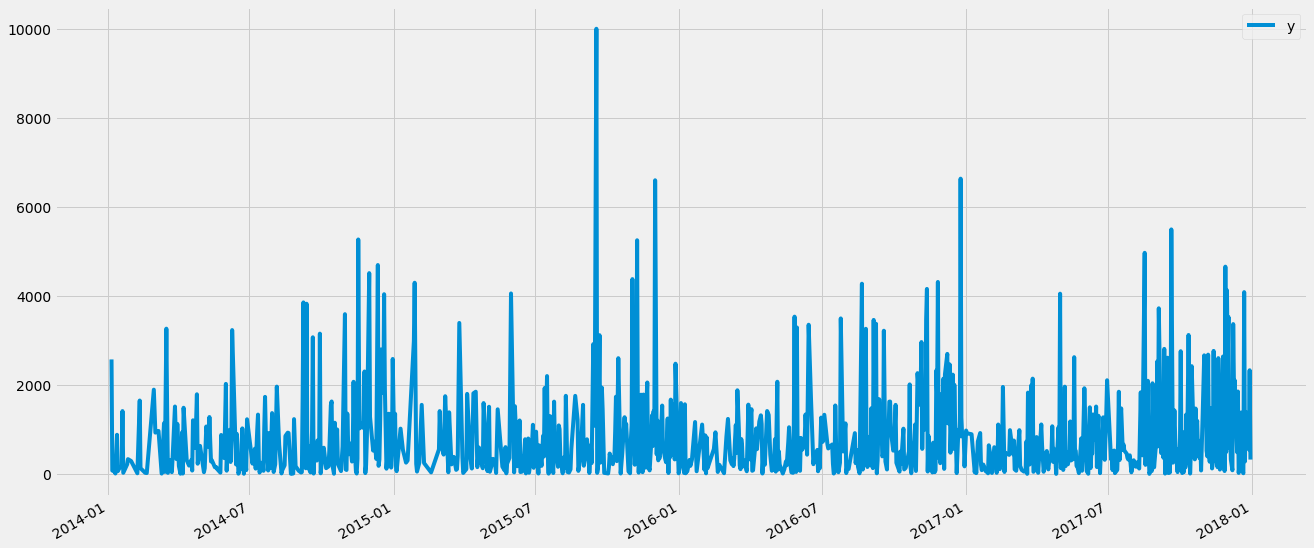

In [ ]:
df.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')

What is the time range we are dealing with?

In [ ]:
min(df['ds']), max(df['ds'])

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

With four complete cycles present, we can keep the last three months of 2017 as validation and use the rest of the data for training:

In [ ]:
df_train = df.loc[df['ds'] < '2017-10-01']
df_valid = df.loc[df['ds'] >= '2017-10-01']
print(df_train.shape, df_valid.shape)

(810, 2) (79, 2)


Next step is specifying the form of our model - we can combine this step with hyperparameter tuning. In order to keep the running time of this notebook within reasonable limits, the possible parameter ranges to a bare minimum needed to demonstrate the functionality (in a real application the only real limit is your patience).

In [ ]:
param_grid = {  
    # tuning those parameters can potentially improve the performance of our model
    'changepoint_prior_scale': [0.001, 0.1],
#    'seasonality_prior_scale': [0.01, 1.0],
#    'holidays_prior_scale': [0.01, 0.1],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  

# Quick peek at what our combinations look like
all_params

[{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative'},
 {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}]

In [ ]:
for params in all_params:
    m = Prophet(**params).fit(df)
    df_cv = cross_validation(m, initial = '100 days', period = '30 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)

17:47:27 - cmdstanpy - INFO - Chain [1] start processing
17:47:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:49:18 - cmdstanpy - INFO - Chain [1] start processing
17:49:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:49:44 - cmdstanpy - INFO - Chain [1] start processing
17:49:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:50:00 - cmdstanpy - INFO - Chain [1] start processing
17:50:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


   changepoint_prior_scale seasonality_mode         rmse
0                    0.001         additive  8546.275890
1                    0.001   multiplicative  2537.614923
2                    0.100         additive  3882.669853
3                    0.100   multiplicative  2116.216864
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


With the tuned parameters available we can proceed to setup the complete model - as mentioned before, the parameters can included in the tuning part can be left at default values (`auto` for `yearly_seasonality` is automatically set to `True` if there are multiple years in the data etc):

In [ ]:
m = Prophet(**params)
m.add_country_holidays(country_name='US')
m.fit(df_train)

17:50:21 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing


Model component inspection:

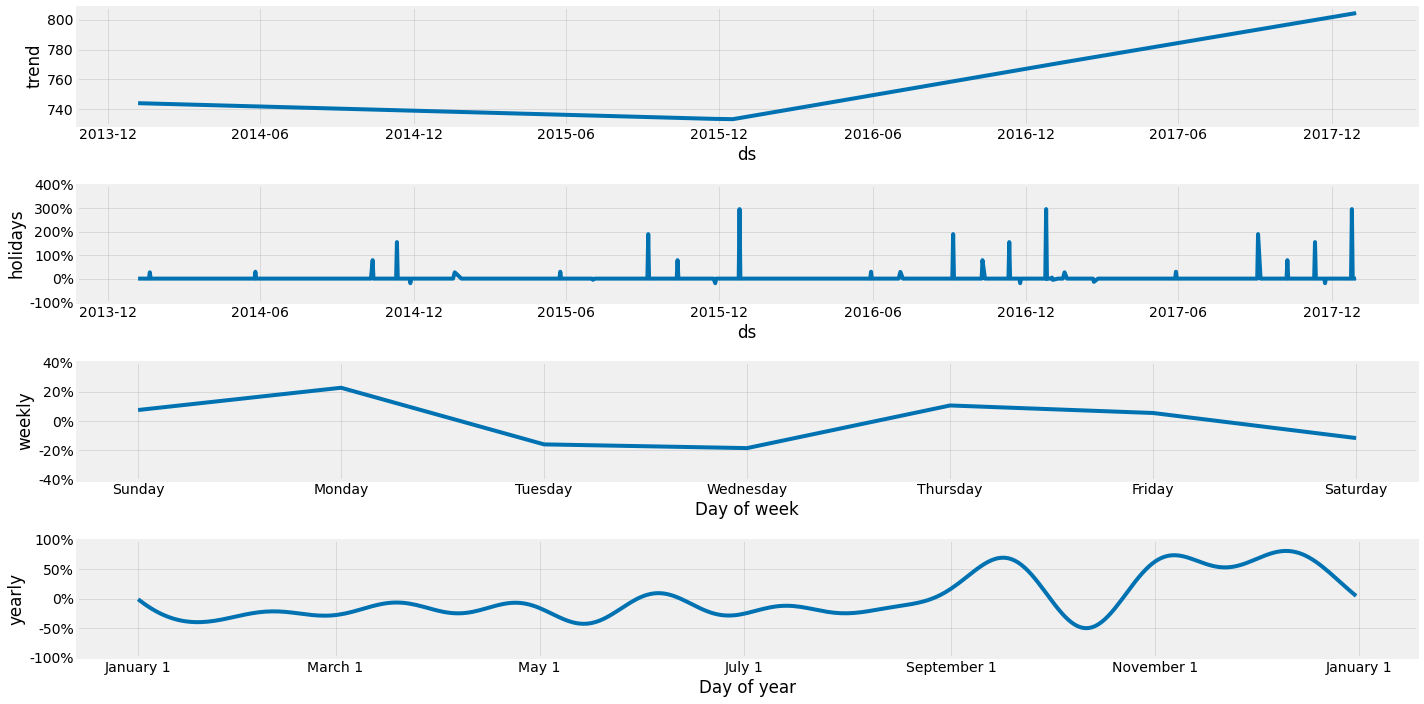

In [ ]:
future = m.make_future_dataframe(periods = 92, freq = 'D')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

By default, the `forecast` dataframe contains an abundance of information, including point/upper/lower estimates of the contribution made to the forecast by the trend component, different seasonalities and each holiday defined in the model:

In [ ]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (Observed)', 'Christmas Day (Observed)_lower',
       'Christmas Day (Observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (Observed)',
       'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
       'Thanksgiv

While interesting if you want to examine every component in detail, for this example we will focus on the point forecast and the associated confidence band:

In [ ]:
xfor = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].loc[forecast['ds'] >= '2017-10-01' ]
xfor.head(10)

ds         yhat   yhat_upper  yhat_lower
811 2017-10-01   829.582263  2014.788317 -366.704163
812 2017-10-02   891.020113  2028.145390 -332.125719
813 2017-10-03   527.255102  1722.510988 -670.257264
814 2017-10-04   453.833414  1645.651729 -714.941102
815 2017-10-05   636.248743  1800.529820 -510.168832
816 2017-10-06   552.038174  1725.258036 -687.679900
817 2017-10-07   378.864386  1626.681314 -782.463440
818 2017-10-08   500.465317  1666.092187 -715.081094
819 2017-10-09  1223.800398  2403.137435   75.118107
820 2017-10-10   275.726349  1502.142324 -936.810948

In [ ]:
# we combine the forecast dataframe with the original test data
# we use a left outer join because of the missing observations in the original data
xfor = pd.merge(left = xfor, right = df, on = 'ds', how = 'left')

In [ ]:
xfor.head(10)

ds         yhat   yhat_upper  yhat_lower         y
0 2017-10-01   829.582263  2014.788317 -366.704163   559.760
1 2017-10-02   891.020113  2028.145390 -332.125719  2758.464
2 2017-10-03   527.255102  1722.510988 -670.257264   255.208
3 2017-10-04   453.833414  1645.651729 -714.941102    19.980
4 2017-10-05   636.248743  1800.529820 -510.168832   935.802
5 2017-10-06   552.038174  1725.258036 -687.679900    41.960
6 2017-10-07   378.864386  1626.681314 -782.463440   462.430
7 2017-10-08   500.465317  1666.092187 -715.081094   145.764
8 2017-10-09  1223.800398  2403.137435   75.118107  1333.393
9 2017-10-10   275.726349  1502.142324 -936.810948   239.358

<AxesSubplot:>

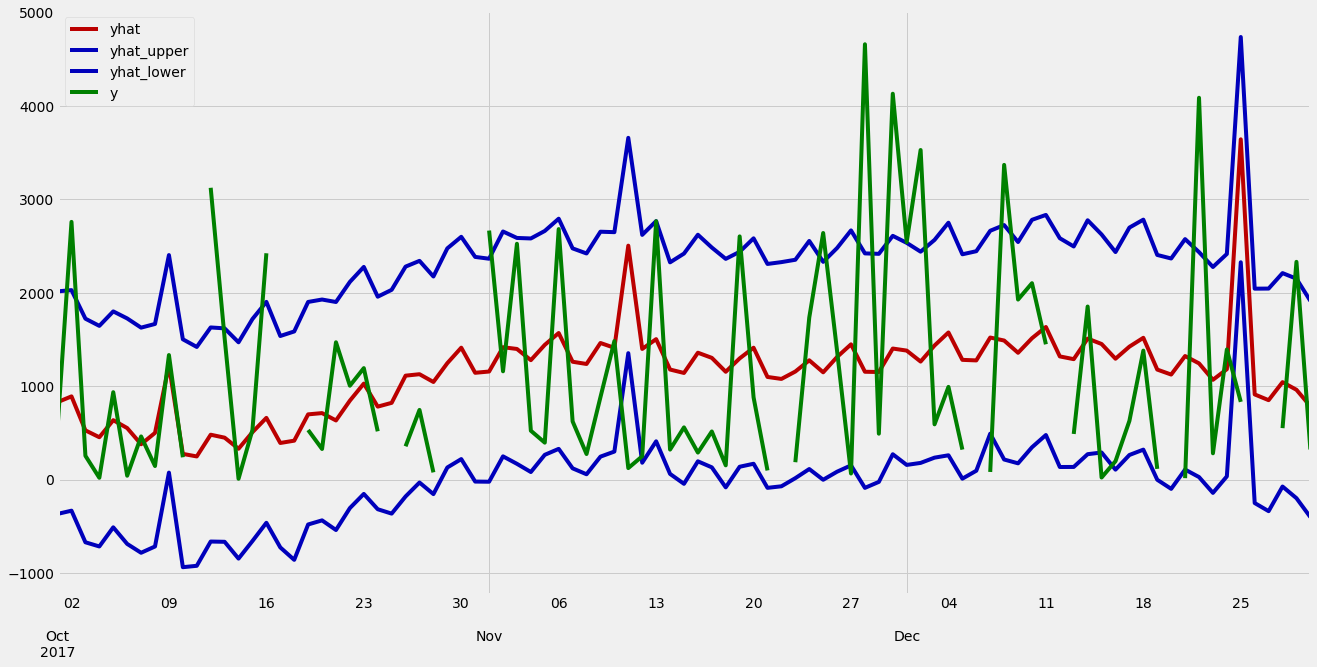

In [ ]:
colors = ['#BB0000' , '#0000BB', '#0000BB', 'green']

xfor['ds'] = pd.to_datetime(xfor['ds'])
xfor.set_index('ds').plot(color = colors, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')

While there is definitely space for improvement - the model does not capture the magnitude of the variations, and the associated confidence interval is rather broad - this example demonstrates that with minimal effort, we can use Prophet to model time series in a fast and intrepretable manner.

<a id="section-seven"></a>
# Using covariates

It is not a terribly common situation, but sometimes we get lucky and there is extra information we can use to improve the quality of our forecast: stable weather prediction, or some economic indicators made known earlier than others. In this section we demonstrate how this functionality works in Prophet. First thing we do, we load our dataset (recorded performance of the teams in the Autonomous Greenhouse Challenge) - we will focus on the subset of the original problem, namely how to predict the air temperature based on the settings in the greenhouse environment. The original dataset can be found here: https://www.kaggle.com/piantic/autonomous-greenhouse-challengeagc-2nd-2019.

In [ ]:
xdat = pd.read_csv('./input/GreenhouseClimate1.csv')
xdat.head(3)

time  AssimLight   BlackScr  CO2air  Cum_irr  EC_drain_PC  EnScr  \
0  43815.00000         0.0  35.000000   439.0     0.48         3.61   96.0   
1  43815.00347         0.0  85.000001   459.0     0.72         3.61   96.0   
2  43815.00694         0.0  95.999999   461.0     0.72         3.61   94.6   

   HumDef  PipeGrow  PipeLow  ...  t_rail_min_sp  t_rail_min_vip  t_vent_sp  \
0    6.96       0.0     50.9  ...            NaN             0.0        NaN   
1    7.45       0.0     49.3  ...            NaN             0.0        NaN   
2    5.99       0.0     47.6  ...            NaN             0.0        NaN   

   t_ventlee_vip  t_ventwind_vip  water_sup  water_sup_intervals_sp_min  \
0           25.0            26.0        4.0                         NaN   
1           25.0            26.0        6.0                         NaN   
2           25.0            26.0        6.0                         NaN   

   water_sup_intervals_vip_min  window_pos_lee_sp  window_pos_lee_vip  
0                       1000.0                NaN                 1.2  
1                       1000.0                NaN                 1.2  
2                       1000.0                NaN                 1.2  

[3 rows x 50 columns]

That's a lot of columns, and we will get to that in a moment - but first, we need to do something about the timestamp. The original data was sampled every 5 minutes and stored in Excel format, which is why need to adjust the epoch start:

In [ ]:
xdat['time'] = pd.to_datetime(xdat['time'], unit = 'D', origin = "1899-12-30")
xdat.head(3)

time  AssimLight   BlackScr  CO2air  Cum_irr  \
0 2019-12-16 00:00:00.000000000         0.0  35.000000   439.0     0.48   
1 2019-12-16 00:04:59.808000256         0.0  85.000001   459.0     0.72   
2 2019-12-16 00:09:59.616000000         0.0  95.999999   461.0     0.72   

   EC_drain_PC  EnScr  HumDef  PipeGrow  PipeLow  ...  t_rail_min_sp  \
0         3.61   96.0    6.96       0.0     50.9  ...            NaN   
1         3.61   96.0    7.45       0.0     49.3  ...            NaN   
2         3.61   94.6    5.99       0.0     47.6  ...            NaN   

   t_rail_min_vip  t_vent_sp  t_ventlee_vip  t_ventwind_vip  water_sup  \
0             0.0        NaN           25.0            26.0        4.0   
1             0.0        NaN           25.0            26.0        6.0   
2             0.0        NaN           25.0            26.0        6.0   

   water_sup_intervals_sp_min  water_sup_intervals_vip_min  window_pos_lee_sp  \
0                         NaN                       1000.0                NaN   
1                         NaN                       1000.0                NaN   
2                         NaN                       1000.0                NaN   

   window_pos_lee_vip  
0                 1.2  
1                 1.2  
2                 1.2  

[3 rows x 50 columns]

That's better. Reading through the Readme in the description of the original dataset, we can identify the variables that are available going forward. Since only those are useful as external covariates potentially helpful with our forecast, we can subset the dataframe:

In [ ]:
# timestamp and target variable
list1 = ['time', 'Tair']

# candidate variables for external regressors improving the forecast
list2 = ['co2_sp', 'dx_sp', 't_rail_min_sp', 't_grow_min_sp',
        'assim_sp', 'scr_enrg_sp', 'scr_blck_sp', 't_heat_sp',
        't_vent_sp', 'window_pos_lee_sp', 'water_sup_intervals_sp_min',
        'int_blue_sp', 'int_red_sp', 'int_farred_sp',
        'int_white_sp']

xdat = xdat[list1 + list2]

A realistic lookahead period might be 24 hours - we can either stick to the original resolution of the data and forecast 24 * 12 = 288 steps ahead, or downsample the data to hourly frequency. Since all the variables are numerical, we just take their average values within each hour:

In [ ]:
xdat2 = xdat.resample('H', on = 'time').mean().reset_index()[list1 + list2]

In [ ]:
# let's quickly check for missing values - Prophet can handle those (by interpolation), but they are not useful in terms of predictive value
np.isnan(xdat2[['Tair'] + list2]).describe()

Tair co2_sp  dx_sp t_rail_min_sp t_grow_min_sp assim_sp scr_enrg_sp  \
count    3985   3985   3985          3985          3985     3985        3985   
unique      2      2      2             2             2        2           2   
top     False  False  False         False         False    False       False   
freq     3983   3945   3944          3944          3878     3944        3944   

       scr_blck_sp t_heat_sp t_vent_sp window_pos_lee_sp  \
count         3985      3985      3985              3985   
unique           2         2         2                 2   
top          False     False     False             False   
freq          3944      3945      3945              3944   

       water_sup_intervals_sp_min int_blue_sp int_red_sp int_farred_sp  \
count                        3985        3985       3985          3985   
unique                          2           1          1             1   
top                         False       False      False         False   
freq                         3901        3985       3985          3985   

       int_white_sp  
count          3985  
unique            1  
top           False  
freq           3985

<AxesSubplot:>

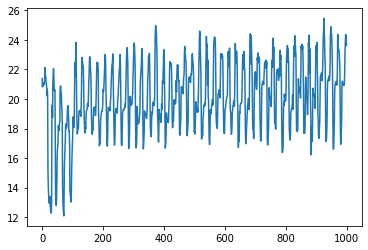

In [ ]:
xdat2.dropna(subset = ['Tair'], inplace = True)

# what does our data look like after preparation? 
xdat2['Tair'][0:1000].plot()

This looks ready for applying Prophet: as before, we start by formatting the dataframe into the format expected by the algorithm

In [ ]:
df = xdat2[['time', 'Tair']].rename(columns={"time": "ds", "Tair": "y"})

The only real adjustment we need is disabling weekly seasonality. By default, Prophet fits any seasonal pattern with enough data - annual pattern will not be fitted since we only have 6 months worth of data, hourly is automatic, but weekly makes no sense for a physical phenomenon (there is no reason to expect temperature to be dependent on day of the week).

In [ ]:
m = Prophet(weekly_seasonality=False, interval_width = 0.95)
m.fit(df)

# build the forecast the usual way
future = m.make_future_dataframe(periods= 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

NameError: name 'Prophet' is not defined

In [ ]:
# Calculate the cross-validation performance
df_cv = cross_validation(m,initial = '3700 hours', period = '24 hours', horizon = '24 hours')
df_p1 = performance_metrics(df_cv)
df_p1.head(10)

NameError: name 'cross_validation' is not defined

This gives us an idea of the model performance in a "vanilla" version. Let's add the covariates:

In [ ]:
# we need to drop NA - Prophet can handle missing values in the target, but not in the explanatory variables 
# (and neither does the recursive feature elimination routine RFECV)

xdat2 = xdat2.dropna()

# for the sake of demonstration, we keep it simple - so Ridge is good enough to check the importance of a variable for our target prediction
estimator = Ridge()
# the elimination is a bit agressive :-) 
selector =  RFECV(estimator, step=10, cv=10)
selector = selector.fit(xdat2[list2], xdat2['Tair'])
# 
to_keep = xdat2[list2].columns[selector.support_]


print(to_keep)

NameError: name 'Ridge' is not defined

In [ ]:
# We can now fit our model with the regressors included
df = xdat2[['time', 'Tair']].rename(columns={"time": "ds", "Tair": "y"})
m = Prophet(weekly_seasonality=False, interval_width = 0.95)

# add the regressors to the dataframe holding the data
for f in to_keep:    
    df[f] = xdat2[f]
    m.add_regressor(f)

# the rest proceeds as before. 
m.fit(df)

NameError: name 'Prophet' is not defined

We want to compare the "vanilla" and extended models, to we conduct the validation in exact same manner

In [ ]:
# we repeat the same evaluation tactic as before
df_cv = cross_validation(m, initial = '3700 hours', period = '24 hours', horizon='24 hours')
df_p2 = performance_metrics(df_cv)
df_p2.head(3)

NameError: name 'cross_validation' is not defined

How do the two models compare ?

In [ ]:
comparison = pd.DataFrame()
comparison['raw'] = df_p1.mean(axis = 0)[1:]
comparison['covariates'] = df_p2.mean(axis = 0)[1:]

print(comparison)

NameError: name 'df_p1' is not defined

As you can see from the above table, with minimal effort of adding the covariates we can improve the performance of the model wrt all the relevant metrics.

<a id="section-seven"></a>
# Neural Prophet

If an algorithmic approach works well in ML, the question worth asking is frequently: will it get better with Deep Learning? The answer, surprisingly often ;-) is affirmative - and that was the core idea behind Neural Prophet. The changes compared to the "basic" Prophet are given on the project website https://neuralprophet.com/html/index.html:

* Gradient Descent for optimisation via using PyTorch as the backend.

* Modelling autocorrelation of time series using AR-Net

* Modelling lagged regressors using a sepearate Feed-Forward Neural Network.

* Configurable non-linear deep layers of the FFNNs.

* Tuneable to specific forecast horizons (greater than 1).

* Custom losses and metrics.

The core addition from a conceptual point of view seems to be the AR-Net - for those interested, the original paper can be found here: https://www.arxiv-vanity.com/papers/1911.12436/. 

Is Neural Prophet really better? As the Russian proverb says "trust, but verify", so let's find out! The first thing we need to do is actually install Neural Prophet - as of the time of writing this notebook, the package is not part of the Kaggle Python image.

In [ ]:
!pip install neuralprophet

  Using cached neuralprophet-0.5.0-py3-none-any.whl (113 kB)
  Using cached captum-0.5.0-py3-none-any.whl (1.4 MB)
  Using cached pytorch_lightning-1.7.4-py3-none-any.whl (706 kB)
     -------------------------------------- 162.6/162.6 MB 2.3 MB/s eta 0:00:00
  Using cached rich-12.4.4-py3-none-any.whl (232 kB)
  Using cached torchmetrics-0.9.3-py3-none-any.whl (419 kB)
  Using cached ipywidgets-8.0.4-py3-none-any.whl (137 kB)
     ---------------------------------------- 2.0/2.0 MB 3.0 MB/s eta 0:00:00
     -------------------------------------- 384.3/384.3 KB 3.0 MB/s eta 0:00:00
  Using cached aiohttp-3.8.3-cp310-cp310-win_amd64.whl (319 kB)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spotify-dl 8.0.0 requires rich==11.0.0, but you have rich 12.4.4 which is incompatible.
You should consider upgrading via the 'C:\Users\Bharat Anand\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.



     -------------------------------------- 56.1/56.1 KB 587.4 kB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 11.0.0
    Uninstalling rich-11.0.0:
      Successfully uninstalled rich-11.0.0


In honor of the classic Dead Kennedys song, we will use the data on energy consumption in the U.S. state of California:

<AxesSubplot:xlabel='ds'>

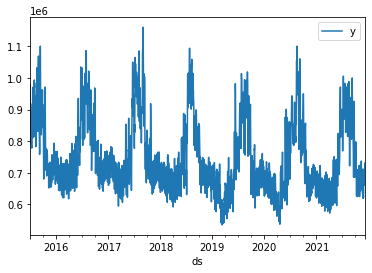

In [ ]:
# read the raw *daily* data
df = pd.read_excel('./input/Region_CAL.xlsx', sheet_name='Published Daily Data', header=0, 
                    usecols = ['Local date', 'D'])
# format to Prophet convention - both Prophet and Neural Prophet adhere to it
df.columns = ['ds','y']
df['ds'] = pd.to_datetime(df['ds'])

df.plot(x="ds",y="y")

In [ ]:
# We split the data into training / validation (= last 365 days)
df_train, df_valid = df.iloc[:-365], df.iloc[-365:]

Fitting the basic Prophet model and generating a forecast is a familiar routine by now:

In [ ]:
m_vanilla = Prophet()
m_vanilla.fit(df_train)

future = m_vanilla.make_future_dataframe(periods=365)
forecast_vanilla = m_vanilla.predict(future)

m_vanilla.plot(forecast_vanilla, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total nof cases')
print()

NameError: name 'Prophet' is not defined

In [ ]:
m_vanilla.plot_components(forecast_vanilla, figsize=(CFG.img_dim1, CFG.img_dim2)); print()

NameError: name 'm_vanilla' is not defined

Neural Prophet requires minimal adjustments to the syntax:

In [25]:
from neuralprophet import NeuralProphet
pd.options.mode.chained_assignment = None

m_neural = NeuralProphet()
metrics = m_neural.fit(df_train, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.95% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


RuntimeError: Numpy is not available

In [ ]:
df_future = m_neural.make_future_dataframe(df_train, periods=365)
forecast_neural = m_neural.predict(df_future)
# create plots
fig_forecast = m_neural.plot(forecast_neural, figsize=(CFG.img_dim1, CFG.img_dim2))

In [ ]:
fig_components = m_neural.plot_components(forecast_neural, figsize=(CFG.img_dim1, CFG.img_dim2))

What about the actual predicted values?

In [ ]:


df_valid['forecast_vanilla'] = forecast_vanilla.yhat.tail(365).values
df_valid['forecast_neural'] = forecast_neural.yhat1.values

In [ ]:
from sklearn.metrics import mean_squared_error as mse, median_absolute_error as mae

def my_mse(x,y):
    return np.round(np.sqrt(mse(x, y)),2)

def my_mae(x,y):
    return np.round(np.sqrt(mae(x, y)),2)

In [ ]:
df_valid.dropna(inplace = True)


err1 = my_mse(df_valid['y'], df_valid['forecast_vanilla'])
err2 = my_mse(df_valid['y'], df_valid['forecast_neural'])

print('MSE vanilla: ' + str(err1))
print('MSE neural : ' + str(err2))

err1 = my_mae(df_valid['y'], df_valid['forecast_vanilla'])
err2 = my_mae(df_valid['y'], df_valid['forecast_neural'])

print('   ')
print('MAE vanilla: ' + str(err1))
print('MAE neural : ' + str(err2))

As we can see above, even with default settings (no lags, only the AR-Net used to model serial dependence) the Neural Prophet can outperform the basic version. 


This concludes the notebook dedicated to Prophet - next, we will have a look at a framework that integrates multiple models encountered so far. Stay tuned!

In [ ]:
import numpy as np 
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns


import statsmodels.api as sm

plt.style.use('fivethirtyeight')
# Figure size parameters

class CFG:
    img_dim1 = 20
    img_dim2 = 10
    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})

# Data and EDA

\begin{equation}
X_t = T_t + S_t + C_t + \epsilon_t
\end{equation}

Dedicated notebook: https://www.kaggle.com/konradb/ts-0-the-basics

In [ ]:
df = pd.read_csv('./input/us_energy.csv')
df.head(3)

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)
df.plot()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df, period = 12)
figure = decomposition.plot()
plt.show()

In [ ]:
decomposition = seasonal_decompose(df['value'], period = 11, model = 'multiplicative')
figure = decomposition.plot()
plt.show()

In [ ]:
decomposition = seasonal_decompose(df['value'], period = 12, model = 'multiplicative')
figure = decomposition.plot()
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['value'])
print()

In [ ]:
plot_pacf(df['value'])
print()

# Smoothing methods

Dedicated notebook: https://www.kaggle.com/konradb/ts-1a-smoothing-methods

In [ ]:
# training / validation split
cutoff_date = '2005-12-31'
df['value'] /= 100
xtrain, xvalid  = df.loc[df.index <= cutoff_date], df.loc[df.index > cutoff_date]
print(xtrain.shape, xvalid.shape)

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


fit1 = ExponentialSmoothing(xtrain['value'].values, seasonal_periods = 12,
                           trend = 'mul', seasonal = 'mul')

In [ ]:
fit1 = fit1.fit()

In [ ]:
prediction = fit1.forecast(len(xvalid)).copy()

xresiduals = xvalid['value'] - prediction

In [ ]:
fit1.params_formatted

In [ ]:
plot_acf(xresiduals, lags = 25)
print()

In [ ]:
plot_pacf(xresiduals, lags = 25)
print()

# Prophet

Dedicated notebook:  https://www.kaggle.com/konradb/ts-1b-prophet

Dataset: https://www.kaggle.com/piantic/autonomous-greenhouse-challengeagc-2nd-2019

In [ ]:
from fbprophet import Prophet

In [ ]:
xdat = pd.read_csv('./input/GreenhouseClimate1.csv')
xdat.head(3)

In [ ]:
xdat['time'] = pd.to_datetime(xdat['time'], unit = 'D', origin = "1899-12-30")
xdat.head(3)

In [ ]:
list1 = ['time', 'Tair']

list2 = ['co2_sp', 'dx_sp', 't_rail_min_sp', 't_grow_min_sp',
        'assim_sp', 'scr_enrg_sp', 'scr_blck_sp', 't_heat_sp',
        't_vent_sp', 'window_pos_lee_sp', 'water_sup_intervals_sp_min',
        'int_blue_sp', 'int_red_sp', 'int_farred_sp',
        'int_white_sp']

xdat = xdat[list1 + list2]

In [ ]:
xdat2 = xdat.resample('H', on = 'time').mean().reset_index()[list1 + list2]

In [ ]:
np.isnan(xdat2[['Tair'] + list2]).describe()

It does not matter if there are nulls when we are using prophet

In [ ]:
np.isnan(xdat2[['Tair'] + list2]).describe()

xdat2.dropna(subset = ['Tair'], inplace = True)

In [ ]:
xdat2['Tair'][0:1000].plot()

In [ ]:
df = xdat2[['time', 'Tair']].rename(columns={"time": "ds", "Tair": "y"})

In [ ]:
df.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')

In [ ]:
m = Prophet(weekly_seasonality=False, # Dropping the option of weekly seasonality, drop seasonality where it does not make sense as prophet choses that on its own
            interval_width = 0.95, # Fits curves like exponential smoothening. Point forcasts like ES does not allow the flexibility to add a confidence of error(measure of uncertainity) while prediction. This flexibilty is present in the prophet model. This is generated by sampling the Monte carlo samples from the data and averaging them.
            mcmc_samples = 10)

In [ ]:
m.fit(df)

In [ ]:
future = m.make_future_dataframe(periods = 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast)
print()

# If your confidence interval covers zero then ignore, because then difference from baseline is irrelevant.

In [ ]:
m = Prophet(weekly_seasonality=False, interval_width = 0.95)

m.fit(df)
future = m.make_future_dataframe(periods= 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics

In [ ]:
df_cv = cross_validation(m,initial = '3700 hours', period = '24 hours', horizon = '24 hours')
df_cv.head(10)

In [ ]:
df_p1 = performance_metrics(df_cv)
df_p1.head(10)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
# incorporate the climate and irrigation setpoints

xdat2 = xdat2.dropna()

estimator = Ridge()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(xdat2[list2], xdat2['Tair'])
# 
to_keep = xdat2[list2].columns[selector.support_]


print(to_keep)

In [ ]:
df = xdat2[['time', 'Tair']].rename(columns={"time": "ds", "Tair": "y"})

m = Prophet(weekly_seasonality=False, interval_width = 0.95)

# add the regressors to the dataframe holding the data
for f in to_keep:    
    df[f] = xdat2[f]
    m.add_regressor(f)

# the rest proceeds as before. 
m.fit(df)

In [ ]:
# we repeat the same evaluation tactic as before
df_cv = cross_validation(m, initial = '3700 hours', period = '24 hours', horizon='24 hours')
df_p2 = performance_metrics(df_cv)

In [ ]:
comparison = pd.DataFrame()
comparison['raw'] = df_p1.mean(axis = 0)[1:]
comparison['covariates'] = df_p2.mean(axis = 0)[1:]

print(comparison)

Neural Prophet NN component: https://www.arxiv-vanity.com/papers/1911.12436/

In [ ]:
!pip install neuralprophet

In [ ]:
from neuralprophet import NeuralProphet

In [ ]:
df = xdat2[['time', 'Tair']].rename(columns={"time": "ds", "Tair": "y"})

model = NeuralProphet(weekly_seasonality = False)

model.fit(df, freq="H")
# forecast
df_predict = model.make_future_dataframe(df, periods= 24)
df_predict = model.predict(df_predict)
fig = model.plot(df_predict)